In [1]:
import tensorflow as tf
import torch
import random
import os
import pathlib
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
from sklearn.preprocessing import OneHotEncoder
tf.config.run_functions_eagerly(True)


In [40]:
#change current directory up to parent, only run 1 time!
os.chdir("..")

In [3]:
#encoder
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

# load data

In [41]:
def load_data(test=False,Print=False,path=f'{os.path.abspath(os.curdir)}/data/carseg_data/clean_data',nr_img=1498):
    train_data_input=[]
    train_data_target=[]
    
    for n in range(nr_img):
        n1=n
        if test:
            n1=f'{n}_a'
        try:
            test1=np.load(f'{path}/{n1}.npy')
            inputs=test1[:3].transpose()
            inputs=tf.convert_to_tensor(inputs)
            inputs=inputs[tf.newaxis,...]
            target=test1[3].transpose()
            target=tf.convert_to_tensor(target)
            target=target[...,tf.newaxis]
            target=target[tf.newaxis,...]

            
            train_data_input.append(inputs)
            train_data_target.append(target)
        except:
            if Print:
                print(f'fil nr {n} mangeler')
    return [train_data_input,train_data_target]

In [114]:
test_data=load_data(test=True)
train_data=load_data()

In [115]:
def Get_stats(data):
    print(f'Number of training img {len(data[0])}')
    print(f'target sahpe {data[1][0].shape}')
    print(f'input shape {data[0][0].shape}')

print('test_data:')
Get_stats(test_data)
print('train_data:')
Get_stats(train_data)

test_data:
Number of training img 99
target sahpe (1, 256, 256, 1)
input shape (1, 256, 256, 3)
train_data:
Number of training img 1128
target sahpe (1, 256, 256, 1)
input shape (1, 256, 256, 3)


#  one hot encoder


In [116]:
depth = 8

In [117]:
test_data2=tf.one_hot(test_data[1], depth)[:,:,:,:,0,:]
train_data2=tf.one_hot(train_data[1], depth)[:,:,:,:,0,:]

In [118]:
test_data[1]=test_data2
train_data[1]=train_data2

In [120]:
print('test_data:')
Get_stats(test_data)
print('train_data:')
Get_stats(train_data)

test_data:
Number of training img 99
target sahpe (1, 256, 256, 8)
input shape (1, 256, 256, 3)
train_data:
Number of training img 1128
target sahpe (1, 256, 256, 8)
input shape (1, 256, 256, 3)


In [119]:
example_input, example_target=test_data[0][0],test_data[1][0]

In [8]:
down_model = downsample(3, 4)

In [9]:
#decoder
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [10]:
up_model = upsample(3, 4)
print(up_model)

In [11]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  OUTPUT_CHANNELS=8
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)
  softlayer=tf.keras.layers.Softmax(axis = -1)


  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)
  
  x = softlayer(x)
  #x = tf.math.argmax(x, axis = -1)[...,tf.newaxis]
  return tf.keras.Model(inputs=inputs, outputs=x)

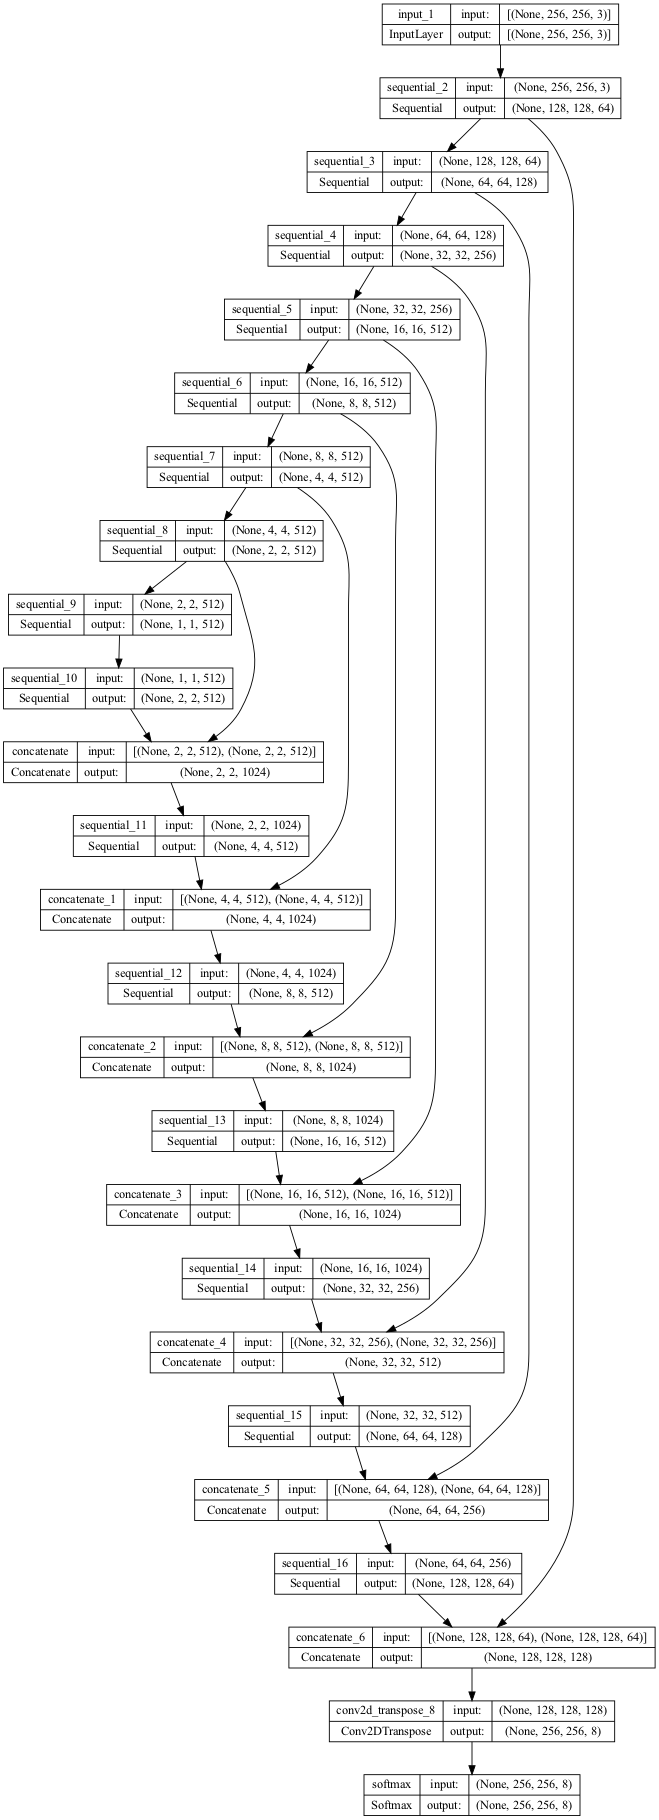

In [12]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

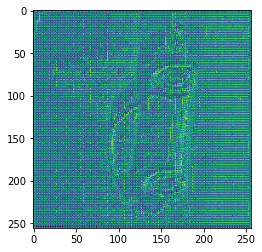

In [13]:
#print(test_data[0][0].shape)
gen_output = generator(test_data[0][0], training=False)
#print(gen_output.shape)
gen_output = tf.math.argmax(gen_output, axis = -1)[...,tf.newaxis]
#print(gen_output.shape)
plt.imshow(gen_output[0, ...])
#print(gen_output)

# loos

In [14]:
LAMBDA = 100

In [15]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def generator_loss(disc_generated_output, gen_output,  target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  print(type(target))
  print(type(gen_output))
  target=tf.cast(target, tf.float32)
  gen_output=tf.cast(gen_output, tf.float32)

  l111=(target) - (gen_output)
  l11=tf.abs(l111)
  l1_loss = tf.reduce_mean(l11)

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [17]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

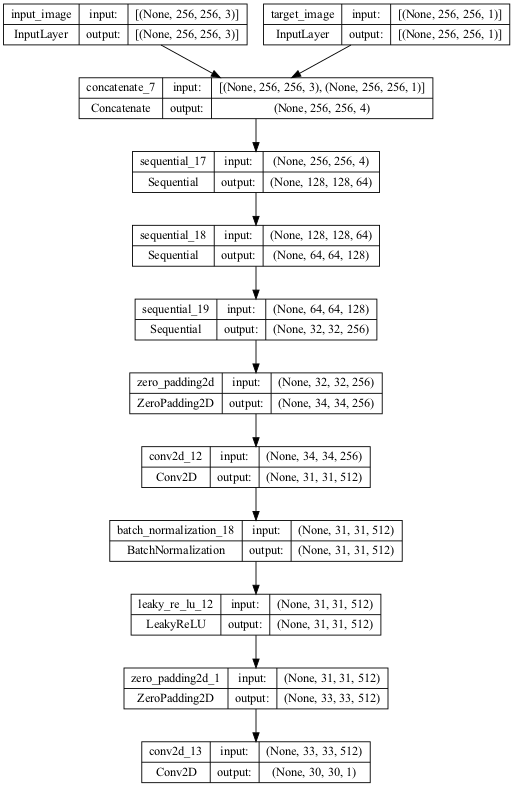

In [18]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [19]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [21]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  prediction = tf.math.argmax(prediction, axis = -1)[...,tf.newaxis]
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i]) #* 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [22]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [23]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    gen_output = tf.math.argmax(gen_output, axis = -1)[...,tf.newaxis]

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [24]:
def fit(train_ds, test_ds, steps):
  randomnr=random.randint(0,len(test_ds[0])-1)
  example_input, example_target=test_ds[0][randomnr],test_data[1][randomnr]
  start = time.time()
  
  for step in range(steps):
    r1=random.randint(0,len(train_ds[0])-1)
    input_image=train_ds[0][r1]
    target=train_ds[1][r1] 
    if (step) % 10 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 10 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}0")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

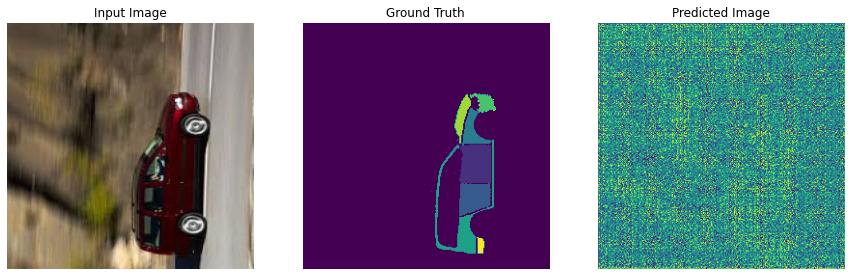

Step: 00
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


ValueError: No gradients provided for any variable: (['conv2d_1/kernel:0', 'conv2d_2/kernel:0', 'batch_normalization_2/gamma:0', 'batch_normalization_2/beta:0', 'conv2d_3/kernel:0', 'batch_normalization_3/gamma:0', 'batch_normalization_3/beta:0', 'conv2d_4/kernel:0', 'batch_normalization_4/gamma:0', 'batch_normalization_4/beta:0', 'conv2d_5/kernel:0', 'batch_normalization_5/gamma:0', 'batch_normalization_5/beta:0', 'conv2d_6/kernel:0', 'batch_normalization_6/gamma:0', 'batch_normalization_6/beta:0', 'conv2d_7/kernel:0', 'batch_normalization_7/gamma:0', 'batch_normalization_7/beta:0', 'conv2d_8/kernel:0', 'batch_normalization_8/gamma:0', 'batch_normalization_8/beta:0', 'conv2d_transpose_1/kernel:0', 'batch_normalization_9/gamma:0', 'batch_normalization_9/beta:0', 'conv2d_transpose_2/kernel:0', 'batch_normalization_10/gamma:0', 'batch_normalization_10/beta:0', 'conv2d_transpose_3/kernel:0', 'batch_normalization_11/gamma:0', 'batch_normalization_11/beta:0', 'conv2d_transpose_4/kernel:0', 'batch_normalization_12/gamma:0', 'batch_normalization_12/beta:0', 'conv2d_transpose_5/kernel:0', 'batch_normalization_13/gamma:0', 'batch_normalization_13/beta:0', 'conv2d_transpose_6/kernel:0', 'batch_normalization_14/gamma:0', 'batch_normalization_14/beta:0', 'conv2d_transpose_7/kernel:0', 'batch_normalization_15/gamma:0', 'batch_normalization_15/beta:0', 'conv2d_transpose_8/kernel:0', 'conv2d_transpose_8/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'conv2d_1/kernel:0' shape=(4, 4, 3, 64) dtype=float32, numpy=
array([[[[ 0.00357772, -0.01213671,  0.02669905, ...,  0.0227257 ,
          -0.0061902 , -0.00644759],
         [ 0.01669022,  0.02348545,  0.02448037, ..., -0.01190574,
          -0.00600189,  0.0209133 ],
         [ 0.02714665, -0.0140148 ,  0.00178825, ..., -0.0042585 ,
           0.03516535,  0.01387414]],

        [[ 0.03813057,  0.04951398,  0.00325143, ..., -0.0048346 ,
          -0.01631098, -0.01438354],
         [ 0.0104396 ,  0.00465305,  0.00542544, ...,  0.04715483,
          -0.00827914,  0.0047143 ],
         [ 0.02572569,  0.02633224, -0.00493879, ...,  0.03157984,
           0.02396656, -0.00307173]],

        [[ 0.01818028, -0.00086848, -0.01610806, ...,  0.00675578,
           0.00153782,  0.01324067],
         [-0.00739304,  0.02087636, -0.0059693 , ..., -0.01371332,
           0.00365164,  0.027143  ],
         [-0.00771909, -0.01176327, -0.00021263, ...,  0.00823927,
           0.04143855, -0.01405435]],

        [[-0.00870703, -0.00132914, -0.00840542, ..., -0.00515818,
           0.01992428,  0.00884529],
         [-0.00195851, -0.00531548,  0.02744051, ..., -0.0033801 ,
           0.03521389,  0.01195054],
         [-0.00982214, -0.06024606, -0.03332587, ..., -0.00143817,
          -0.03916829, -0.01395751]]],


       [[[ 0.0225687 ,  0.00484999,  0.01408042, ...,  0.01930496,
          -0.02521718,  0.00737604],
         [-0.00266145,  0.01079525, -0.00732411, ..., -0.00018038,
           0.01872341, -0.00542061],
         [ 0.01417733,  0.01065018, -0.00707893, ...,  0.01383487,
           0.04278305,  0.02012214]],

        [[ 0.00152559,  0.00423418, -0.01978463, ..., -0.03703753,
          -0.00811888, -0.03430528],
         [ 0.00612874,  0.04698192, -0.0303376 , ...,  0.02691467,
           0.00283533,  0.01989403],
         [ 0.01184753,  0.03289922,  0.00142095, ...,  0.02495065,
           0.03130851, -0.02589663]],

        [[-0.00057451, -0.01612705,  0.0023218 , ...,  0.04060119,
          -0.03355426, -0.02517418],
         [-0.03234397,  0.01160728,  0.01693493, ...,  0.01102047,
          -0.01005659,  0.02844374],
         [-0.00911136,  0.01814469,  0.00968015, ..., -0.02033216,
          -0.01838761,  0.01660907]],

        [[ 0.02363452,  0.01410045,  0.00725566, ..., -0.03674615,
          -0.00447045,  0.00213988],
         [ 0.01892888, -0.01730335,  0.02362136, ..., -0.0191366 ,
          -0.0214665 , -0.01192656],
         [-0.00232608, -0.02409543,  0.00587351, ...,  0.02486786,
          -0.00775211,  0.00612722]]],


       [[[-0.04472417, -0.01946456, -0.03716172, ..., -0.0087362 ,
           0.04637543,  0.00840594],
         [ 0.0007728 ,  0.03759378, -0.03445885, ..., -0.01604795,
          -0.00133983,  0.00318382],
         [-0.00705954,  0.01973071, -0.03157656, ..., -0.00495026,
          -0.00574859,  0.01639959]],

        [[ 0.02141633, -0.01957599, -0.0099118 , ...,  0.00757339,
           0.01705529,  0.01348781],
         [ 0.03751262,  0.00469011, -0.00365541, ..., -0.02106829,
          -0.01963789,  0.00919077],
         [ 0.02297264,  0.00214571, -0.01701579, ..., -0.0028821 ,
          -0.0127888 ,  0.01581061]],

        [[ 0.03261113, -0.00575859, -0.01438023, ..., -0.00569143,
          -0.03850674,  0.04405813],
         [-0.01572704, -0.02580865,  0.00575635, ...,  0.01002297,
           0.00291294,  0.00150078],
         [-0.02361259, -0.02320719,  0.01768932, ...,  0.02648674,
           0.00053264,  0.02788924]],

        [[ 0.00889324, -0.03623705, -0.01360236, ..., -0.01057931,
           0.0077919 , -0.01078948],
         [ 0.02262202,  0.00215983, -0.00361902, ..., -0.02008838,
          -0.00345138,  0.02387668],
         [-0.01308311, -0.02453377, -0.00991204, ...,  0.00503605,
          -0.00344746, -0.00554584]]],


       [[[-0.0328495 ,  0.01091167,  0.04793212, ...,  0.00629044,
           0.01517055,  0.0198409 ],
         [-0.01238091, -0.002733  , -0.01037254, ...,  0.00174668,
           0.0102622 ,  0.01311872],
         [ 0.01845482,  0.00090666,  0.00472444, ..., -0.00780683,
           0.0081539 ,  0.00429941]],

        [[-0.01345131,  0.00352257, -0.01222936, ...,  0.02872543,
          -0.00516198, -0.01539796],
         [ 0.01782513, -0.00803174, -0.02508317, ..., -0.00795725,
          -0.0070056 ,  0.00892679],
         [ 0.01984349,  0.03358614,  0.03489258, ...,  0.00699604,
           0.01309765, -0.03194848]],

        [[-0.0060944 ,  0.01215103,  0.00108114, ...,  0.03247172,
           0.00891062, -0.00253372],
         [-0.04391452, -0.01065767, -0.02389937, ..., -0.02057248,
          -0.00794983, -0.00915152],
         [ 0.02123675, -0.00781071,  0.03193158, ..., -0.00518203,
           0.00279201,  0.00829155]],

        [[ 0.01231515, -0.01126921, -0.00839876, ...,  0.01791806,
          -0.0089993 , -0.02075829],
         [-0.01556642,  0.00509381, -0.01006273, ..., -0.01330882,
          -0.01888826, -0.0138591 ],
         [ 0.02039432,  0.00135361, -0.00904537, ..., -0.00498368,
          -0.01821553,  0.0257507 ]]]], dtype=float32)>), (None, <tf.Variable 'conv2d_2/kernel:0' shape=(4, 4, 64, 128) dtype=float32, numpy=
array([[[[-8.47352855e-03,  4.87494748e-03, -1.73397344e-02, ...,
          -1.91013254e-02,  1.36961350e-02, -1.03474623e-02],
         [-1.13384519e-02, -1.58523787e-02, -4.13194904e-03, ...,
           1.22385761e-02,  1.32221542e-02, -8.68555531e-03],
         [-4.52804659e-03, -4.96876054e-02, -1.75790675e-02, ...,
           2.65607443e-02,  4.38006176e-03,  4.20846650e-03],
         ...,
         [-2.57219542e-02, -1.04836887e-02, -1.58978738e-02, ...,
           5.00335707e-04,  9.84146493e-04,  2.26341132e-02],
         [ 2.20207870e-02,  2.52982136e-02, -4.23616022e-02, ...,
           2.83698533e-02,  1.46427248e-02, -1.30608687e-02],
         [-4.00259113e-03, -1.09361447e-02,  4.93796682e-03, ...,
          -1.60485525e-02,  2.47238725e-02,  2.35488620e-02]],

        [[ 5.57662454e-03,  7.17802020e-03,  7.38289719e-03, ...,
           9.95462388e-03,  1.10246278e-02, -1.94417331e-02],
         [ 1.16411922e-03,  1.81937905e-03,  3.74040678e-02, ...,
           2.45735142e-02,  7.41442060e-03,  1.23572513e-03],
         [ 1.45004159e-02, -2.69229412e-02,  1.11593737e-03, ...,
           6.79548644e-03,  1.00841066e-02, -4.85026697e-03],
         ...,
         [-2.20787395e-02, -3.09635922e-02, -2.02695262e-02, ...,
           2.47418731e-02,  1.71451010e-02,  2.01057047e-02],
         [ 2.09251046e-03,  6.51621679e-03,  1.17819961e-02, ...,
          -2.22165268e-02,  1.24334497e-02, -9.36872978e-03],
         [ 1.16083296e-02, -1.72304083e-02,  8.21243878e-03, ...,
          -2.99234688e-02, -1.84399392e-02, -4.25342843e-03]],

        [[-1.38886450e-02,  1.62030179e-02,  7.50385632e-04, ...,
          -1.78141007e-03, -7.10153626e-03, -7.93021638e-03],
         [ 1.48599120e-02,  1.01645952e-02, -2.87670493e-02, ...,
          -2.78268401e-02, -3.08845267e-02, -1.29592963e-05],
         [ 8.49470962e-03,  3.87149528e-02,  4.60191146e-02, ...,
           2.94154026e-02, -1.77369788e-02, -1.14037711e-02],
         ...,
         [ 5.15966350e-03, -2.23155487e-02, -2.50302628e-02, ...,
          -2.83447895e-02,  2.01466936e-03,  1.03303492e-02],
         [ 2.87055653e-02,  4.10812069e-03,  7.64397206e-03, ...,
          -6.91466732e-03, -1.10522900e-02, -2.80067064e-02],
         [ 3.91440187e-03, -2.71490570e-02,  1.08280238e-02, ...,
           6.45000255e-05, -1.37696201e-02,  1.34435343e-02]],

        [[-2.16361880e-02,  7.57158641e-03, -2.22600978e-02, ...,
          -3.92664829e-03,  1.88676696e-02,  1.06359348e-02],
         [ 1.33378319e-02, -1.76364258e-02,  5.68967499e-03, ...,
          -4.92117144e-02,  8.63438006e-03,  1.77643877e-02],
         [-2.15026736e-02, -5.18406322e-03,  3.24552730e-02, ...,
           3.85549217e-02,  2.10969578e-02, -1.73142795e-02],
         ...,
         [ 7.94318679e-04,  3.29095460e-02, -3.68131115e-03, ...,
           1.62985530e-02, -9.68996342e-03,  1.63484085e-02],
         [ 3.12061645e-02,  4.12773415e-02,  1.35781094e-02, ...,
          -2.13814825e-02, -1.47106284e-02,  5.82211884e-04],
         [ 8.97162501e-03,  7.73965754e-03, -4.92912903e-03, ...,
           4.23656367e-02, -2.73405816e-02, -3.29300226e-03]]],


       [[[ 6.65686093e-03,  1.22363418e-02,  1.15916170e-02, ...,
           2.97384225e-02, -9.23885405e-03, -1.19545893e-03],
         [ 1.75671112e-02,  2.34430358e-02, -1.36306165e-02, ...,
          -1.42662991e-02, -3.52696851e-02, -1.37136178e-02],
         [ 2.16874648e-02,  4.57294565e-03, -1.96245685e-02, ...,
          -3.52079660e-04, -1.79097131e-02, -1.68369785e-02],
         ...,
         [ 1.15615763e-02,  1.12362402e-02,  4.91471356e-03, ...,
          -1.37584684e-02, -2.88930768e-03, -1.93332997e-03],
         [ 1.74228922e-02,  3.89899546e-03,  1.54884672e-02, ...,
          -2.23739780e-02,  1.81974452e-02, -1.53938383e-02],
         [ 2.69137113e-03, -3.79249628e-04, -1.10298870e-02, ...,
          -3.10655870e-02,  6.30839821e-03, -2.13221787e-03]],

        [[-2.34467583e-03,  3.08231195e-03,  3.75372991e-02, ...,
          -1.28516220e-02,  1.17093929e-04,  1.67680159e-02],
         [ 1.70046818e-02,  2.13357303e-02,  4.23206389e-03, ...,
           3.88121977e-02, -1.31578213e-02,  1.70259867e-02],
         [ 6.91026729e-03,  2.55155414e-02, -1.34658522e-03, ...,
           2.18593329e-02,  1.31515823e-02, -3.04879826e-02],
         ...,
         [-5.73173340e-04,  3.92957311e-03, -8.34839139e-03, ...,
          -3.24328616e-02, -8.33366439e-03, -1.51211517e-02],
         [-5.80169959e-03,  1.83173101e-02, -1.28971450e-02, ...,
          -1.71122644e-02, -1.80547815e-02, -1.24308486e-02],
         [ 1.57310013e-02,  3.87109481e-02, -3.15515473e-02, ...,
          -1.18116625e-02,  1.47025008e-02, -1.16040669e-02]],

        [[-3.35240178e-02,  1.46749411e-02, -2.34700125e-02, ...,
          -1.55286817e-02,  1.59216858e-02,  3.09472270e-02],
         [-7.34466314e-03,  2.97570731e-02, -9.51033272e-03, ...,
          -1.40711106e-02, -3.33848558e-02,  2.27256748e-03],
         [-3.10671912e-03,  3.68372425e-02,  1.05257402e-03, ...,
           1.96932591e-02, -2.95752138e-02, -5.17536374e-03],
         ...,
         [ 3.50136943e-02,  4.18110415e-02,  1.26657244e-02, ...,
          -3.82904633e-04,  4.60132845e-02,  2.03148965e-02],
         [ 4.43906486e-02, -3.65969725e-02, -4.61182371e-03, ...,
           3.75779322e-03,  4.39964788e-04,  1.98598616e-02],
         [ 6.90887962e-03, -1.07391365e-02, -4.34953254e-04, ...,
          -1.93842351e-02,  1.83271300e-02, -1.44520951e-02]],

        [[ 3.22040077e-03,  2.43953839e-02,  8.98048468e-03, ...,
          -2.12559104e-03,  4.39970493e-02,  2.94676274e-02],
         [ 1.84034761e-02, -4.95864137e-04,  2.39115693e-02, ...,
          -2.23719776e-02,  1.42044183e-02,  3.20294290e-03],
         [ 3.63655910e-02, -4.93110390e-03, -3.41233332e-03, ...,
           6.12302544e-03,  1.27786845e-02,  2.16974523e-02],
         ...,
         [ 1.71799341e-03,  3.80566977e-02, -2.33620163e-02, ...,
           3.33436219e-05, -8.76912568e-03, -8.14624783e-03],
         [ 1.02388086e-02, -2.61024255e-02,  1.93499830e-02, ...,
          -8.79609957e-03,  5.56515902e-03,  3.92280966e-02],
         [-3.03333253e-03, -3.57660465e-02,  2.81384634e-03, ...,
          -3.41965035e-02,  1.35983210e-02,  8.63193162e-03]]],


       [[[ 9.66384541e-03,  4.34038378e-02, -4.16005962e-03, ...,
          -1.63775962e-03, -3.99689749e-03, -1.02664973e-03],
         [ 2.03130506e-02,  2.82889954e-03,  1.49653358e-02, ...,
          -1.43535882e-02,  3.15700136e-02, -1.39069157e-02],
         [-2.70861983e-02, -9.18363221e-03, -9.79709439e-03, ...,
           1.33511722e-02,  1.41309714e-02,  3.36071923e-02],
         ...,
         [-2.08368804e-02,  1.86215353e-03, -1.08794365e-02, ...,
          -3.37155722e-02, -4.91588842e-04, -4.54523647e-03],
         [ 1.54429851e-02, -1.00539261e-02, -1.43563794e-02, ...,
           1.03052864e-02,  1.56754581e-03,  2.50692177e-03],
         [ 2.63604429e-02,  1.03600249e-02, -2.65806653e-02, ...,
          -2.64621130e-03,  3.11491396e-02, -3.09545659e-02]],

        [[-3.46757770e-02, -5.02300030e-03, -2.86520571e-02, ...,
          -3.58954258e-02, -8.11240822e-03, -8.76645371e-03],
         [ 1.19544826e-02, -1.16746025e-02, -5.99085214e-03, ...,
          -2.04731640e-03,  3.10378838e-02,  5.21454476e-02],
         [-4.20189492e-04, -1.83795970e-02, -1.89859921e-03, ...,
          -6.54180627e-03,  4.41826768e-02,  2.17970293e-02],
         ...,
         [-1.14588263e-02,  1.07720410e-02,  2.00648662e-02, ...,
          -6.83235144e-03,  1.17912143e-02, -9.26019449e-04],
         [-1.37136616e-02,  1.34663768e-02,  1.15094138e-02, ...,
          -1.19646974e-02, -1.83857523e-03,  8.42695954e-05],
         [-5.49887726e-03,  1.78115945e-02, -1.73151270e-02, ...,
          -1.20838564e-02,  1.11243604e-02,  1.73167661e-02]],

        [[ 3.44251306e-03,  2.76941229e-02,  5.81427198e-03, ...,
          -2.52645183e-02,  1.43951615e-02,  1.94562804e-02],
         [-2.83366907e-02,  6.28270907e-03, -5.75757632e-03, ...,
           2.03464478e-02, -4.11400991e-03,  1.69950798e-02],
         [-2.07115933e-02,  2.81706471e-02, -2.07595956e-02, ...,
          -1.55838225e-02, -6.46351185e-03, -1.26079954e-02],
         ...,
         [ 1.20687708e-02,  3.47198658e-02, -1.45027635e-03, ...,
          -1.99933704e-02, -1.52628096e-02,  1.85126327e-02],
         [ 2.17104200e-02, -1.37202367e-02, -1.60534438e-02, ...,
           5.20256395e-03, -1.69822220e-02,  2.24201549e-02],
         [ 1.52139692e-02,  1.23588159e-03,  2.34713741e-02, ...,
           3.33117917e-02,  1.20413480e-02, -1.32411635e-02]],

        [[ 3.44852991e-02, -2.86576115e-02,  3.66615574e-03, ...,
           2.24807449e-02,  2.13259719e-02,  7.58642680e-04],
         [-1.09488461e-02, -1.99289396e-02, -2.44712401e-02, ...,
           2.50982810e-02,  4.51103784e-02, -8.78797658e-03],
         [ 1.41416378e-02,  1.42994495e-02, -1.37566344e-03, ...,
          -1.14451051e-02, -3.02081481e-02,  1.09310281e-02],
         ...,
         [ 8.55095033e-03, -2.39128154e-02,  1.43836336e-02, ...,
          -4.58481582e-03,  2.93964371e-02,  4.36516292e-03],
         [-1.71517879e-02,  1.53363328e-02, -3.45873795e-02, ...,
           1.29004242e-03,  3.37920035e-03,  2.79385620e-03],
         [-2.02087662e-03,  5.89756994e-03,  3.62381749e-02, ...,
          -3.24323252e-02,  4.00535343e-03, -4.27018851e-03]]],


       [[[ 1.76882639e-03,  3.41228992e-02,  1.82746444e-02, ...,
          -2.76567470e-02,  8.52291659e-03,  2.88049714e-03],
         [ 3.37539874e-02,  1.13689096e-03,  7.51393801e-03, ...,
          -1.15486998e-02, -5.66998404e-03, -3.35509814e-02],
         [ 1.62149575e-02, -2.10967921e-02, -3.51257659e-02, ...,
          -1.66247562e-02, -1.71237439e-02, -3.37930992e-02],
         ...,
         [-9.38650803e-04, -4.68168699e-04,  1.47151817e-02, ...,
          -4.82237265e-02, -2.42816750e-03,  4.77614906e-03],
         [-3.24571156e-03,  9.42689274e-03,  1.93131082e-02, ...,
          -2.68794643e-03,  5.78320725e-03,  1.70054995e-02],
         [ 1.69212557e-02, -1.27445385e-02, -1.66395176e-02, ...,
          -8.65704351e-05, -1.94713343e-02,  7.21026817e-03]],

        [[-1.02482121e-02, -4.12506144e-03, -2.21250132e-02, ...,
          -6.51043700e-03, -4.33182518e-04, -1.44414883e-02],
         [-1.35381948e-02,  7.18550850e-03,  3.62902577e-03, ...,
          -2.61350796e-02,  2.27099676e-02, -4.53494489e-03],
         [-7.67206587e-03, -1.09515944e-03, -3.30716968e-02, ...,
          -3.24818529e-02,  1.16963238e-02,  2.94976681e-02],
         ...,
         [-3.21951248e-02, -6.95644645e-03, -1.51218995e-02, ...,
           1.51940137e-02,  2.80432012e-02, -6.48931717e-04],
         [ 1.17289349e-02,  3.12790535e-02, -5.35703218e-03, ...,
          -2.88566351e-02, -3.27611119e-02, -3.42699676e-03],
         [ 5.13293687e-03, -2.02889945e-02,  4.63009439e-02, ...,
           1.71612464e-02,  2.26305127e-02,  2.11022310e-02]],

        [[ 2.08893344e-02, -5.63936913e-03, -1.73768513e-02, ...,
          -8.51167180e-03, -4.27487567e-02, -2.26008631e-02],
         [-5.64709455e-02, -9.56568774e-03, -1.20441737e-02, ...,
           4.44181962e-03, -7.58892624e-03, -5.09884348e-03],
         [ 1.44640850e-02,  1.27848494e-03,  2.51185731e-03, ...,
          -4.62886598e-03, -1.84108522e-02,  1.67908631e-02],
         ...,
         [ 2.31408179e-02, -3.50003727e-02, -4.26904112e-03, ...,
          -7.99741689e-03, -1.42964423e-02, -1.49894254e-02],
         [-9.85032879e-03, -1.53890401e-02, -1.07298149e-02, ...,
           3.87382060e-02, -2.15579346e-02, -5.86226583e-03],
         [ 1.79042213e-03,  9.31407511e-03, -1.42482929e-02, ...,
           1.87846925e-02, -8.90405010e-03,  2.38163676e-02]],

        [[-3.59380469e-02,  1.44248661e-02,  1.74908023e-02, ...,
          -3.03577986e-02, -9.74313915e-03, -3.90766747e-03],
         [ 1.58735495e-02, -2.10060067e-02,  2.74268351e-02, ...,
           7.09062582e-03,  1.61476806e-02, -1.42128738e-02],
         [ 3.04409023e-03,  5.37780579e-03,  1.28077285e-03, ...,
          -1.41409300e-02, -8.66947230e-03,  3.32100652e-02],
         ...,
         [-1.31379599e-02, -1.81435347e-02, -2.16118600e-02, ...,
           1.73458457e-02, -1.57165527e-02, -3.69105153e-02],
         [-1.89581197e-02,  1.46082873e-02, -3.40353213e-02, ...,
           2.74942741e-02, -3.54087492e-03,  4.58850898e-03],
         [ 2.64043473e-02, -2.96725929e-02,  7.31522497e-03, ...,
           1.39783844e-02,  4.10991348e-03,  2.02755164e-02]]]],
      dtype=float32)>), (None, <tf.Variable 'batch_normalization_2/gamma:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>), (None, <tf.Variable 'batch_normalization_2/beta:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>), (None, <tf.Variable 'conv2d_3/kernel:0' shape=(4, 4, 128, 256) dtype=float32, numpy=
array([[[[ 1.64676812e-02, -1.95003394e-02,  1.15773780e-02, ...,
          -1.66890528e-02, -9.32594761e-03,  1.74214058e-02],
         [-1.06649566e-02, -2.43666247e-02, -8.04382935e-03, ...,
           4.67252731e-02, -1.23671219e-02,  6.82539103e-05],
         [ 1.44692790e-02,  3.36330105e-03,  5.10028489e-02, ...,
           1.19498046e-02, -1.24447411e-02,  2.31938493e-02],
         ...,
         [-1.20610939e-02, -6.46727020e-03, -4.13689436e-03, ...,
           1.53942844e-02, -3.69508713e-02, -4.45527444e-03],
         [-2.93770488e-02,  2.59621497e-02, -4.65256488e-03, ...,
           6.20529335e-03, -1.22241983e-02,  2.48685349e-02],
         [ 1.99381616e-02,  1.44124227e-02, -2.07538288e-02, ...,
          -9.32832342e-03,  3.56852007e-03, -2.79197469e-02]],

        [[-1.64812785e-02,  1.03099085e-02, -8.46155733e-03, ...,
           1.49979649e-04, -3.29480954e-02,  1.48162730e-02],
         [ 2.87520513e-02,  1.25503391e-02,  5.79762366e-03, ...,
           1.35899335e-03, -4.22099978e-03, -3.77072580e-02],
         [ 6.20515198e-02, -9.00814869e-03, -7.91264419e-03, ...,
           2.18498651e-02, -1.83418635e-02, -1.89538039e-02],
         ...,
         [ 1.49659328e-02, -3.14823277e-02, -3.78195825e-03, ...,
           8.65194574e-03,  2.12277845e-03, -2.76441276e-02],
         [ 3.65112387e-02,  8.71370733e-03, -1.25059707e-03, ...,
          -6.76092599e-03, -1.35626206e-02, -5.49730705e-03],
         [ 2.76815034e-02,  2.87380144e-02,  5.00002177e-03, ...,
          -1.56190870e-02, -1.33367116e-02, -5.90003934e-03]],

        [[-9.88455955e-03,  9.83592216e-03, -1.09681236e-02, ...,
          -1.35556115e-02,  3.49406935e-02,  2.28222199e-02],
         [ 2.05805991e-02, -5.07076783e-03,  2.20179427e-02, ...,
          -3.02215456e-03, -6.26649661e-03, -1.38161527e-02],
         [-1.25546111e-02, -1.15443682e-02, -3.26127745e-02, ...,
          -7.97076337e-03, -2.22410937e-03, -1.23808896e-02],
         ...,
         [ 2.24389900e-02, -1.65682770e-02,  4.30588238e-03, ...,
           6.69301301e-03,  1.39288772e-02, -2.72192489e-02],
         [ 1.36741782e-02, -3.77033069e-03, -2.41440535e-02, ...,
          -7.37698341e-04,  2.92815603e-02, -2.39537787e-02],
         [ 1.37188444e-02, -1.65719781e-02,  2.29081176e-02, ...,
           1.65295750e-02, -6.98064826e-03,  2.19980231e-03]],

        [[-4.39405954e-03, -1.78986825e-02,  8.88303970e-04, ...,
           2.21904106e-02, -2.98914257e-02,  2.25261301e-02],
         [ 6.71417033e-03, -7.44465319e-03,  8.70103016e-03, ...,
           7.38906674e-03,  1.21365357e-02,  3.32659744e-02],
         [-1.10462802e-02, -1.26311071e-02,  1.22343637e-02, ...,
           6.15306664e-03,  1.90272499e-02, -2.92409747e-03],
         ...,
         [-1.74237564e-02, -2.52590980e-02,  7.72153167e-03, ...,
          -5.43356650e-02,  1.28367310e-02, -2.61699762e-02],
         [ 1.18064880e-02, -1.19493371e-02, -1.20019149e-02, ...,
           1.45959640e-02,  2.67529655e-02,  3.85320233e-03],
         [ 8.17805249e-03,  4.11000056e-03,  1.67953763e-02, ...,
          -4.83525777e-03, -2.40908898e-02, -1.76123120e-02]]],


       [[[ 7.79977941e-04,  1.48909884e-02,  1.63957849e-02, ...,
           1.37947882e-02,  5.58227906e-03,  1.62992894e-03],
         [ 3.54506485e-02, -1.79754179e-02, -6.72286004e-03, ...,
          -2.21179761e-02,  7.98369944e-03, -3.06690275e-03],
         [-1.52369104e-02,  1.01197348e-03, -3.23637277e-02, ...,
          -1.92349199e-02, -3.59377488e-02, -2.71451231e-02],
         ...,
         [ 2.49453727e-03,  2.55204719e-02, -4.01980877e-02, ...,
           1.48524879e-03,  3.30863404e-03,  2.57664192e-02],
         [ 7.78664509e-03, -1.33098634e-02,  4.85657342e-03, ...,
           2.77611297e-02,  1.04137110e-02, -1.17045920e-02],
         [ 1.41792803e-03, -1.99817475e-02,  4.12021391e-02, ...,
           1.33134816e-02, -4.68815044e-02, -1.89514831e-02]],

        [[ 2.02653948e-02, -2.38009710e-02,  1.23871733e-02, ...,
          -6.77367439e-03,  9.78429057e-03,  2.50096265e-02],
         [-1.26655595e-02,  3.02317319e-03, -3.88926291e-03, ...,
           9.56643932e-03, -8.36162479e-04, -1.06240148e-02],
         [ 1.63142271e-02,  5.84186928e-04,  2.86388528e-02, ...,
          -3.26016210e-02,  1.56578887e-02,  8.27413984e-03],
         ...,
         [ 8.13358556e-03, -2.69157197e-02, -3.54977660e-02, ...,
           3.13701183e-02,  2.03414038e-02, -7.74104474e-03],
         [-2.15630047e-02,  2.73224059e-02, -2.10226011e-02, ...,
           8.01451504e-03, -1.25314388e-02, -1.32123875e-02],
         [-1.66864209e-02, -2.27561295e-02,  1.83362924e-02, ...,
           1.65777281e-02, -2.51030531e-02,  6.34062150e-03]],

        [[-2.04477715e-03, -4.52688010e-03, -1.09675061e-02, ...,
           2.63256878e-02, -1.59840193e-02, -6.02597091e-03],
         [ 1.60706211e-02, -5.29474672e-03, -3.45043559e-03, ...,
           1.97429005e-02,  1.36679029e-02,  1.71075854e-02],
         [-5.75105138e-02, -2.37070937e-02, -2.17837542e-02, ...,
          -1.51093667e-02,  9.23402607e-03,  3.43803987e-02],
         ...,
         [-3.03600868e-03,  8.52874946e-03,  5.16402768e-03, ...,
          -9.04104766e-03, -2.25231182e-02,  4.13690833e-03],
         [-1.56264696e-02, -1.86578452e-03,  2.21506264e-02, ...,
          -9.77832545e-03,  3.01846005e-02,  1.32436138e-02],
         [-5.00187576e-02,  1.76540762e-02, -2.48014200e-02, ...,
          -2.06279606e-02,  2.12313011e-02,  2.51446571e-02]],

        [[-7.05027999e-03,  1.14875920e-02,  1.03778243e-02, ...,
          -6.12870567e-02,  2.67611910e-02, -4.31316119e-04],
         [-1.55453393e-02,  6.07573800e-03,  2.03791950e-02, ...,
          -2.32501067e-02, -2.86467583e-03, -1.52096376e-02],
         [ 3.98862995e-02, -2.39910278e-03, -5.93560375e-03, ...,
          -3.79841309e-03, -2.88416137e-04, -2.69169733e-02],
         ...,
         [ 2.29735486e-02,  8.00692197e-03,  8.82279768e-04, ...,
          -8.22062790e-03,  1.93055216e-02, -5.13715260e-02],
         [ 6.68763975e-03, -7.40461145e-03,  1.28754415e-02, ...,
           6.73753256e-03,  3.73677211e-03, -1.61502957e-02],
         [-1.55371837e-02,  1.45831201e-02, -6.11616159e-03, ...,
           1.59897339e-02, -4.09672083e-03, -2.47868132e-02]]],


       [[[-8.15728493e-03,  1.16554582e-02, -2.50426698e-02, ...,
           8.55065603e-03, -2.11134111e-03,  9.34543088e-03],
         [ 1.81365237e-02,  2.64489502e-02,  8.24129302e-03, ...,
          -6.19082246e-03,  1.67422276e-02,  3.31880189e-02],
         [ 2.11689305e-02, -3.77936177e-02, -8.21570028e-03, ...,
           3.28847095e-02,  8.82816687e-03, -1.38683291e-02],
         ...,
         [ 7.30386702e-03, -2.80566718e-02, -2.26133633e-02, ...,
           1.44025311e-02, -2.61105839e-02,  1.98571663e-02],
         [-1.01018371e-02, -2.21860711e-03, -8.33189581e-03, ...,
           3.23236547e-02,  8.66349414e-03, -7.29601970e-03],
         [ 2.62779202e-02,  3.08481753e-02, -1.68007351e-02, ...,
           1.41071957e-02, -3.53630520e-02,  1.07589411e-02]],

        [[ 1.91646889e-02, -1.47435153e-02,  2.10306291e-02, ...,
          -2.37626936e-02,  2.74284221e-02,  1.76622998e-02],
         [-1.47733903e-02, -1.16953980e-02, -1.35543346e-02, ...,
           1.57793667e-02, -2.51324698e-02,  9.55634005e-03],
         [ 2.23229546e-02,  3.09208985e-02,  6.68718442e-02, ...,
           8.62865336e-03, -1.33542176e-02,  2.77672615e-02],
         ...,
         [-1.54177183e-02,  3.58525896e-03,  2.18251180e-02, ...,
           1.43441958e-02,  3.00367605e-02,  3.03583536e-02],
         [ 7.21784867e-03,  1.24058444e-02,  1.21821202e-02, ...,
           1.90701913e-02, -2.00131964e-02, -5.20302821e-03],
         [ 2.50243396e-02,  1.86877549e-02,  1.58222672e-02, ...,
           1.70599204e-02,  3.62280682e-02,  6.36759493e-03]],

        [[ 5.70270745e-03, -1.09709892e-03, -7.81485718e-03, ...,
           1.07189436e-02,  3.43575655e-03, -3.58350612e-02],
         [-2.09518038e-02,  1.57002211e-02, -8.06827936e-03, ...,
           1.27700241e-02, -1.25993332e-02, -1.56649426e-02],
         [-9.76821315e-03, -4.81517538e-02, -5.36596449e-03, ...,
           2.70396173e-02, -9.02399793e-03, -3.47616374e-02],
         ...,
         [-1.65267382e-02,  1.82892457e-02,  2.04526028e-03, ...,
           1.23937018e-02, -1.12850266e-02, -2.31392263e-03],
         [ 1.00617446e-02, -8.95917881e-03,  3.94639419e-03, ...,
          -2.46271156e-02,  1.32092256e-02,  9.61173791e-03],
         [-1.80803835e-02,  2.76791155e-02, -1.28377173e-02, ...,
          -3.86435003e-03, -3.39273140e-02, -1.74036261e-03]],

        [[-3.63985263e-03,  1.50259836e-02, -3.80737819e-02, ...,
           2.45385338e-03, -4.63071130e-02,  8.96118209e-03],
         [ 2.00892729e-03, -6.54214434e-03, -5.68708777e-03, ...,
           1.66734643e-02, -2.94346139e-02,  6.91303518e-03],
         [-2.04513147e-02,  1.34129403e-02, -3.08557488e-02, ...,
           5.19610336e-03, -1.12266289e-02,  1.16103869e-02],
         ...,
         [ 1.46159036e-02,  2.22971905e-02, -1.76960919e-02, ...,
          -3.03049595e-03,  8.76562856e-03, -1.32539999e-02],
         [ 3.91385891e-02, -2.61712074e-02,  4.62347595e-03, ...,
           8.28015269e-04,  1.58047639e-02,  1.31886788e-02],
         [ 2.01410893e-02, -1.38974888e-02,  4.98741632e-03, ...,
           3.14630829e-02, -2.72226259e-02,  6.55870046e-03]]],


       [[[ 1.20441159e-02, -1.15698585e-02,  5.05527295e-03, ...,
          -1.38797415e-02, -3.48660387e-02,  8.90202587e-04],
         [-1.52912242e-02, -2.29465719e-02, -1.40571303e-03, ...,
          -1.49626862e-02, -1.47956274e-02, -2.70017814e-02],
         [ 1.98499188e-02, -1.93405356e-02, -4.47650626e-03, ...,
          -1.26681803e-02,  4.75805439e-03,  1.48514742e-02],
         ...,
         [-4.64230366e-02,  2.10731383e-02,  7.93076865e-03, ...,
          -3.03388629e-02, -7.98056740e-03,  2.64901924e-03],
         [ 8.93259328e-03, -6.33252226e-03, -5.92254195e-03, ...,
           3.06206644e-02, -8.87572241e-04,  1.37961307e-03],
         [-8.01525824e-03,  2.44970098e-02,  6.34716451e-03, ...,
           9.19000804e-03, -1.74562335e-02, -1.86247528e-02]],

        [[-5.84504101e-03,  3.06647848e-02, -9.52194259e-03, ...,
           6.51348615e-03, -5.32493740e-02,  7.98608642e-03],
         [ 3.28228838e-04, -5.51695144e-03,  1.08473450e-02, ...,
           2.96256207e-02, -7.29815802e-03, -3.16429473e-02],
         [ 5.09908050e-02, -1.40587287e-02, -1.35295801e-02, ...,
           2.95502227e-02, -9.42228548e-03, -7.58037623e-03],
         ...,
         [-2.06972305e-02, -9.08184331e-03, -3.01924944e-02, ...,
           4.20303009e-02, -5.95929697e-02, -1.85133785e-03],
         [ 1.70751791e-02,  5.31534143e-02, -2.60514114e-03, ...,
          -5.44474721e-02, -1.90116577e-02, -1.43092237e-02],
         [-1.71694532e-02,  8.39362573e-03, -1.78632978e-02, ...,
           4.28076386e-02,  3.02370582e-02, -2.47150939e-02]],

        [[ 7.15309812e-04, -3.48893809e-04, -7.72377755e-03, ...,
           1.98636949e-02, -4.61909287e-02,  3.49064805e-02],
         [ 1.94604006e-02, -3.79847288e-02, -7.70127750e-04, ...,
           8.54003616e-03,  6.02557964e-04,  1.62814744e-03],
         [ 2.58120969e-02, -1.37172099e-02,  2.64362228e-04, ...,
          -7.53671862e-03, -1.10326596e-02, -2.76299324e-02],
         ...,
         [-5.04306192e-03, -2.64798794e-02, -1.09353298e-02, ...,
          -1.38687552e-03,  2.54865494e-02, -1.36831831e-02],
         [-1.38827832e-03, -9.50818136e-03,  1.39345825e-02, ...,
          -2.34608189e-03,  2.17511225e-02,  1.01641603e-02],
         [ 1.08675212e-02, -1.31548624e-02,  2.78779939e-02, ...,
          -1.19217737e-02,  1.28763719e-02,  2.06400622e-02]],

        [[ 2.72063687e-02,  3.30655128e-02, -1.25757670e-02, ...,
           1.24689210e-02,  1.40214832e-02, -1.08195040e-02],
         [-2.31965799e-02, -2.94000544e-02,  6.31162943e-03, ...,
          -1.06864953e-02,  2.94317864e-03, -1.62872914e-02],
         [-4.60429266e-02,  1.03374701e-02,  1.56936981e-02, ...,
          -8.88750132e-04, -4.04807128e-04, -7.39324419e-03],
         ...,
         [-4.02173921e-02, -6.23563444e-03,  1.42282266e-02, ...,
          -2.54515745e-02, -1.76728319e-03, -1.95639450e-02],
         [ 2.03552861e-02,  3.19479071e-02, -9.31414310e-03, ...,
          -1.42560005e-02, -5.07193850e-03, -7.97513034e-03],
         [-2.19096672e-02,  7.78563833e-03,  1.80971622e-02, ...,
          -2.36728527e-02, -1.09802801e-02, -5.03459992e-03]]]],
      dtype=float32)>), (None, <tf.Variable 'batch_normalization_3/gamma:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>), (None, <tf.Variable 'batch_normalization_3/beta:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>), (None, <tf.Variable 'conv2d_4/kernel:0' shape=(4, 4, 256, 512) dtype=float32, numpy=
array([[[[-1.71902846e-03, -1.42233996e-02, -2.29730830e-03, ...,
           2.59841252e-02, -2.02787183e-02,  2.39327829e-02],
         [ 1.13640577e-02,  1.07505936e-02, -8.47424753e-03, ...,
          -2.40210188e-03, -1.26263988e-03, -1.76618379e-02],
         [ 1.42369280e-02,  4.45639162e-05,  1.36245890e-02, ...,
          -9.31887887e-03, -2.81710736e-02, -2.81315185e-02],
         ...,
         [-1.35897202e-02,  2.16734707e-02, -1.78673193e-02, ...,
           1.47694414e-02,  1.89475506e-03, -2.92624068e-02],
         [ 5.70966071e-03,  6.37930399e-03, -2.36507077e-02, ...,
           2.44119503e-02, -1.29051898e-02,  7.13293953e-03],
         [ 3.07259010e-03, -2.70062196e-03, -2.12852899e-02, ...,
          -1.40151251e-02, -1.02834338e-02, -1.01461017e-03]],

        [[-9.65115987e-03, -4.09986265e-02,  1.02515193e-02, ...,
           1.50690973e-02,  8.82056542e-03,  4.39580567e-02],
         [ 2.95812055e-03, -6.20365981e-03, -1.05852708e-02, ...,
           6.95543084e-03, -2.80334591e-03, -4.18800907e-03],
         [ 6.46022521e-03, -1.32480394e-02, -1.26018794e-03, ...,
          -3.34441885e-02, -2.23282836e-02, -1.93447899e-02],
         ...,
         [-9.51536559e-03,  2.25665723e-03,  1.36513133e-02, ...,
           4.51280363e-03, -2.54648197e-02,  1.13812776e-03],
         [ 2.15497147e-02,  3.33863660e-03,  8.14787112e-03, ...,
           3.43075618e-02, -1.78669691e-02,  1.92956757e-02],
         [-3.02269999e-02, -1.59029122e-02, -6.46144990e-03, ...,
          -3.96349169e-02, -1.68402694e-04, -2.44322494e-02]],

        [[ 8.28254595e-03, -2.26626676e-02, -2.09912322e-02, ...,
           8.19515251e-03,  1.01960236e-02, -3.23784500e-02],
         [-8.55357666e-03,  2.05414202e-02, -6.50844071e-03, ...,
           2.84381527e-02, -1.94592234e-02, -6.73319399e-03],
         [ 3.22436797e-03,  1.61887612e-02, -3.21751460e-02, ...,
          -7.22619379e-03, -9.21754446e-03,  7.03322096e-03],
         ...,
         [-2.32749749e-02,  7.93413166e-03, -8.70972872e-03, ...,
           1.15264738e-02,  2.93720458e-02,  2.28056195e-03],
         [ 1.06087467e-02,  8.85675009e-03, -1.62134133e-02, ...,
           1.92999151e-02,  1.04928520e-02, -1.12921698e-02],
         [-3.20162857e-03, -1.61494017e-02, -2.10980531e-02, ...,
           1.49478698e-02,  1.04637416e-02, -1.61148254e-02]],

        [[-1.67873576e-02,  8.75641534e-04, -7.12397695e-03, ...,
           2.44206488e-02, -1.03696045e-02, -1.53450780e-02],
         [ 4.22582962e-02,  2.72147183e-04,  2.97331177e-02, ...,
          -1.70701288e-03,  2.54975557e-02,  2.49249432e-02],
         [ 1.10649467e-02, -2.29928158e-02,  5.74216526e-03, ...,
           3.50487009e-02,  1.20601505e-02, -6.02219114e-03],
         ...,
         [-2.36336626e-02,  1.96061525e-02,  1.28332898e-02, ...,
           1.61702987e-02,  2.03625988e-02, -7.95658492e-03],
         [ 2.08847858e-02,  2.48557180e-02, -2.98727024e-02, ...,
           1.00573571e-02, -3.28749642e-02,  1.55232439e-03],
         [-1.83244925e-02,  2.62572281e-02,  3.02550495e-02, ...,
           2.78756395e-03,  3.46452580e-04, -4.01787944e-02]]],


       [[[-3.92694306e-03,  2.16535926e-02,  2.09406111e-02, ...,
           1.93917714e-02, -3.58490907e-02,  3.59228328e-02],
         [ 3.05558201e-02,  1.67982709e-02,  1.12867095e-02, ...,
          -1.72827002e-02,  6.77803438e-03, -4.77029867e-02],
         [-7.45377224e-03, -1.30422628e-02, -2.69446112e-02, ...,
           2.13253740e-02, -2.05999725e-02,  9.54853557e-03],
         ...,
         [ 3.78646934e-03,  1.32746464e-02,  1.38633559e-02, ...,
           3.43823154e-03,  4.54600062e-03, -2.04261020e-02],
         [-1.70453489e-02, -1.85766537e-02, -3.47287320e-02, ...,
           5.09178312e-03,  1.19077116e-02,  1.13235731e-02],
         [-7.43474718e-03,  1.79652032e-02, -1.14892013e-02, ...,
           3.37230042e-02,  9.92094632e-03, -2.91235466e-02]],

        [[-2.51794532e-02,  5.89279085e-03,  8.93432461e-03, ...,
          -9.12189763e-03, -3.54758501e-02,  9.27339494e-03],
         [ 3.50743867e-02,  2.28400473e-02,  1.87468324e-02, ...,
          -3.70286754e-03, -2.54935976e-02,  1.27694411e-02],
         [-4.83755432e-02, -2.32420769e-02, -2.03975867e-02, ...,
           1.26594864e-02, -2.33434737e-02, -4.30362262e-02],
         ...,
         [-2.82751434e-02,  4.00212854e-02,  2.06941981e-02, ...,
           3.02151284e-06,  1.09547842e-02,  1.65716484e-02],
         [-1.06888255e-02, -1.49801215e-02, -3.02292816e-02, ...,
          -2.73022382e-03, -8.06396082e-03,  1.48090376e-02],
         [-3.43837216e-03,  2.87400950e-02,  8.15766398e-03, ...,
          -1.51799973e-02, -6.84123673e-03,  1.93406381e-02]],

        [[-4.05621678e-02,  4.20858674e-02,  2.11297441e-02, ...,
          -1.02472287e-02,  5.04924059e-02,  4.98700421e-03],
         [ 2.57232413e-02, -1.72364805e-02, -5.88484528e-03, ...,
           2.34976448e-02, -1.32906660e-02,  1.43545615e-02],
         [ 3.90899815e-02, -1.19750984e-02,  1.77680477e-02, ...,
          -1.72030013e-02, -1.54883908e-02,  2.38414481e-02],
         ...,
         [ 1.89190786e-02,  3.27792461e-03,  3.98967005e-02, ...,
          -1.12352790e-02,  2.29802430e-02,  2.60191355e-02],
         [-2.33752225e-02,  1.33706946e-02, -8.88987537e-03, ...,
           8.56702868e-03,  1.68223195e-02, -3.42190526e-02],
         [ 5.23571996e-03,  5.21325730e-02, -2.11878750e-03, ...,
          -3.60318907e-02,  2.54325382e-02,  6.50249235e-03]],

        [[-1.77990664e-02, -1.53078120e-02,  1.84810273e-02, ...,
          -3.69418487e-02,  3.03278137e-02,  8.05199519e-03],
         [-2.08555888e-02,  4.33109142e-03, -1.45409470e-02, ...,
          -5.58883464e-03, -3.19840610e-02, -1.30686816e-02],
         [ 1.79628171e-02,  8.52217153e-03,  3.21039967e-02, ...,
           2.72447933e-02, -3.29420492e-02,  2.40208004e-02],
         ...,
         [-2.87709665e-02,  4.40727808e-02,  1.40341781e-02, ...,
           4.38567763e-03,  1.17567405e-02,  3.18612196e-02],
         [-1.11860102e-02, -8.31883494e-03, -4.52834219e-02, ...,
          -2.06105737e-03, -2.13023880e-03,  1.62755102e-02],
         [-5.50846511e-04,  1.92377605e-02,  1.76066179e-02, ...,
           1.07026547e-02, -2.46954150e-05,  5.70708560e-03]]],


       [[[-1.05205383e-02, -4.74456139e-03, -4.40877937e-02, ...,
           1.52311241e-02,  5.97749325e-03, -3.64186577e-02],
         [ 1.96464956e-02,  2.49439981e-02,  3.78897712e-02, ...,
           4.34322841e-03,  7.38581934e-04,  7.38696021e-04],
         [-1.74050648e-02,  1.58217493e-02, -1.70314610e-02, ...,
          -5.10775223e-02,  8.96945479e-04, -5.65050431e-02],
         ...,
         [ 1.48406085e-02, -7.44433468e-03, -3.54485698e-02, ...,
           3.50824147e-02, -4.70678397e-02,  1.90112758e-02],
         [-1.38901621e-02, -1.01257702e-02,  7.44863553e-03, ...,
           2.33498979e-02, -9.11471900e-03,  3.06303351e-04],
         [-1.29960878e-02, -1.25450105e-03,  2.42713466e-02, ...,
          -1.96378157e-02,  1.08172081e-03,  6.07177289e-03]],

        [[-1.33427912e-02,  6.73301378e-03, -2.99305003e-02, ...,
           2.86854040e-02, -7.91915599e-03, -1.83949880e-02],
         [ 3.36367972e-02,  6.31790934e-03, -1.88931962e-03, ...,
           2.62433547e-03,  3.50032598e-02, -1.51763614e-02],
         [-1.08488533e-03, -1.01180458e-02, -4.36316198e-03, ...,
          -2.10810751e-02,  6.33832999e-03,  3.86804668e-03],
         ...,
         [ 8.72641802e-03,  2.51601730e-02, -2.88275424e-02, ...,
          -1.01335067e-02, -4.07564512e-04, -1.75962094e-02],
         [ 1.15533099e-02, -3.42897326e-02,  4.31127883e-02, ...,
           2.19138190e-02,  1.56218288e-04, -2.79237311e-02],
         [-4.89305854e-02, -1.42057128e-02, -3.38533148e-02, ...,
          -3.02983378e-03, -4.10419106e-02, -1.38360318e-02]],

        [[ 1.81251019e-02, -1.57605279e-02, -2.80574951e-02, ...,
           5.13038505e-03, -2.83332653e-02,  4.73446921e-02],
         [ 3.36503386e-02, -6.39887201e-03, -3.22335958e-02, ...,
          -4.67304839e-03, -7.07811536e-03,  1.01751543e-03],
         [ 9.21886973e-03, -7.13393500e-04,  7.78723741e-03, ...,
          -5.95217310e-02, -3.65605275e-03, -4.28061234e-03],
         ...,
         [-4.97163180e-03, -4.91582677e-02,  1.80841039e-03, ...,
           3.44902575e-02, -4.78900922e-03,  3.38056944e-02],
         [-1.51048284e-02, -1.77652843e-03,  2.56881583e-03, ...,
           1.37261115e-02,  2.68247854e-02,  2.99019087e-03],
         [-3.44020203e-02, -2.31157038e-02, -4.20181022e-04, ...,
           3.47377621e-02, -1.16513055e-02,  5.45051182e-03]],

        [[-1.69319883e-02, -6.23211870e-03, -4.87547973e-03, ...,
          -1.09275794e-02,  6.88219303e-03, -3.63950394e-02],
         [ 2.52523441e-02,  1.93025544e-02, -3.39066386e-02, ...,
           1.47479782e-02, -7.73678720e-03,  1.76773537e-02],
         [-2.97600199e-02, -2.27853656e-02,  1.80163439e-02, ...,
          -2.91516576e-02,  1.12528699e-02, -2.05699336e-02],
         ...,
         [ 2.46609580e-02, -4.97815013e-03,  2.27033254e-03, ...,
          -1.13045312e-02,  2.84248777e-02, -1.03943283e-02],
         [ 3.59898284e-02,  7.90394086e-04,  2.02662759e-02, ...,
          -1.93852391e-02,  2.06060428e-02,  1.96907111e-02],
         [ 2.27285130e-03,  2.16043834e-03,  7.40889227e-03, ...,
          -2.74875946e-02,  1.00143636e-02, -3.15403864e-02]]],


       [[[-7.74350110e-03,  3.00559402e-02,  1.73978973e-02, ...,
           1.66928805e-02, -9.24648438e-03, -2.33251392e-03],
         [ 1.86227039e-02,  3.82809038e-03,  2.35765018e-02, ...,
           7.25822011e-03, -3.28957825e-03,  6.06132485e-03],
         [-2.49081217e-02,  2.25222111e-02, -2.22415328e-02, ...,
          -6.09513884e-03,  1.66342854e-02, -9.57531296e-03],
         ...,
         [ 3.51375900e-02, -4.92289253e-02, -2.72544473e-02, ...,
           4.94995480e-03, -5.14953732e-02,  1.02223717e-02],
         [-1.19293155e-03,  5.16589638e-03,  1.54375406e-02, ...,
           1.67599749e-02, -1.47780182e-03, -1.04338694e-02],
         [-5.86256990e-03,  2.08171606e-02,  1.94509961e-02, ...,
          -1.20373936e-02, -2.55710408e-02,  2.60151159e-02]],

        [[-1.43457102e-02, -8.16765428e-03,  8.42982045e-05, ...,
           3.67822871e-02,  9.12753679e-03, -2.51804129e-03],
         [ 2.99715735e-02,  2.45565968e-03,  2.99941935e-02, ...,
           2.41646972e-02,  8.83742888e-03,  1.47228194e-02],
         [-2.58556707e-03,  2.55472660e-02,  4.68379445e-02, ...,
          -1.19919516e-02, -2.35458352e-02, -1.34834433e-02],
         ...,
         [-1.21129127e-02,  9.58490185e-03, -2.60410272e-03, ...,
           3.59891020e-02, -2.23316457e-02,  1.09472964e-02],
         [-3.91829200e-02,  2.01403331e-02, -4.73133428e-03, ...,
          -9.01168212e-03, -5.93475858e-03,  1.15488525e-02],
         [ 3.35851945e-02, -6.09642710e-04, -1.70137314e-03, ...,
           6.79508492e-04, -5.38744777e-03,  3.27424146e-02]],

        [[-2.75235772e-02, -1.44860120e-02,  7.87674729e-03, ...,
          -8.29574838e-03, -1.56144304e-02,  2.37227436e-02],
         [-4.92197287e-04, -1.16042858e-02, -1.10396894e-03, ...,
           2.49682181e-02,  1.51601350e-02, -1.05401073e-02],
         [-5.94667578e-03,  2.72625852e-02, -2.05924027e-02, ...,
          -9.51814838e-03,  3.02339252e-03, -4.92771249e-03],
         ...,
         [ 2.06791274e-02,  1.89442076e-02, -3.87320146e-02, ...,
          -1.73432734e-02,  3.18128541e-02, -2.24444438e-02],
         [ 3.98245128e-03, -3.03154811e-02, -2.08878759e-02, ...,
           5.96978255e-02, -2.31678076e-02,  3.10069937e-02],
         [-1.46370968e-02, -1.46602672e-02, -2.80400794e-02, ...,
           3.66503373e-02, -1.09384570e-03,  4.06260416e-02]],

        [[ 3.29606757e-02,  3.67619544e-02,  1.50080882e-02, ...,
           7.49309594e-03, -1.54964011e-02, -8.63899011e-03],
         [ 8.73367488e-03,  1.72765292e-02, -1.28998217e-04, ...,
           1.56071214e-02, -1.93700790e-02, -2.15277914e-02],
         [-5.38116228e-03,  3.01395776e-03, -1.40870381e-02, ...,
          -4.08679433e-03, -1.14041446e-02, -6.85052201e-03],
         ...,
         [-1.31349526e-02, -7.88697042e-03,  6.39212877e-03, ...,
          -1.86820738e-02,  5.79416007e-03,  8.06734315e-04],
         [-1.20111927e-02,  1.98517423e-02,  2.01358739e-02, ...,
          -1.70639660e-02,  1.15034105e-02, -1.04140677e-02],
         [-4.23983693e-05,  3.03378538e-03,  3.91582549e-02, ...,
          -4.88921627e-03, -2.74051959e-03, -1.66499335e-02]]]],
      dtype=float32)>), (None, <tf.Variable 'batch_normalization_4/gamma:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>), (None, <tf.Variable 'batch_normalization_4/beta:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>), (None, <tf.Variable 'conv2d_5/kernel:0' shape=(4, 4, 512, 512) dtype=float32, numpy=
array([[[[-4.45465222e-02, -6.08233130e-03,  4.38204827e-03, ...,
           2.49943696e-02, -1.07097114e-02, -1.47554046e-02],
         [ 2.40202080e-02,  1.11432583e-03,  3.88038158e-02, ...,
          -1.21393390e-02, -2.17467137e-02,  7.68243335e-04],
         [ 1.45025048e-02, -6.52079470e-03,  6.20857207e-03, ...,
           2.14339700e-02,  1.52527951e-04, -5.06825037e-02],
         ...,
         [-3.88914393e-03, -3.16181071e-02,  3.46339121e-03, ...,
           5.02329543e-02, -3.65780224e-03,  2.32539792e-02],
         [-1.86116656e-03, -2.99944985e-03,  1.59721412e-02, ...,
           1.25922216e-03, -1.00638103e-02,  1.64893381e-02],
         [ 2.72961725e-02,  7.64994556e-03,  1.73601303e-02, ...,
          -1.36830064e-03, -7.81546254e-03, -2.58179232e-02]],

        [[ 1.48628547e-03,  4.91518117e-02, -3.19614895e-02, ...,
          -1.29344268e-03, -2.59399489e-02, -4.40786928e-02],
         [-7.81893788e-04,  4.09272593e-03,  6.44195732e-03, ...,
           2.99482998e-02, -6.64001936e-03, -4.24313312e-03],
         [-2.49870662e-02, -1.26931686e-02,  9.68587399e-03, ...,
           3.63886496e-03,  3.79156545e-02,  1.17343981e-02],
         ...,
         [ 4.44254046e-03,  2.15286016e-02,  2.24984419e-02, ...,
          -1.23355640e-02, -3.21849287e-02, -1.57228298e-02],
         [-2.07382739e-02, -1.49681764e-02, -5.23183774e-03, ...,
          -4.78158742e-02,  2.17838641e-02, -1.66101288e-02],
         [-1.34431645e-02, -1.32453628e-02,  3.65304016e-02, ...,
          -3.52438702e-03, -8.80162697e-03, -1.11284982e-02]],

        [[-4.63479608e-02,  2.64302129e-03,  1.01527553e-02, ...,
          -1.77213340e-03, -3.00568547e-02, -1.60109978e-02],
         [ 3.21609788e-02,  3.08218990e-02, -2.57471204e-02, ...,
           6.91618910e-03,  3.44767259e-03, -2.76291221e-02],
         [ 2.72295438e-02, -1.68132074e-02, -1.39890416e-02, ...,
          -1.26098143e-03,  5.15954243e-03, -5.54890512e-03],
         ...,
         [-1.27073638e-02,  2.88448557e-02,  1.38759445e-02, ...,
           2.47867052e-02, -3.85828549e-03,  2.13982426e-02],
         [ 3.06451861e-02,  2.44569611e-02,  2.81275846e-02, ...,
           3.69673176e-03, -1.97114050e-02,  2.32522283e-03],
         [-2.33330522e-02,  8.66551534e-04,  7.99735449e-03, ...,
           6.53928566e-07, -5.06767028e-05, -2.01541483e-02]],

        [[ 2.99479142e-02,  1.27314113e-03, -8.46308377e-03, ...,
          -4.71310876e-02,  6.69009844e-03, -1.81099139e-02],
         [ 7.74973072e-04, -2.17941254e-02,  3.86813581e-02, ...,
           2.86375787e-02,  2.07367186e-02,  1.07651306e-02],
         [ 4.58108261e-03,  5.77917509e-03, -4.74502072e-02, ...,
          -2.88520791e-02,  2.24014912e-02, -1.90395713e-02],
         ...,
         [-2.88568810e-03,  9.19328909e-03, -1.74933728e-02, ...,
           2.22614575e-02,  7.54821929e-04,  1.13583971e-02],
         [ 9.63701680e-03,  9.98059474e-03,  1.28885992e-02, ...,
          -2.30590976e-03,  4.66411598e-02, -2.07198076e-02],
         [-8.10294691e-03, -1.78951975e-02,  1.00583136e-02, ...,
          -7.55786244e-03,  3.27556580e-03, -8.86290707e-03]]],


       [[[ 2.40494199e-02,  1.57240462e-02,  1.90303233e-02, ...,
           2.08576955e-02, -1.61392882e-03,  2.13733520e-02],
         [-1.56878959e-02, -1.24116074e-02,  1.49607416e-02, ...,
          -6.95898198e-04, -2.56803893e-02, -1.73503030e-02],
         [ 1.56684332e-02,  7.19588762e-03, -3.45539674e-02, ...,
          -2.20641363e-02,  1.62048377e-02, -1.65710133e-02],
         ...,
         [ 1.06324917e-02,  2.96835769e-02, -1.04707759e-02, ...,
          -1.88681148e-02, -2.03557871e-02,  8.90155882e-03],
         [-2.98202299e-02, -2.04581954e-02,  7.96364807e-03, ...,
           1.92637015e-02, -4.48133536e-02,  1.26204721e-03],
         [ 3.20591293e-02, -2.23881807e-02,  1.65525991e-02, ...,
           1.45498523e-02,  1.20112319e-02, -5.78837004e-03]],

        [[-1.24446221e-03,  4.51168325e-03,  3.72651778e-03, ...,
          -6.29876880e-03, -5.21921227e-03, -1.53976551e-04],
         [-1.16862007e-03,  8.35659262e-03,  4.32662591e-02, ...,
          -1.21677304e-02, -7.38883018e-03, -3.14603932e-02],
         [-1.48493443e-02, -2.01826692e-02, -1.05532752e-02, ...,
           1.08749503e-02,  1.09511167e-02,  1.36333355e-03],
         ...,
         [ 7.15585938e-03,  1.08768856e-02,  4.76284064e-02, ...,
           4.04587202e-02,  1.85054913e-02, -1.62014682e-02],
         [ 4.37127165e-02,  1.41057987e-02, -2.28987969e-02, ...,
           1.51462601e-02, -2.29872465e-02,  7.78398360e-04],
         [ 1.86605398e-02, -5.28925285e-03,  2.73844507e-03, ...,
          -1.63005553e-02,  4.24253009e-02,  5.26366942e-03]],

        [[-7.75290094e-03,  2.09603254e-02, -9.20146238e-04, ...,
           1.98549740e-02,  8.33394192e-03, -1.24348039e-02],
         [-1.73848607e-02,  1.30436919e-03, -1.85857934e-03, ...,
          -1.22985374e-02, -3.44558945e-03, -3.12180026e-03],
         [-5.51786134e-03, -3.46790440e-02,  1.46515539e-03, ...,
           7.16619659e-03, -1.31425513e-02, -1.95019762e-03],
         ...,
         [-2.81110220e-03,  7.56863831e-03,  1.38909630e-02, ...,
          -2.13746075e-02, -6.78584538e-03,  1.52476626e-02],
         [ 1.60832442e-02, -5.82923973e-03,  3.32485437e-02, ...,
           9.85533115e-04,  1.55155547e-02,  7.65049946e-04],
         [-2.96446141e-02,  1.14016887e-02,  1.49351684e-02, ...,
           2.37399209e-02, -1.82170384e-02,  3.18366219e-03]],

        [[ 1.77663274e-03,  3.86162312e-03, -1.57310665e-02, ...,
           1.88369155e-02, -5.85318869e-03,  3.47197466e-02],
         [-1.12612890e-02,  1.51358955e-02,  1.60524696e-02, ...,
           2.53295824e-02,  2.73661092e-02,  2.80937254e-02],
         [ 4.95736580e-03,  3.97089273e-02, -8.42335355e-03, ...,
           7.45630264e-03,  1.40269762e-02, -1.07727926e-02],
         ...,
         [-2.54126056e-03,  6.48891670e-04, -1.28541403e-02, ...,
          -3.51173654e-02, -1.91795193e-02, -2.75910273e-02],
         [-3.25171761e-02, -1.73946079e-02, -2.09302492e-02, ...,
           1.55102452e-02, -1.69641338e-02,  1.20735271e-02],
         [ 4.27401736e-02, -3.08765266e-02, -1.33336233e-02, ...,
           1.79168880e-02,  2.69635441e-03, -1.56682543e-02]]],


       [[[ 2.44210456e-02,  4.03166143e-03, -5.56047121e-03, ...,
           2.61836452e-03, -3.33914012e-02,  1.73748620e-02],
         [-1.91527195e-02,  9.59964283e-03,  2.53613163e-02, ...,
          -9.27127060e-03, -2.68441122e-02, -3.09069436e-02],
         [ 2.26998292e-02, -1.52329216e-02, -2.97069680e-02, ...,
           6.43796055e-03,  3.13104573e-03, -4.46859095e-03],
         ...,
         [-5.23685617e-03,  1.31379925e-02,  3.06731667e-02, ...,
           1.06256874e-03,  2.90441699e-02,  1.44793652e-03],
         [ 2.37171985e-02, -7.71643035e-03,  2.01042201e-02, ...,
          -2.37926003e-02,  1.28469961e-02,  2.62127053e-02],
         [-2.53054462e-02, -3.50355613e-03,  9.82882362e-03, ...,
           2.75258292e-02, -3.58005762e-02, -2.10028188e-03]],

        [[ 1.99734345e-02,  8.55304394e-03, -7.90696591e-03, ...,
           1.61419716e-02,  2.84088477e-02, -4.05234797e-03],
         [-1.92239340e-02,  1.55023960e-02, -1.61924940e-02, ...,
          -2.17438806e-02, -8.64102971e-03, -2.56892443e-02],
         [-1.56693794e-02, -2.28708461e-02, -1.36763044e-03, ...,
          -1.54685993e-02, -1.54372798e-02,  2.26622745e-02],
         ...,
         [ 1.26322461e-02,  1.14097772e-02,  3.07213608e-03, ...,
          -4.46240883e-03,  2.37012114e-02,  5.03745442e-03],
         [ 8.60597752e-03, -5.52670448e-04, -5.57747961e-04, ...,
          -2.09550504e-02, -2.82163415e-02, -4.78188843e-02],
         [-1.04992269e-02,  3.48413587e-02, -1.52723584e-02, ...,
           1.53071471e-02, -7.63808610e-03,  2.35666614e-03]],

        [[-2.13273726e-02, -6.87080808e-03, -2.23229807e-02, ...,
          -3.93383252e-03,  7.70304771e-03,  3.42620499e-02],
         [ 1.39155881e-02, -4.30610068e-02, -3.10918945e-03, ...,
           5.96852042e-03, -6.28107053e-04,  2.06125993e-02],
         [ 3.27153616e-02, -4.24260162e-02,  1.22461841e-02, ...,
          -3.09831295e-02, -1.23544345e-02,  2.08382178e-02],
         ...,
         [ 1.30059812e-02, -4.65938449e-03, -3.59284575e-03, ...,
           2.43514515e-02,  1.03004277e-02, -1.24136778e-02],
         [ 2.04794481e-02,  1.89489294e-02,  3.00889947e-02, ...,
          -2.60898769e-02, -1.43736284e-02,  1.94345380e-03],
         [-1.16935549e-02,  1.84125435e-02, -1.01130698e-02, ...,
           7.09116319e-03, -2.09490303e-02, -1.80333890e-02]],

        [[ 3.49793962e-04,  4.00234796e-02, -8.61286651e-03, ...,
           1.70383565e-02, -2.46092416e-02,  1.42827686e-02],
         [ 4.16154563e-02, -1.93713028e-02,  1.45780370e-02, ...,
          -8.73859040e-03, -1.87414195e-02, -1.31677045e-03],
         [-1.22162122e-02,  6.94963010e-03,  2.09053401e-02, ...,
          -1.65025368e-02,  1.84147004e-02,  7.58791389e-03],
         ...,
         [-4.54213843e-02,  1.49956606e-02,  7.47971935e-03, ...,
           1.83293894e-02,  1.51706534e-02, -1.44610079e-02],
         [ 1.64721068e-02, -2.06550360e-02,  1.05434479e-02, ...,
           2.90843025e-02, -6.70588994e-03,  6.26445515e-03],
         [-2.81642638e-02,  4.91215941e-03,  1.27461664e-02, ...,
          -1.65742021e-02,  2.37117410e-02, -2.46814415e-02]]],


       [[[-1.96895003e-02, -2.14670580e-02, -1.37571776e-02, ...,
          -5.70406625e-03, -1.16864787e-02, -2.70157717e-02],
         [ 1.29580647e-02, -1.33578312e-02,  2.32867040e-02, ...,
          -1.65971629e-02,  1.18313148e-03, -1.37464469e-02],
         [ 3.75559703e-02, -2.46308129e-02,  3.91648995e-04, ...,
          -1.71762239e-02, -1.27948988e-02,  1.40049048e-02],
         ...,
         [-4.70579322e-03,  4.97847237e-03,  1.64665822e-02, ...,
          -4.28169332e-02,  1.00946222e-02, -5.68703422e-03],
         [-4.44209576e-03,  6.63719978e-03,  3.03453822e-02, ...,
          -1.88469030e-02,  9.30057373e-03,  6.58728704e-02],
         [-2.47448850e-02, -2.29585245e-02,  1.29463123e-02, ...,
          -4.13841605e-02,  1.69212045e-03, -2.93323398e-02]],

        [[ 1.12142321e-02,  3.59003805e-02, -1.08244354e-02, ...,
           9.00469822e-05,  4.51182164e-02, -2.85878032e-03],
         [ 3.20568010e-02,  4.90573142e-03,  3.86170559e-02, ...,
           2.75451746e-02, -3.07022594e-02,  2.70641372e-02],
         [ 2.27102656e-02,  1.50840376e-02, -2.30051316e-02, ...,
           1.68452889e-03, -1.61462452e-03, -1.33944834e-02],
         ...,
         [-2.34655328e-02,  4.48073307e-03,  2.97606364e-02, ...,
          -1.26391202e-02, -2.93127168e-03, -3.00056450e-02],
         [ 1.18144378e-02, -1.60180200e-02, -2.76886672e-02, ...,
           1.67878550e-02, -1.98057070e-02,  2.56605092e-02],
         [ 4.48925309e-02, -3.36241871e-02,  3.59492041e-02, ...,
           1.60287246e-02, -7.61943031e-03, -1.59216463e-03]],

        [[ 5.56998001e-03,  7.21222255e-03,  6.12239726e-02, ...,
           8.22381396e-03,  3.79936993e-02, -1.90475769e-02],
         [ 2.05756277e-02, -1.78865734e-02, -2.11210810e-02, ...,
           1.85237303e-02, -1.70245506e-02,  1.69584826e-02],
         [-1.04658268e-02, -1.60929896e-02,  1.86698120e-02, ...,
           3.66421901e-02,  2.69502793e-02, -1.31711047e-02],
         ...,
         [ 8.44383053e-03,  2.00691726e-02,  4.78933845e-03, ...,
           5.82400663e-03, -2.45557930e-02,  2.95684971e-02],
         [-6.79162404e-05, -2.78180256e-03, -4.11271937e-02, ...,
           4.01886180e-02, -1.45717105e-02, -3.84379253e-02],
         [-1.09641599e-02, -2.82475743e-02,  1.09886630e-02, ...,
           2.81751920e-02, -2.93322559e-02, -2.73002181e-02]],

        [[-8.08777940e-03,  1.39767760e-02,  2.21942738e-02, ...,
           1.81322712e-02,  1.11363530e-02,  2.36633588e-02],
         [-6.02580886e-03,  1.04889963e-02,  4.14229278e-03, ...,
          -7.22327223e-03,  5.35578420e-03, -6.47385232e-03],
         [-4.23749425e-02,  6.36360096e-03,  6.09993422e-03, ...,
           3.77571303e-03, -2.09787022e-02,  9.14844591e-03],
         ...,
         [-1.12198258e-03,  1.74856242e-02,  1.52609581e-02, ...,
           6.25578081e-03, -6.98828325e-03,  1.22261615e-02],
         [-6.96823047e-03,  2.38250773e-02, -3.23493071e-02, ...,
           3.02189169e-03, -4.43363450e-02, -3.05645657e-03],
         [-9.44222044e-03, -2.50480734e-02,  9.36136115e-03, ...,
          -2.38138381e-02, -6.66829385e-03, -1.35782249e-02]]]],
      dtype=float32)>), (None, <tf.Variable 'batch_normalization_5/gamma:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>), (None, <tf.Variable 'batch_normalization_5/beta:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>), (None, <tf.Variable 'conv2d_6/kernel:0' shape=(4, 4, 512, 512) dtype=float32, numpy=
array([[[[-6.99984049e-03,  1.36046149e-02,  1.03402315e-02, ...,
           1.13191754e-02,  4.21293080e-03, -3.05043417e-03],
         [ 5.82020637e-03, -9.10450937e-04,  2.59815063e-02, ...,
           2.75333226e-02, -2.58962298e-03,  5.91342244e-03],
         [ 8.42057541e-03, -1.38604473e-02, -1.77962389e-02, ...,
           9.17850353e-04,  2.77987756e-02,  5.09156995e-02],
         ...,
         [-3.03278156e-02,  6.10849168e-03,  1.63098704e-02, ...,
          -7.98895839e-04, -1.28954658e-02, -2.05485299e-02],
         [-2.32126378e-03, -7.06231408e-03,  4.03141044e-02, ...,
          -9.83406603e-03, -3.97099502e-05, -1.22861108e-02],
         [ 2.08727252e-02, -2.26160921e-02, -4.67129052e-03, ...,
          -8.38830415e-03,  6.71631377e-03, -1.42097147e-03]],

        [[-1.54997408e-02,  3.01255868e-03, -8.89856252e-04, ...,
           9.90618486e-03,  4.55137296e-03,  1.10151395e-02],
         [ 1.91953685e-02, -2.21709106e-02, -4.36558714e-03, ...,
          -3.02817021e-02,  1.10241370e-02, -7.96167739e-03],
         [-1.48024261e-02, -5.76643553e-03,  1.65108751e-04, ...,
           4.09728987e-03,  5.07498207e-03,  1.92166604e-02],
         ...,
         [ 6.18377849e-02,  1.21428762e-02,  2.96418667e-02, ...,
           9.51946341e-03, -2.52670585e-03, -3.15560028e-04],
         [-4.07588296e-02,  2.96204910e-02, -3.22762877e-02, ...,
          -2.10957695e-02,  9.15716123e-03,  2.35317312e-02],
         [-1.35189639e-02,  4.13467363e-03,  9.95849911e-03, ...,
           2.40781605e-02, -1.65790655e-02,  1.20233633e-02]],

        [[-2.34328192e-02, -1.12585817e-02,  2.17063725e-02, ...,
          -1.11378089e-03,  1.44253764e-02,  2.39868741e-03],
         [-1.65381283e-02, -1.29781459e-02,  5.22774784e-03, ...,
          -1.24522597e-02, -4.22161557e-02,  4.39487509e-02],
         [ 3.03733628e-02,  1.13100624e-02, -1.55123719e-03, ...,
          -1.05641149e-02, -2.37578396e-02,  2.56710849e-03],
         ...,
         [-1.11122327e-02,  4.32798034e-03, -8.33652448e-03, ...,
           1.02168340e-02,  1.98760871e-02, -9.17914882e-03],
         [-2.85854209e-02,  5.61407534e-04,  5.36406552e-03, ...,
           1.83864832e-02, -3.14887129e-02, -8.62633344e-03],
         [ 1.70961749e-02, -6.66447403e-03,  1.49342548e-02, ...,
          -2.02579759e-02, -2.99092475e-03, -3.68645079e-02]],

        [[-3.10976934e-02,  2.31151450e-02,  5.86432125e-03, ...,
           4.26166765e-02, -4.20234585e-03,  1.25157638e-02],
         [-1.65527891e-02,  7.21347891e-03,  3.34571861e-03, ...,
          -3.59449200e-02,  3.62673448e-03, -1.53502589e-02],
         [ 3.46940123e-02, -6.01181667e-03, -7.29801739e-03, ...,
          -1.05838571e-02, -3.30355316e-02,  3.46194468e-02],
         ...,
         [ 2.07340382e-02, -1.54671399e-02, -8.63269344e-03, ...,
           1.34357763e-02,  3.28991897e-02, -2.02976651e-02],
         [ 7.35207833e-03, -2.15292047e-03, -1.05952867e-03, ...,
           8.12933873e-03, -3.88447009e-02,  3.32798646e-03],
         [-3.24478820e-02, -3.18583217e-03,  1.17913950e-02, ...,
          -8.89098551e-03,  8.59730598e-03, -3.44475918e-02]]],


       [[[-3.62019539e-02,  2.46988479e-02,  2.66923234e-02, ...,
          -3.69354747e-02, -3.44196036e-02, -3.04295588e-02],
         [ 9.08976793e-03,  9.88276023e-03,  8.00790382e-04, ...,
           7.43424939e-03,  2.38875542e-02,  1.76090077e-02],
         [ 1.78263579e-02,  3.89356464e-02,  3.05300821e-02, ...,
          -1.57381203e-02,  7.41165364e-03,  2.45341868e-03],
         ...,
         [-2.38797329e-02,  1.06200743e-02,  2.53060684e-02, ...,
          -7.38928048e-03,  1.82520822e-02, -3.91078996e-04],
         [-1.87603645e-02,  1.66539624e-02,  8.40870943e-03, ...,
          -4.17285715e-04,  2.23103613e-02,  8.13946780e-03],
         [-4.72018076e-03, -1.76557004e-02,  2.43791123e-03, ...,
           3.11331805e-02,  1.89229678e-02, -1.81183349e-02]],

        [[ 5.96208207e-04,  6.95485203e-03, -1.12684991e-03, ...,
          -1.16201108e-02,  7.10857194e-03, -3.03237345e-02],
         [-1.30983423e-02,  2.41624955e-02, -1.37068611e-02, ...,
           3.59480083e-02, -1.79747809e-02, -9.38007981e-03],
         [ 5.33502130e-03,  5.60597749e-03, -2.76551880e-02, ...,
          -2.25217212e-02, -5.34732419e-04,  9.28709749e-03],
         ...,
         [ 2.04605032e-02, -6.77112024e-03,  1.08231008e-02, ...,
           8.73728469e-03, -2.24666111e-02,  1.52614899e-02],
         [ 1.75064395e-03,  5.39109390e-03,  3.64738107e-02, ...,
          -4.25806083e-03, -1.63697936e-02,  1.46308858e-02],
         [ 3.88417728e-02, -2.43614614e-02,  9.47587367e-04, ...,
           7.80794863e-03, -1.07499370e-02,  3.63315567e-02]],

        [[-2.02023499e-02,  3.15804556e-02,  1.46042127e-02, ...,
           2.13728240e-03,  8.19520280e-03,  3.69774876e-03],
         [-3.35284253e-03,  1.70768183e-02,  1.31867267e-02, ...,
          -3.20317112e-02, -2.01856829e-02,  9.09710303e-03],
         [ 1.70716383e-02,  3.61309131e-03, -9.74075031e-03, ...,
          -1.69009436e-02,  3.04147638e-02,  6.53903186e-03],
         ...,
         [ 3.51304412e-02, -1.38760675e-02,  3.06650922e-02, ...,
           2.24409532e-02,  6.28939923e-03,  4.67657344e-03],
         [-8.03405326e-03, -3.60888205e-02,  2.43153851e-02, ...,
          -6.55712653e-03, -1.75942872e-02, -3.20186354e-02],
         [ 2.34568231e-02, -3.18898298e-02,  5.88764157e-03, ...,
          -1.82231702e-02, -3.12210768e-02,  2.10592709e-02]],

        [[ 1.42636709e-02,  2.08361559e-02, -4.90841176e-03, ...,
           1.67639665e-02, -1.27043817e-02, -3.83975683e-03],
         [-2.44839583e-03,  9.64364223e-03,  8.45114049e-03, ...,
           1.81152970e-02,  2.47194868e-04, -7.91215245e-03],
         [ 7.03349989e-03, -9.65665095e-03,  9.81137622e-04, ...,
          -3.23261763e-03, -1.62837096e-02, -1.55819524e-02],
         ...,
         [ 1.24337683e-02, -1.71598103e-02,  8.28888826e-03, ...,
          -7.63881952e-03, -1.11642648e-02,  7.36283837e-03],
         [-1.60810316e-03, -1.00338217e-02,  8.11882596e-03, ...,
          -3.28178965e-02,  2.23066043e-02,  2.12623179e-02],
         [-1.23764789e-02,  3.69416014e-03,  8.65596347e-03, ...,
          -2.37467419e-02,  2.82520782e-02, -7.27397250e-03]]],


       [[[ 1.69938914e-02, -5.66048082e-03,  2.86703724e-02, ...,
          -1.01338851e-03,  3.84542830e-02,  7.55320303e-03],
         [ 3.05825751e-02, -1.20466053e-02, -1.60682928e-02, ...,
           4.36080713e-03,  1.15885204e-02,  1.68185439e-02],
         [ 1.72565710e-02, -1.09069899e-03, -3.84865999e-02, ...,
           4.11713962e-03, -2.82372739e-02, -2.41084863e-03],
         ...,
         [ 3.07660382e-02,  9.14608967e-03, -2.89217569e-02, ...,
          -1.93954427e-02,  5.08494349e-03, -5.26151911e-04],
         [ 5.47826383e-03, -1.21922896e-03, -8.57205875e-03, ...,
          -1.62937026e-02,  4.99476155e-04,  2.95979064e-02],
         [ 4.55346629e-02,  1.57127960e-03,  6.55732863e-03, ...,
          -6.47223927e-03,  2.77465954e-03, -9.87583585e-03]],

        [[ 1.09546762e-02, -4.18901481e-02,  1.30377794e-02, ...,
           1.91498883e-02, -3.09896097e-03, -3.64766680e-02],
         [-4.09598202e-02,  2.15141512e-02, -3.78846265e-02, ...,
           5.98794632e-02,  9.08495640e-05,  2.61573698e-02],
         [ 5.46397343e-02,  9.23554879e-03,  5.02896775e-03, ...,
           2.54900586e-02, -2.82476079e-02, -5.34468703e-03],
         ...,
         [-1.40940296e-02, -1.03274342e-02, -8.76935851e-03, ...,
          -2.51748599e-02, -9.97431111e-03,  1.31259179e-02],
         [ 1.62605289e-02,  2.12105811e-02,  2.14529838e-02, ...,
           1.18674124e-02,  1.97492801e-02, -6.12395480e-02],
         [ 1.65589359e-02,  9.56269260e-03, -6.84641860e-03, ...,
           2.81587411e-02,  1.85590249e-03, -1.56571642e-02]],

        [[-4.46265526e-02, -2.13678251e-03, -9.88149084e-03, ...,
          -9.40135494e-03,  1.66854858e-02, -3.07245506e-03],
         [ 2.17714254e-02,  4.53669997e-03,  1.86674651e-02, ...,
          -9.54206474e-03,  1.51771018e-02, -3.23016793e-02],
         [-2.32390035e-03, -5.13046794e-03,  3.92638473e-03, ...,
          -1.51024731e-02, -2.44644806e-02, -2.18174383e-02],
         ...,
         [-3.34399426e-03, -2.20119320e-02, -2.45327526e-03, ...,
           4.62941220e-03, -2.59731524e-02, -1.62520725e-02],
         [ 1.90260299e-02, -1.54925799e-02, -1.36092408e-02, ...,
           1.33151850e-02,  5.59830293e-03,  1.05824210e-02],
         [ 1.94162631e-03,  1.20347096e-02, -7.77674839e-03, ...,
           1.60413645e-02,  6.74783206e-03,  1.60302538e-02]],

        [[ 2.80430503e-02, -1.13011794e-02, -1.27739506e-02, ...,
          -4.63890377e-03,  1.25660636e-02,  1.64858364e-02],
         [ 1.62594374e-02,  1.28983008e-02, -3.16187926e-02, ...,
           1.36225177e-02,  2.82456242e-02, -1.01444088e-02],
         [ 9.03412048e-03,  5.82309486e-03, -8.96881986e-03, ...,
           1.33428508e-02, -2.87537854e-02,  5.29348059e-03],
         ...,
         [ 2.17676852e-02, -2.71958578e-02,  1.82204787e-02, ...,
           2.28995681e-02, -1.49699133e-02, -1.52882142e-02],
         [-2.67101377e-02, -7.87623599e-03, -3.51366475e-02, ...,
           1.99165698e-02, -3.48514430e-02, -1.10821687e-02],
         [ 9.21656005e-03, -6.92554703e-03,  9.34816338e-03, ...,
          -1.07356580e-02,  2.96149217e-02,  1.84982717e-02]]],


       [[[-2.15156954e-02, -1.62784047e-02, -1.32722063e-02, ...,
          -2.71322727e-02, -4.82091709e-04, -4.17885464e-03],
         [ 3.98182543e-03, -6.93736318e-03,  3.61911207e-02, ...,
          -3.22688185e-02,  1.65932160e-02,  2.28845980e-03],
         [ 2.78756190e-02, -3.33719924e-02,  4.26927842e-02, ...,
           9.16843303e-04, -1.96748991e-02,  1.91584025e-02],
         ...,
         [ 1.43399881e-02, -1.37304980e-02,  1.20335147e-02, ...,
          -2.19690297e-02, -2.64578834e-02, -5.11927251e-03],
         [ 1.05818529e-02,  1.17386803e-02,  4.68227156e-02, ...,
           3.40620838e-02, -1.07419072e-02,  1.07246051e-02],
         [-2.83961161e-03,  2.59183925e-02, -1.83100328e-02, ...,
           1.79997627e-02, -4.34757955e-03, -7.25351088e-03]],

        [[ 2.01940145e-02, -1.72351710e-02,  1.07786367e-02, ...,
           1.72517169e-02, -9.96446796e-03,  6.76439935e-03],
         [ 3.45101170e-02, -1.50010956e-03, -2.23189108e-02, ...,
           1.38932765e-02,  2.01150458e-02,  4.57454706e-03],
         [ 2.54170075e-02, -5.49745597e-02, -7.87209626e-03, ...,
           1.40454490e-02, -1.09568927e-02,  3.98132158e-03],
         ...,
         [-2.50082687e-02,  2.48823781e-03, -2.52003409e-02, ...,
           9.51007940e-03,  1.33711733e-02, -4.73426729e-02],
         [ 9.57337581e-03,  2.32136622e-02,  7.58309104e-03, ...,
           2.11701151e-02, -2.45599123e-03,  3.03411279e-02],
         [-5.56501672e-02,  2.47175545e-02,  2.54544467e-02, ...,
          -2.50493875e-03,  4.63255076e-03, -2.24932134e-02]],

        [[-2.49108747e-02,  4.75593880e-02,  1.99761223e-02, ...,
          -1.51633203e-03,  2.16144342e-02,  5.90366591e-03],
         [-1.72528103e-02,  1.10811722e-02, -1.88525836e-03, ...,
          -3.03029828e-03, -2.01151501e-02,  1.99480467e-02],
         [ 1.23405922e-03,  1.26469135e-02,  6.51315041e-03, ...,
          -3.63314967e-03, -2.21931189e-02,  3.23461834e-03],
         ...,
         [-2.19826978e-02, -7.76697928e-03,  3.39780413e-02, ...,
           1.93743687e-02,  7.86712486e-03, -8.25208984e-03],
         [-2.13630665e-02,  2.52412558e-02,  9.75834206e-03, ...,
           1.88648831e-02,  3.71249765e-02,  6.61411323e-03],
         [-2.16196086e-02,  2.12414525e-02, -1.02442214e-02, ...,
           3.12050097e-02,  2.26210151e-02,  1.60652176e-02]],

        [[ 1.49390725e-02, -2.22526062e-02, -4.80373809e-03, ...,
           1.99426059e-02, -2.81619996e-05, -1.85273821e-03],
         [-2.44434718e-02,  1.34229111e-02, -1.63572859e-02, ...,
          -2.15033116e-03,  3.54869105e-02,  4.51379456e-03],
         [-2.25035641e-02, -2.32328959e-02,  6.12002052e-03, ...,
          -4.83808853e-02, -7.76770478e-03,  5.32610863e-02],
         ...,
         [-1.63224172e-02,  3.81411314e-02, -1.92484651e-02, ...,
           1.98975019e-02, -3.76726352e-02,  1.65717807e-02],
         [-2.19819900e-02, -1.56631060e-02, -3.94551978e-02, ...,
          -6.50867308e-03,  2.26298603e-03, -1.05729038e-02],
         [ 2.21234076e-02,  5.93927503e-03,  3.53433043e-02, ...,
           4.36454080e-03,  1.38123780e-02, -6.36040978e-03]]]],
      dtype=float32)>), (None, <tf.Variable 'batch_normalization_6/gamma:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>), (None, <tf.Variable 'batch_normalization_6/beta:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>), (None, <tf.Variable 'conv2d_7/kernel:0' shape=(4, 4, 512, 512) dtype=float32, numpy=
array([[[[ 1.77296903e-02,  1.25240814e-02,  6.76185009e-04, ...,
           1.46748219e-02, -2.18715686e-02,  2.70965360e-02],
         [-2.32078764e-03,  2.68475972e-02,  3.26887034e-02, ...,
          -3.63988392e-02, -2.28097141e-02, -3.96627299e-02],
         [ 5.07262861e-03,  1.07373693e-03,  4.70255874e-03, ...,
          -6.69350568e-03, -3.10064456e-03,  4.06764075e-03],
         ...,
         [-5.31321811e-03, -3.00620403e-02,  7.70597602e-04, ...,
           2.69885622e-02,  7.44669046e-03, -1.84880812e-02],
         [-2.73819845e-02,  4.35808580e-03,  4.48330678e-02, ...,
          -1.33394040e-02, -1.34338196e-02, -2.26834528e-02],
         [ 1.70221347e-02,  4.92131598e-02, -2.59400345e-02, ...,
          -2.48977798e-03, -2.72047725e-02, -3.05893049e-02]],

        [[ 2.16866122e-03, -5.18598268e-03, -5.02741756e-03, ...,
           3.15615349e-02, -6.57822005e-03, -3.11958808e-02],
         [-2.36935616e-02, -1.21085616e-02,  9.89907887e-03, ...,
          -1.33455452e-02, -1.42026572e-02,  2.26998273e-02],
         [ 1.01862932e-02,  2.90510431e-02,  9.03153606e-03, ...,
          -2.74555366e-02, -7.99249765e-03, -2.82308217e-02],
         ...,
         [ 1.09901396e-03, -2.63832901e-02,  2.72603444e-04, ...,
          -6.47005485e-03, -1.89679153e-02,  5.38840936e-03],
         [ 1.49453962e-02,  1.83239747e-02, -3.40758730e-03, ...,
          -4.50657643e-02, -4.25833231e-03, -3.13015804e-02],
         [ 9.92720854e-03, -2.91310754e-02,  1.58600807e-02, ...,
           1.32643757e-02, -2.26286817e-02,  1.92611925e-02]],

        [[ 9.96859092e-03, -1.69347208e-02, -3.59048210e-02, ...,
           1.44288763e-02, -8.03548750e-03, -8.39367509e-03],
         [-2.44724825e-02,  3.32509167e-02,  2.33612936e-02, ...,
          -6.67653559e-03, -6.79309992e-03, -1.69732689e-03],
         [-7.00714532e-03, -2.71834396e-02,  2.78288033e-02, ...,
           1.30224526e-02, -2.92676827e-03,  1.17004532e-02],
         ...,
         [-1.44821405e-03,  3.39359082e-02,  2.40986887e-02, ...,
          -1.19882608e-02, -1.01899374e-02, -3.54992934e-02],
         [-5.91907604e-03, -3.67497653e-02, -1.35588907e-02, ...,
          -1.18830511e-02, -5.73709095e-03,  9.31979343e-03],
         [ 1.26224412e-02, -1.27977049e-02, -2.28405893e-02, ...,
          -5.65438240e-04, -1.44338487e-02,  6.91954046e-03]],

        [[ 1.70446914e-02, -5.08186873e-03,  2.96515189e-02, ...,
          -3.80133046e-03, -1.94708388e-02,  1.62684005e-02],
         [ 1.64494978e-03,  5.11181448e-03,  6.83144026e-06, ...,
          -5.85198263e-03, -1.85666122e-02, -2.89111007e-02],
         [ 1.79089736e-02, -7.13584898e-03,  2.90564174e-04, ...,
           4.75696363e-02, -2.52964031e-02, -8.03478435e-03],
         ...,
         [-1.79787574e-03,  3.43547203e-02,  2.01412514e-02, ...,
          -3.30592855e-03, -5.92026720e-03,  6.33463671e-04],
         [-8.52769893e-03,  8.88274517e-03, -1.83222629e-02, ...,
           3.31603922e-02,  1.84408464e-02, -1.59442723e-02],
         [ 6.60731830e-03, -9.72564239e-03, -2.21311972e-02, ...,
           4.02265415e-02,  1.03524840e-02, -1.83987133e-02]]],


       [[[ 2.11290307e-02, -1.39229614e-02,  1.86656171e-03, ...,
          -2.25839708e-02,  3.21203582e-02,  1.45659074e-02],
         [ 3.32653057e-03,  1.67533737e-02,  2.67852866e-03, ...,
           1.77646652e-02,  1.52070718e-02, -8.74095538e-04],
         [ 4.53028530e-02, -1.86348353e-02,  5.93206733e-02, ...,
           1.91739537e-02,  8.20155349e-03, -1.18007483e-02],
         ...,
         [ 4.07991931e-02, -2.55462881e-02, -1.31159490e-02, ...,
           1.27976285e-02, -8.32522288e-03,  2.43940745e-02],
         [ 2.53206654e-03, -3.15201357e-02, -2.42655147e-02, ...,
          -1.06505165e-02, -1.44793070e-03,  3.06004453e-02],
         [-2.92444276e-03,  7.93349184e-03, -1.32908428e-03, ...,
          -3.14891450e-02,  1.90471224e-02, -3.63203953e-03]],

        [[ 9.39875725e-04, -5.22476360e-02, -6.84429146e-03, ...,
          -1.00237783e-02,  7.57798832e-03,  6.17894297e-03],
         [-2.64633428e-02,  3.76879098e-03,  1.31759653e-02, ...,
          -2.80420110e-02,  3.10214665e-02, -1.53587312e-02],
         [-3.17046866e-02,  1.83550138e-02, -2.41171252e-02, ...,
          -1.82877574e-02, -9.43820179e-03, -3.16794030e-03],
         ...,
         [-2.26787776e-02, -9.04610939e-03, -8.67347606e-03, ...,
           2.35002968e-04, -4.82621882e-03, -2.01917663e-02],
         [-2.15887669e-02, -2.66299937e-02,  1.89316329e-02, ...,
           2.19886154e-02, -1.35077757e-03, -7.03404658e-03],
         [ 2.29921676e-02, -9.75768827e-03, -2.02276395e-03, ...,
          -2.99927462e-02, -1.53323086e-02,  1.33924782e-02]],

        [[-1.49056837e-02, -3.50576639e-02,  1.06116794e-02, ...,
          -3.55902389e-02,  4.80802916e-02,  4.29857187e-02],
         [-3.46997119e-02,  2.30630860e-03,  1.45389074e-02, ...,
           1.32053206e-02, -9.59509425e-03, -6.84138620e-03],
         [ 1.29570961e-02,  5.09368768e-03,  1.16400179e-02, ...,
          -9.12913412e-04,  2.16267612e-02,  8.17649416e-04],
         ...,
         [ 1.23098614e-02, -6.41530985e-03,  2.27162782e-02, ...,
          -7.03575369e-03, -5.08969789e-03, -1.09648798e-02],
         [ 1.85844656e-02, -2.33153012e-02, -1.61379855e-02, ...,
          -1.82095394e-02, -1.29585881e-02, -5.23544010e-03],
         [-2.91273557e-02,  4.29833634e-03, -3.15109119e-02, ...,
          -7.99426064e-03, -1.26199899e-02,  2.63536833e-02]],

        [[-4.86490130e-03, -2.08518915e-02,  2.52282657e-02, ...,
           4.94165681e-02,  1.25914644e-02, -4.89559025e-02],
         [-2.77008023e-02, -1.28942179e-02,  2.05432605e-02, ...,
          -5.12515008e-03, -2.00951826e-02,  2.65292972e-02],
         [-6.65742578e-03, -4.59861476e-04, -4.20191180e-04, ...,
           2.88901210e-04,  3.58553603e-02, -5.44432877e-03],
         ...,
         [ 1.58398915e-02, -2.41380446e-02, -7.01464759e-03, ...,
          -4.05927896e-02,  9.85362218e-04, -1.15546053e-02],
         [ 6.71616895e-03,  3.59919271e-03, -7.28454441e-03, ...,
          -8.13976768e-03, -3.98819000e-02,  1.67828010e-04],
         [-1.03230048e-02,  5.67796268e-03,  7.78921507e-03, ...,
          -1.93914995e-02, -1.04182838e-02, -2.36981530e-02]]],


       [[[-5.54586295e-03,  4.02718224e-03,  2.59352271e-02, ...,
           1.42956739e-02,  6.59227893e-02,  2.12811790e-02],
         [ 1.56964827e-02, -1.04468651e-02, -1.72936134e-02, ...,
          -1.16813704e-02, -5.81209455e-03,  8.27733893e-03],
         [ 1.71097200e-02, -3.04322253e-04,  2.42002122e-02, ...,
          -2.38712016e-03, -1.63805895e-02,  2.34402772e-02],
         ...,
         [-1.42148649e-02, -1.42227663e-02, -3.53549165e-03, ...,
           1.82951838e-02, -2.55611632e-02, -8.77588708e-03],
         [-3.71264294e-02,  1.31583363e-02, -5.70670003e-03, ...,
           7.86084402e-03, -1.12376409e-02,  4.84818447e-04],
         [ 1.61496196e-02, -1.24922693e-02, -3.02345678e-02, ...,
          -2.17371602e-02,  2.39312258e-02, -1.02922358e-02]],

        [[ 1.01203006e-02, -4.52960609e-03,  1.26329158e-02, ...,
           1.51402168e-02, -1.77586991e-02, -1.84006104e-03],
         [-6.13826513e-03,  1.68861002e-02,  6.82092039e-03, ...,
          -1.73523854e-02,  1.49126565e-02, -3.87383369e-03],
         [-4.52700742e-02, -1.25629362e-02, -2.47498509e-02, ...,
          -1.97957400e-02,  2.26269960e-02, -1.26903607e-02],
         ...,
         [ 3.60767618e-02,  4.79544001e-03, -2.83571500e-02, ...,
           5.46148280e-03, -1.61482915e-02, -3.10827028e-02],
         [ 2.71761860e-03,  9.95852053e-03,  3.49850543e-02, ...,
          -1.05555877e-02, -2.84964722e-02,  4.38267216e-02],
         [ 2.56827138e-02,  4.14975267e-03,  3.48530244e-03, ...,
           2.09108600e-03,  6.35931315e-03, -2.98765432e-02]],

        [[-1.92987043e-02, -1.09078819e-02, -3.52168991e-03, ...,
          -5.56579884e-03,  1.01721548e-02,  7.63259409e-03],
         [-1.86199285e-02, -2.78740544e-02, -2.75619980e-02, ...,
           1.58455484e-02,  3.11470069e-02,  1.66852437e-02],
         [-8.28609429e-03, -1.79584175e-02, -5.82121778e-03, ...,
          -1.85786914e-02, -1.26537690e-02,  6.75665040e-04],
         ...,
         [ 2.04718914e-02, -4.35566250e-03,  1.03049492e-02, ...,
          -2.32910961e-02,  3.12758014e-02,  6.33141445e-03],
         [-3.55081074e-02, -4.97152610e-03,  1.35838557e-02, ...,
          -1.12891765e-02,  1.33064361e-02, -1.80950854e-02],
         [ 3.10373418e-02, -4.88818400e-02, -5.04101021e-03, ...,
          -2.04961430e-02, -1.54702254e-02, -8.16032942e-03]],

        [[-1.97699815e-02, -2.05099266e-02,  1.58026014e-02, ...,
           7.55294785e-03, -2.00165119e-02,  4.58957255e-03],
         [-2.17698682e-02, -1.21085346e-02, -3.08635533e-02, ...,
          -2.94878911e-02,  4.34577884e-03,  2.09173700e-03],
         [ 4.12605284e-03, -1.69757917e-03,  3.60685214e-02, ...,
          -2.79764887e-02, -6.67982502e-03,  8.36534519e-03],
         ...,
         [ 6.70189410e-03,  3.24205160e-02, -3.87393981e-02, ...,
          -2.86619850e-02, -1.89667158e-02,  9.85504314e-03],
         [ 4.37225495e-03,  3.42109576e-02,  3.45636188e-04, ...,
          -9.94004309e-03,  7.58521678e-03, -7.83427805e-03],
         [ 4.11866792e-03, -5.98624442e-03, -1.01194829e-02, ...,
          -8.75130179e-04, -1.40082305e-02,  3.04849371e-02]]],


       [[[-2.07490753e-02, -3.98542266e-03, -1.32678719e-02, ...,
           1.53512284e-02, -3.57028916e-02, -2.91951466e-02],
         [ 2.80183903e-03, -1.23039135e-04, -5.41103594e-02, ...,
          -2.11155545e-02, -1.49206193e-02,  1.31891165e-02],
         [-2.77701709e-02, -1.12703778e-02, -4.27543465e-03, ...,
           2.23533437e-02, -8.68773833e-03, -2.37591099e-02],
         ...,
         [ 9.22206149e-04, -2.30313255e-03,  4.84556658e-03, ...,
          -7.68366968e-04,  2.93970630e-02,  1.16697857e-02],
         [ 1.96505222e-03, -2.51512881e-02,  3.12488433e-02, ...,
          -9.25387722e-03,  1.01249991e-02,  2.04171240e-02],
         [ 2.76179835e-02, -3.46456133e-02,  1.45278703e-02, ...,
           1.19232014e-03, -7.43118674e-03, -1.25981122e-02]],

        [[-1.88798904e-02, -1.98984891e-02,  2.00925209e-02, ...,
           4.58725670e-04, -1.06505794e-03, -1.80702247e-02],
         [-9.40182619e-03, -2.70820893e-02,  2.67927852e-02, ...,
           2.79753767e-02,  3.35498340e-02, -6.23175700e-04],
         [ 2.20025564e-03, -3.45835388e-02,  3.04008299e-03, ...,
           3.69234756e-03, -4.58451174e-03,  4.16631578e-04],
         ...,
         [-1.49614094e-02, -7.72688212e-03,  1.31080542e-02, ...,
          -1.20898951e-02, -5.23720309e-03, -1.10359106e-03],
         [ 2.75108442e-02, -9.36635677e-03, -8.17183685e-03, ...,
          -2.39615962e-02,  5.61627385e-04, -7.78985489e-03],
         [ 1.15537895e-02,  9.31143947e-03,  8.04649387e-03, ...,
           1.56102348e-02,  3.67291123e-02,  8.84599611e-03]],

        [[ 4.45910264e-03, -2.68859994e-02, -4.15857695e-02, ...,
           1.69708766e-02,  3.18596791e-03, -1.81476679e-02],
         [-2.13581696e-03, -1.58217456e-02,  6.06556004e-03, ...,
           3.73342074e-02,  1.30341239e-02, -1.54688191e-02],
         [-3.84262204e-03,  1.84953623e-02, -2.62427535e-02, ...,
          -1.28774410e-02, -1.12263281e-02,  6.37632841e-03],
         ...,
         [ 2.85479445e-02,  2.12248806e-02,  7.79902842e-03, ...,
           4.06844616e-02,  1.27887530e-02,  1.59105770e-02],
         [-9.09772981e-03,  1.70238055e-02,  3.86125967e-02, ...,
          -6.22509327e-03, -3.37986764e-03, -1.51675213e-02],
         [-4.74615674e-03, -3.43781337e-03,  5.76149113e-03, ...,
          -1.19780786e-02, -1.98158566e-02, -8.77210591e-03]],

        [[ 1.12767881e-02,  1.65910646e-02,  5.44247357e-03, ...,
           9.73145885e-04, -4.24099341e-03, -1.15622431e-02],
         [ 3.62187088e-03,  5.03524253e-03, -3.53421047e-02, ...,
           1.64060201e-02, -5.34092914e-03,  3.53440084e-02],
         [ 1.20677669e-02, -1.24795139e-02,  1.85518861e-02, ...,
          -1.49029512e-02, -1.72861386e-02, -9.29093547e-03],
         ...,
         [-1.62735637e-02, -1.11241620e-02,  1.03948178e-05, ...,
          -2.27748435e-02, -1.10494932e-02,  1.03359194e-02],
         [-4.28414196e-02, -1.83708929e-02, -1.88741591e-02, ...,
          -2.18915008e-02,  2.66910065e-02,  8.13257508e-03],
         [ 2.45504044e-02, -8.17073230e-03, -3.44358012e-03, ...,
          -3.34681175e-03,  1.96959842e-02, -1.81589450e-03]]]],
      dtype=float32)>), (None, <tf.Variable 'batch_normalization_7/gamma:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>), (None, <tf.Variable 'batch_normalization_7/beta:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>), (None, <tf.Variable 'conv2d_8/kernel:0' shape=(4, 4, 512, 512) dtype=float32, numpy=
array([[[[-4.07065218e-03,  4.22172202e-03, -1.00023383e-02, ...,
           1.04919793e-02, -1.71337929e-02,  1.98566057e-02],
         [-1.13001475e-02, -2.01326553e-02, -9.33319447e-04, ...,
          -9.26417951e-03,  6.71265367e-03, -2.64862720e-02],
         [ 3.16330083e-02, -1.42288310e-02, -1.09074395e-02, ...,
          -1.77313685e-02, -7.30552617e-03, -5.81759308e-03],
         ...,
         [-1.45695210e-02, -1.73430741e-02, -2.59135058e-03, ...,
           2.60391999e-02,  3.48479720e-03,  2.62074545e-02],
         [ 4.05460857e-02, -3.14355455e-02, -1.01278890e-02, ...,
          -3.95896658e-03,  3.21564585e-04,  2.21521761e-02],
         [ 2.19730251e-02,  3.74398641e-02,  7.95274880e-03, ...,
          -2.92393584e-02, -3.22512873e-02, -2.14820076e-02]],

        [[-7.05750380e-03,  2.96601537e-03, -2.01057643e-02, ...,
          -2.49906424e-02, -1.05165970e-02, -1.18959509e-02],
         [-1.69825554e-03, -1.42454831e-02,  4.79615144e-02, ...,
          -2.80603264e-02, -5.94605552e-03,  1.25495461e-03],
         [-1.22218402e-02, -5.17799146e-03, -1.40754590e-02, ...,
          -5.88880444e-04, -5.81509108e-03, -1.39863361e-02],
         ...,
         [ 2.02270355e-02, -3.07210634e-04, -2.99803272e-04, ...,
           1.14826914e-02, -3.21902633e-02,  8.45423713e-03],
         [ 1.73784029e-02,  2.78288359e-03,  3.45872752e-02, ...,
           3.17333732e-03,  2.74725421e-03,  3.33039183e-03],
         [-7.95441773e-03, -3.20914318e-04,  6.06724480e-03, ...,
          -8.16543400e-03,  3.11901346e-02,  5.06873615e-03]],

        [[ 8.43987986e-03,  7.49493483e-03, -3.29891592e-02, ...,
           1.84935704e-03, -1.96051225e-02, -1.38679557e-02],
         [-2.02562679e-02,  2.44632666e-03,  2.96812411e-03, ...,
          -3.80457528e-02, -1.34693729e-02, -7.06640817e-03],
         [-8.21132027e-03, -1.03934715e-02, -2.50733662e-02, ...,
           8.82642530e-03,  1.20311631e-02,  4.97093573e-02],
         ...,
         [-5.25766797e-02, -2.74479073e-02, -7.91596540e-05, ...,
           1.35746086e-02, -6.94501959e-03,  1.32473104e-03],
         [ 5.21412585e-03, -4.52877767e-02,  3.52239013e-02, ...,
          -1.24749439e-02,  4.49949270e-03, -1.21682452e-03],
         [-7.97186687e-04, -2.08301153e-02,  2.93950103e-02, ...,
          -3.82533558e-02,  1.06439739e-02, -1.14107961e-02]],

        [[-4.00190167e-02,  2.23254338e-02, -2.09947694e-02, ...,
          -1.04863485e-02, -1.80143621e-02, -2.66751219e-02],
         [ 9.51462984e-03,  3.16551275e-04,  1.86717566e-02, ...,
          -1.08487057e-02,  1.99826732e-02, -8.66786856e-03],
         [-2.03604866e-02,  1.20898578e-02, -3.87899876e-02, ...,
          -3.18269134e-02, -7.04184398e-02, -3.04560103e-02],
         ...,
         [-1.64062642e-02, -2.03876235e-02, -1.40096797e-02, ...,
          -5.41793145e-02,  5.18231094e-02,  1.32775176e-02],
         [-1.79283377e-02,  5.26695338e-04,  1.48619423e-02, ...,
           9.53599345e-03, -1.75956683e-03, -2.26194337e-02],
         [ 1.41902016e-02,  1.52922177e-03,  4.00483161e-02, ...,
           9.66334436e-03,  3.63701060e-02, -4.96248528e-03]]],


       [[[-2.05875048e-03,  3.34504340e-03, -1.64023936e-02, ...,
          -3.23284008e-02,  1.54531896e-02,  3.26129012e-02],
         [ 9.98792145e-03, -1.34578152e-02,  1.37653416e-02, ...,
          -3.21914554e-02,  1.35794254e-02,  3.94918770e-03],
         [ 8.69052950e-03,  9.54603311e-03, -1.12966530e-03, ...,
           2.84392200e-03,  1.15516279e-02, -1.92629136e-02],
         ...,
         [ 6.23953808e-03,  2.02922579e-02,  1.60270315e-02, ...,
           8.45210161e-03, -1.73111390e-02, -1.00321863e-02],
         [ 7.45023927e-03, -1.72886550e-02, -2.43065450e-02, ...,
           9.81116202e-03,  1.66247003e-02,  1.96342892e-03],
         [ 1.59044378e-02,  2.53130272e-02,  4.39848080e-02, ...,
           1.82470884e-02, -1.42988877e-03, -2.59847753e-02]],

        [[ 1.81959979e-02,  1.48439659e-02,  3.27232480e-02, ...,
           2.61937082e-03, -1.72582819e-04, -1.51612414e-02],
         [ 4.45921347e-02,  3.19856927e-02, -2.87958439e-02, ...,
          -1.51404971e-03,  3.81486565e-02,  1.64693799e-02],
         [-2.49319933e-02,  1.35647357e-02, -2.72100996e-02, ...,
           2.23910511e-02, -2.28558481e-02, -3.68193048e-03],
         ...,
         [ 1.05124097e-02,  7.25020794e-03, -4.61339299e-03, ...,
          -1.13151213e-02,  3.97324562e-03,  7.70875951e-03],
         [ 1.81071945e-02, -2.22439766e-02, -1.94596834e-02, ...,
           6.07239315e-03,  2.68676877e-03, -3.66717600e-03],
         [ 2.49157678e-02,  7.08165113e-03, -5.37844747e-02, ...,
           2.10944023e-02,  2.80145761e-02,  1.29008600e-02]],

        [[-1.04806330e-02, -1.61979739e-02,  2.16182917e-02, ...,
          -3.52060492e-03, -1.85777023e-02, -1.54939163e-02],
         [ 2.58103684e-02, -4.28294428e-02,  2.71466118e-03, ...,
          -3.35501600e-03, -6.17649639e-03, -5.33670653e-03],
         [-8.74590874e-03, -9.01285186e-03, -2.12430675e-03, ...,
          -2.66817044e-02,  2.24464834e-02, -3.97883216e-03],
         ...,
         [ 1.60424542e-02, -3.17112287e-03,  1.02856494e-02, ...,
          -1.88708846e-02, -1.40903648e-02, -7.74756819e-03],
         [-6.01153076e-03, -9.88672022e-04, -1.40032051e-02, ...,
          -1.87008432e-03, -3.30325514e-02, -4.99976333e-03],
         [-7.92482868e-03, -2.95816418e-02,  3.50367315e-02, ...,
          -1.45230973e-02,  1.35698188e-02,  2.03122254e-02]],

        [[ 1.17820585e-02, -1.71549562e-02,  1.34156793e-02, ...,
           1.00015744e-03,  1.52918482e-02, -1.55767035e-02],
         [-2.13937629e-02, -2.50044540e-02, -3.47589552e-02, ...,
          -2.56332867e-02, -2.52835099e-02,  1.35221155e-02],
         [-1.27015067e-02,  6.30320190e-03, -1.75854024e-02, ...,
           4.52851783e-03,  1.83067359e-02,  2.39746869e-02],
         ...,
         [-8.66032857e-03,  3.71393259e-03, -9.14803986e-03, ...,
          -1.55244321e-02, -9.86742903e-04,  1.19911861e-02],
         [ 6.63989270e-03,  1.99880288e-03, -2.92052631e-03, ...,
          -2.39253286e-02, -6.08152058e-03,  5.23812743e-03],
         [-9.48418025e-03, -7.37016380e-04, -2.17102338e-02, ...,
          -3.66046769e-03, -1.07584903e-02,  3.84193063e-02]]],


       [[[ 1.77133176e-02,  1.41866999e-02,  1.83432326e-02, ...,
           8.05583782e-03, -2.47511707e-05, -3.86016257e-02],
         [-5.39059844e-03,  7.38567440e-03,  2.44154520e-02, ...,
           3.64316702e-02, -2.33818009e-03,  2.88850832e-04],
         [-5.25890337e-03, -2.75673880e-03, -1.55815333e-02, ...,
           3.21881063e-02, -5.79371070e-03, -3.27325650e-02],
         ...,
         [ 3.65933999e-02,  1.27368979e-03,  2.62485240e-02, ...,
           1.34746386e-02, -4.53279261e-03, -2.17950959e-02],
         [ 1.79395620e-02,  1.30217094e-02, -9.79782734e-03, ...,
          -4.49103601e-02, -3.08078639e-02,  4.46938537e-02],
         [-1.44278370e-02,  3.27815372e-03, -2.06494704e-02, ...,
          -2.07697717e-03,  5.76792210e-02, -1.18884919e-02]],

        [[ 4.90322569e-03,  1.89579893e-02,  1.33482972e-04, ...,
           7.90003323e-05,  1.21287117e-02, -1.30031276e-02],
         [-1.96922012e-02,  9.79490299e-03,  6.24869205e-03, ...,
          -2.30483804e-03,  9.16511565e-03, -1.13877235e-02],
         [ 2.18344852e-02, -2.55142953e-02,  3.39675620e-02, ...,
           1.97610855e-02,  3.99351073e-03, -1.96730997e-02],
         ...,
         [ 3.06183263e-03, -4.87328619e-02, -5.75114135e-03, ...,
          -1.39436107e-02,  1.88165791e-02,  3.32625359e-02],
         [-2.37625604e-03,  2.82299425e-02,  1.49060749e-02, ...,
           1.07438667e-02,  2.26562209e-02,  5.74431324e-05],
         [-3.85883264e-03,  2.41575446e-02,  2.48525273e-02, ...,
          -2.00389307e-02, -1.84488672e-04, -6.64628018e-03]],

        [[-3.21372449e-02,  1.02178687e-02, -2.19833776e-02, ...,
          -2.51829159e-04,  1.19246040e-02,  1.33263655e-02],
         [ 4.07556444e-03, -2.04932559e-02,  1.78760500e-03, ...,
           5.70147857e-03,  2.59416476e-02, -1.69303885e-03],
         [-1.45895807e-02,  1.41159222e-02,  1.26513513e-02, ...,
          -1.75711457e-02, -2.63905316e-03,  3.09021994e-02],
         ...,
         [ 1.93824135e-02, -4.60631389e-04, -2.38034688e-02, ...,
          -1.63201261e-02,  1.48644857e-02, -7.70152267e-03],
         [ 1.47902844e-02, -3.27363238e-02, -1.91758350e-02, ...,
           1.65892802e-02,  1.45335989e-02,  1.44680412e-02],
         [ 2.77670496e-03,  3.50313187e-02,  4.63938788e-02, ...,
           2.04591881e-02, -9.87776741e-03,  1.68334618e-02]],

        [[ 6.07521692e-03,  4.04222421e-02,  7.55299861e-03, ...,
           2.28548665e-02, -2.10303348e-02, -7.15967675e-04],
         [-3.89874040e-04, -5.16944975e-02, -1.04526232e-03, ...,
           6.57517056e-04,  1.56966934e-03, -2.57267617e-02],
         [ 3.17226984e-02,  1.28666160e-03,  2.50096656e-02, ...,
           1.01795578e-02, -5.68676693e-03,  1.55290747e-02],
         ...,
         [-4.62747784e-03, -2.62825540e-03, -1.21420491e-02, ...,
           1.55115444e-02, -2.13022460e-03,  1.86133049e-02],
         [-1.99998375e-02,  2.83937529e-03, -2.86277402e-02, ...,
           3.48617323e-02,  4.24987078e-02, -4.16346602e-02],
         [-4.58622817e-04, -3.56511725e-03, -6.90393988e-03, ...,
          -1.12665305e-03,  4.42884630e-03,  2.04022806e-02]]],


       [[[-3.71466368e-03, -2.02680398e-02, -1.35741485e-02, ...,
           1.20872827e-02,  2.68553067e-02,  2.18708441e-02],
         [ 6.75385119e-03, -3.06017511e-02,  3.33287418e-02, ...,
           1.12417061e-02,  3.24359536e-02,  2.48244163e-02],
         [ 1.31396307e-02,  1.69587489e-02, -2.23037843e-02, ...,
           1.01967454e-02,  4.77377558e-03,  1.74266901e-02],
         ...,
         [ 2.07353011e-02,  5.51472278e-03,  1.88218597e-02, ...,
          -7.26682041e-03, -6.86750887e-03, -1.48210842e-02],
         [ 1.89490635e-02,  7.44479056e-03, -1.34077268e-02, ...,
           1.13928271e-02,  2.68735141e-02,  3.64668202e-03],
         [ 4.97234054e-03,  2.60153413e-02, -4.85583255e-03, ...,
          -1.60159189e-02, -1.02866227e-02, -1.37573741e-02]],

        [[ 1.20612038e-02,  1.56346825e-03, -7.95152591e-05, ...,
          -5.72395418e-03, -7.65477587e-03,  2.19659638e-02],
         [ 3.16153988e-02, -1.22654801e-02, -1.24022895e-02, ...,
          -2.34781299e-02, -8.50821473e-03,  1.16705047e-02],
         [ 3.67176048e-02, -2.83510447e-03,  7.82448705e-03, ...,
           1.84244029e-02,  1.81891602e-02, -3.72021608e-02],
         ...,
         [ 2.15053260e-02,  1.81935225e-02, -1.19831655e-02, ...,
           1.37554724e-02,  9.09343641e-03,  2.34802742e-03],
         [ 1.81789044e-02,  1.58481754e-03,  3.23904753e-02, ...,
          -1.22309504e-02, -1.68446768e-02, -8.94821435e-03],
         [ 1.22377472e-02, -5.92755945e-03, -5.64837875e-03, ...,
           1.27399880e-02,  3.99046764e-02,  1.40703367e-02]],

        [[ 1.16270697e-02, -8.71216785e-03, -2.00495981e-02, ...,
           2.11580656e-02, -3.31003889e-02,  3.65003687e-03],
         [-2.14484707e-02,  3.57310474e-02, -8.16936232e-03, ...,
          -1.67560596e-02,  9.00159497e-03,  1.49940485e-02],
         [ 3.46526504e-04, -1.81963351e-02,  1.58335604e-02, ...,
          -7.20859878e-03,  2.44600978e-02, -3.16107348e-02],
         ...,
         [-8.64546467e-03, -9.48926061e-03, -1.04496432e-02, ...,
           2.08603069e-02,  1.31148798e-02, -5.22203092e-03],
         [ 1.64602720e-03,  4.04556990e-02, -2.50628926e-02, ...,
           6.60951110e-03, -7.77048105e-03,  4.41997731e-03],
         [-2.64153499e-02,  2.36537214e-02, -1.01744374e-02, ...,
          -1.03002461e-03,  1.09604783e-02, -1.60837080e-02]],

        [[-2.94413064e-02,  1.26190223e-02,  3.15639451e-02, ...,
           4.19738423e-03,  5.42059215e-03,  1.12939142e-02],
         [-1.85452718e-02,  1.43161733e-02,  3.04682795e-02, ...,
           7.71068688e-03,  1.08092818e-02,  1.85871888e-02],
         [ 2.99207512e-02, -8.08962528e-03,  3.01593747e-02, ...,
           2.48810835e-02, -2.32851077e-02, -1.56027265e-02],
         ...,
         [-2.38768589e-02,  1.34085827e-02,  1.03369234e-02, ...,
           1.71317551e-02, -2.43977942e-02,  3.14633688e-03],
         [-1.01261912e-03, -2.45908611e-02, -5.41753843e-02, ...,
           1.56980790e-02, -6.02188380e-03, -4.09339927e-02],
         [ 2.10404750e-02,  1.23336734e-02,  1.93373393e-02, ...,
          -1.59463417e-02,  9.77276545e-03,  8.96987505e-03]]]],
      dtype=float32)>), (None, <tf.Variable 'batch_normalization_8/gamma:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>), (None, <tf.Variable 'batch_normalization_8/beta:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>), (None, <tf.Variable 'conv2d_transpose_1/kernel:0' shape=(4, 4, 512, 512) dtype=float32, numpy=
array([[[[ 1.40144359e-02,  1.01646315e-02, -9.75366961e-03, ...,
           9.38398018e-03,  7.99996837e-04, -8.16595741e-03],
         [-9.40281607e-04, -2.02083774e-02,  9.24214255e-04, ...,
           1.99652873e-02,  2.59779915e-02, -4.45915535e-02],
         [ 2.87071429e-02,  1.58227738e-02, -1.70824509e-02, ...,
          -8.95852630e-04,  1.41446972e-02,  7.31122307e-03],
         ...,
         [-1.62183829e-02,  1.49140665e-02,  3.28991842e-03, ...,
           3.09711322e-02, -9.01543349e-03, -3.38788293e-02],
         [-5.90931484e-03, -9.54414718e-03,  1.70466595e-03, ...,
           4.40906025e-02,  5.99513343e-03, -1.92883126e-02],
         [-1.16802631e-02,  3.22729722e-02,  4.76372987e-02, ...,
          -4.21574153e-02,  1.97937023e-02,  6.63699210e-03]],

        [[ 1.72102563e-02, -2.21158210e-02,  1.97629277e-02, ...,
           2.20411364e-02, -8.65980459e-04, -2.64921561e-02],
         [-2.08970439e-02,  2.83237291e-03,  7.14032096e-04, ...,
          -8.97677056e-03,  6.83812983e-03, -2.23018127e-04],
         [-2.48660520e-02, -6.24067476e-03, -4.82493974e-02, ...,
          -5.63583417e-05,  2.80883759e-02, -4.99420948e-02],
         ...,
         [-3.20270695e-02,  3.57077643e-02,  2.10853554e-02, ...,
           1.98740023e-03,  1.31244827e-02, -3.34174484e-02],
         [ 1.72729325e-02, -2.35742014e-02, -2.06581391e-02, ...,
          -3.03082746e-02,  1.83596332e-02, -2.18849052e-02],
         [ 1.06551480e-02, -1.03716403e-02,  7.18518440e-03, ...,
           2.50723376e-03, -2.06428599e-02,  1.73240118e-02]],

        [[ 1.99026670e-02, -1.52608352e-02,  1.46869672e-02, ...,
           2.04883683e-02,  3.23404483e-02, -3.59667018e-02],
         [-8.01099557e-03, -1.00881262e-02,  1.63930729e-02, ...,
          -2.60439906e-02,  3.43407393e-02, -2.87846173e-03],
         [ 9.63146682e-04, -5.48345363e-03,  1.74323134e-02, ...,
           2.89044762e-03, -1.09226338e-03, -1.32085364e-02],
         ...,
         [-2.45513557e-03, -1.21151311e-02, -4.61444026e-03, ...,
           9.89747420e-03, -3.74772307e-03, -1.27054369e-02],
         [ 3.82284867e-03,  4.31468226e-02,  2.44044675e-03, ...,
           1.20699359e-02, -1.27997883e-02, -3.71184782e-03],
         [ 1.06711937e-02,  1.63441384e-03, -2.35529114e-02, ...,
           2.16816328e-02,  8.98009259e-03,  1.62449386e-02]],

        [[-1.79557018e-02,  2.36705150e-02,  3.21524888e-02, ...,
           4.42874320e-02, -1.34310853e-02, -1.50544643e-02],
         [-8.79243203e-03, -1.42282117e-02, -1.12760672e-02, ...,
          -6.22753948e-02,  3.42498273e-02,  2.31325924e-02],
         [ 1.26496190e-02, -8.94129649e-03, -9.12733562e-03, ...,
          -2.90084053e-02, -1.59824230e-02,  5.44402003e-03],
         ...,
         [-2.10673027e-02, -1.05964420e-02, -2.05491222e-02, ...,
           2.08484400e-02,  1.18574954e-03, -1.81644969e-02],
         [-1.19711859e-02, -1.76980253e-02, -1.70306005e-02, ...,
           1.52296787e-02,  3.28135379e-02,  1.77528663e-03],
         [-3.79741676e-02, -2.33286563e-02,  1.99655294e-02, ...,
          -3.47913476e-03,  2.86287721e-02,  2.60245744e-02]]],


       [[[ 2.32423563e-02, -2.35116277e-02,  2.00423207e-02, ...,
          -5.09506837e-02,  3.81021462e-02,  9.02464148e-03],
         [ 1.46143734e-02, -9.03855357e-03, -7.67662143e-03, ...,
          -2.82284841e-02, -1.74273606e-02,  2.23611016e-02],
         [ 7.03722425e-03, -1.29016675e-02, -1.05636427e-02, ...,
          -2.10277513e-02, -3.79642064e-04, -1.03176590e-02],
         ...,
         [ 7.71313906e-03, -2.23307405e-02,  2.81993654e-02, ...,
           3.94764021e-02,  3.64165343e-02, -1.96222272e-02],
         [ 8.56991112e-03, -8.83145537e-03,  2.15590298e-02, ...,
           5.70207275e-03,  4.12601903e-02, -2.38211397e-02],
         [-3.20846364e-02, -1.21244956e-02, -1.53672672e-03, ...,
          -3.07426807e-02,  1.81961488e-02,  2.19035111e-02]],

        [[-8.56014434e-03, -1.14931175e-02, -3.81575525e-03, ...,
          -4.14066191e-04, -3.55814472e-02, -2.22766648e-05],
         [-2.77819242e-02,  1.89369358e-02, -1.23299127e-02, ...,
          -4.80166357e-03, -1.79186333e-02,  8.06897599e-03],
         [-5.75111248e-03, -8.78223218e-03, -1.48908496e-02, ...,
           3.77196558e-02,  1.87582579e-02, -6.71672970e-02],
         ...,
         [ 8.06405209e-03,  3.31683294e-03, -2.17307750e-02, ...,
           6.12367038e-03,  1.06799966e-02,  3.26758698e-02],
         [ 4.33018850e-03,  1.76487304e-02,  1.27818622e-02, ...,
          -1.32939476e-03, -3.64131443e-02,  2.08223872e-02],
         [ 2.32122969e-02,  1.02334768e-02, -3.17134149e-02, ...,
          -2.74246428e-02,  1.92603376e-02,  3.00278757e-02]],

        [[ 1.04421042e-02, -4.15478870e-02, -7.95548502e-03, ...,
          -4.74748726e-04, -2.65705661e-04,  2.88147666e-02],
         [ 6.22654473e-03,  1.11231692e-02, -1.08464696e-02, ...,
          -6.38363184e-03, -1.63239613e-02, -1.92936952e-03],
         [ 3.22704092e-02, -2.60436218e-02,  1.45462891e-02, ...,
          -8.64190795e-03,  2.04519331e-02, -6.38498878e-03],
         ...,
         [-5.12951380e-03, -6.59097172e-03, -1.43192988e-02, ...,
          -1.21986158e-02,  1.96441039e-02, -1.83846278e-03],
         [ 1.74282247e-03,  1.47417197e-02,  1.85943209e-02, ...,
          -1.61941592e-02,  2.27604024e-02, -2.16913987e-02],
         [ 8.26062821e-03,  1.40786706e-03, -2.81174015e-02, ...,
           8.01111944e-03, -3.09744710e-03, -9.80020594e-03]],

        [[-3.12072057e-02,  3.44928587e-03,  2.36280635e-02, ...,
          -3.75867100e-03,  1.21512846e-03, -1.05721690e-02],
         [ 9.62700602e-03,  2.12587621e-02, -7.62250926e-03, ...,
           2.04500463e-02,  1.17640113e-02, -8.38894118e-03],
         [-1.86339801e-03, -1.77040987e-03,  9.35598556e-03, ...,
          -6.98681362e-03,  6.46316074e-03, -3.91556025e-02],
         ...,
         [ 2.36446187e-02,  1.78619497e-03,  1.87527500e-02, ...,
          -1.40699157e-02, -4.21305839e-03,  6.33883988e-04],
         [-1.30439671e-02,  3.07726972e-02, -2.31610555e-02, ...,
           1.85906664e-02, -2.24737879e-02,  7.50771258e-03],
         [ 1.17506664e-02, -6.81826205e-04, -8.68942309e-03, ...,
          -2.45106015e-02,  4.26007733e-02,  1.59655120e-02]]],


       [[[-2.08176561e-02,  1.60847157e-02,  2.71318238e-02, ...,
          -1.80546492e-02, -2.13409367e-04, -3.25022340e-02],
         [-3.53492461e-02, -1.42090842e-02,  6.72099553e-03, ...,
           6.53077266e-04,  2.91990861e-03,  9.63398628e-03],
         [-3.39453947e-03, -2.73679872e-03,  2.38620979e-03, ...,
          -2.69833673e-02, -7.56151183e-03, -2.05449034e-02],
         ...,
         [-1.95838860e-03,  7.94955995e-03,  3.13434564e-02, ...,
          -4.05423902e-03,  2.17468832e-02,  2.06233561e-02],
         [-3.15131694e-02, -6.69357250e-04,  3.20971087e-02, ...,
           1.20691480e-02, -1.02353012e-02, -3.19433957e-03],
         [ 3.46642993e-02,  3.72345746e-02, -1.52711375e-02, ...,
          -4.27212100e-04, -1.81659702e-02,  2.03170115e-03]],

        [[-3.95352766e-02,  2.00077966e-02,  8.01780354e-03, ...,
          -3.27617861e-02, -2.90663075e-02,  1.06481165e-02],
         [ 1.62256435e-02, -6.61088154e-03,  4.66661947e-03, ...,
          -2.49223574e-03,  2.79783960e-02, -2.66342461e-02],
         [-4.01564240e-02,  4.27478226e-03,  1.85813811e-02, ...,
          -2.09010672e-03, -1.83602358e-04, -1.64188910e-02],
         ...,
         [ 3.82144051e-03, -9.86076542e-04,  1.72023643e-02, ...,
          -9.38737392e-03,  3.90213840e-02, -1.68360639e-02],
         [-1.90288890e-02, -6.13281410e-03,  1.04986187e-02, ...,
           7.27846241e-03, -3.89344171e-02, -3.18939686e-02],
         [-1.59674920e-02, -9.83597338e-03,  2.01077340e-03, ...,
          -2.49489285e-02, -3.62788960e-02, -1.12824989e-02]],

        [[ 2.36819219e-02,  3.96261085e-03,  1.69783328e-02, ...,
          -2.36763135e-02,  2.75108907e-02,  1.02000358e-02],
         [-1.44181261e-02,  2.09327005e-02, -2.20639240e-02, ...,
          -1.51272891e-02,  3.04000806e-02, -8.86591896e-03],
         [ 1.15508186e-02, -5.05976705e-03,  2.23285742e-02, ...,
          -2.88942643e-02,  4.25806083e-03, -2.99914330e-02],
         ...,
         [ 1.19761052e-02, -1.46500103e-03,  2.67820992e-02, ...,
          -3.17889731e-03,  2.60669719e-02, -9.95966233e-03],
         [ 3.94332558e-02,  4.65320563e-03,  2.82437801e-02, ...,
           1.28498850e-02,  3.01737227e-02,  2.46801460e-03],
         [-1.67825073e-02, -1.70447510e-02,  5.55289071e-03, ...,
          -1.04405768e-02, -2.96914745e-02,  1.26684532e-02]],

        [[-1.43269217e-02,  4.58691902e-02,  1.16164535e-02, ...,
           4.77441470e-04, -1.15995924e-03, -1.50702270e-02],
         [-1.91687532e-02, -2.20062938e-02, -1.99135654e-02, ...,
          -7.93691818e-03, -3.56859490e-02,  6.37378497e-03],
         [-1.45455403e-02, -1.09038278e-02, -5.96864289e-03, ...,
          -1.06950253e-02, -9.67090763e-03,  1.51964443e-04],
         ...,
         [ 2.98736989e-02,  1.43708372e-02,  9.19655152e-03, ...,
           9.61591490e-03, -9.45045613e-03, -5.07548102e-04],
         [-1.60810072e-02, -5.11868950e-03, -1.88566409e-02, ...,
           1.89687381e-03,  3.98584642e-02, -2.84039769e-02],
         [ 4.29831073e-03,  8.75122100e-03, -6.85373379e-04, ...,
           3.56836803e-02,  1.29849128e-02,  6.68563880e-03]]],


       [[[ 3.86484154e-02,  1.35717196e-02, -2.95486231e-03, ...,
          -3.47806476e-02,  1.00696748e-02,  1.58191901e-02],
         [ 2.07468728e-03, -9.24600009e-03, -3.09722424e-02, ...,
          -8.85414146e-03, -3.21753882e-03,  2.04575434e-02],
         [ 1.57951470e-02,  1.23400604e-02,  3.89770530e-02, ...,
           3.87128592e-02,  3.82179487e-03,  2.58007981e-02],
         ...,
         [-6.66155387e-03, -7.47267669e-03, -2.58081835e-02, ...,
          -3.28534693e-02,  1.93789415e-03, -3.44761685e-02],
         [ 4.39957529e-02, -2.03301813e-02,  1.60091720e-03, ...,
          -2.65285112e-02, -3.44277173e-02,  2.15336550e-02],
         [ 9.34367883e-04,  5.19244522e-02, -9.30486433e-03, ...,
          -8.12886376e-03, -1.70669835e-02, -3.10019534e-02]],

        [[-1.09760230e-02, -2.40153074e-02, -2.94494927e-02, ...,
           2.68140640e-02,  1.26511427e-02,  5.10083418e-03],
         [-2.50991508e-02,  7.67552434e-03,  2.48126909e-02, ...,
          -6.13042712e-03,  7.99696799e-03, -9.72190592e-03],
         [ 2.24486645e-03, -7.82470964e-03, -2.19458360e-02, ...,
           1.37425878e-03, -9.79980547e-03,  2.23664306e-02],
         ...,
         [ 3.53175029e-03,  1.31020288e-03,  4.43557417e-03, ...,
          -2.24467479e-02,  2.29096669e-03,  3.16104456e-03],
         [ 1.10353576e-02,  2.34782789e-02,  5.26740914e-03, ...,
          -1.24848466e-02, -8.65514856e-03,  3.15364935e-02],
         [-3.19186272e-03, -8.59638117e-03,  1.19446535e-02, ...,
           4.58888104e-03, -1.35388132e-03,  2.12440751e-02]],

        [[ 4.85980418e-03,  2.16322187e-02, -1.82530023e-02, ...,
           1.11493571e-02, -7.83769786e-03,  3.46783129e-03],
         [ 1.27380891e-02,  3.17657553e-02,  4.04125191e-02, ...,
          -7.81030441e-03, -1.42166705e-03,  1.50975527e-03],
         [-2.38133091e-02, -1.14878993e-02,  1.83923971e-02, ...,
          -3.93937118e-02, -5.75860450e-03, -5.81414998e-03],
         ...,
         [ 2.11089216e-02, -9.59749240e-03,  2.87117213e-02, ...,
           1.28224678e-02,  6.66575646e-03,  5.40335488e-04],
         [-1.69596449e-02,  5.36447950e-03,  2.63227001e-02, ...,
          -1.90153089e-03, -1.86984688e-02, -1.00083565e-02],
         [-2.00229026e-02, -2.89359391e-02, -1.21908635e-02, ...,
          -4.15372779e-04,  7.40610715e-03,  1.71101969e-02]],

        [[ 1.30856819e-02, -2.17444338e-02, -3.54648917e-03, ...,
          -1.10807037e-02,  1.85719936e-03,  1.20972591e-02],
         [ 1.62257049e-02,  4.54196595e-02, -2.51866523e-02, ...,
           4.21386994e-02, -1.43775521e-02,  1.58799756e-02],
         [ 3.18662524e-02, -6.58749044e-03,  8.11973121e-03, ...,
           2.54531880e-03, -1.48345893e-02,  2.47212760e-02],
         ...,
         [ 2.62530111e-02,  2.72210333e-02, -4.72495751e-03, ...,
           1.79095939e-02,  7.15745194e-03,  2.67072823e-02],
         [ 2.86977552e-03, -6.03878079e-03, -3.97746032e-03, ...,
          -2.66125295e-02, -1.99884381e-02,  3.45523767e-02],
         [ 8.16521142e-03, -2.27026511e-02, -1.35847798e-03, ...,
           1.31818037e-02,  1.69930817e-03,  1.52537124e-02]]]],
      dtype=float32)>), (None, <tf.Variable 'batch_normalization_9/gamma:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>), (None, <tf.Variable 'batch_normalization_9/beta:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>), (None, <tf.Variable 'conv2d_transpose_2/kernel:0' shape=(4, 4, 512, 1024) dtype=float32, numpy=
array([[[[ 1.61001366e-02,  2.73672603e-02,  2.13378668e-02, ...,
           8.36526882e-03, -2.55172054e-04,  4.11906745e-03],
         [-2.48965640e-02,  1.12400623e-02, -2.40849927e-02, ...,
          -6.64273335e-04,  2.91824602e-02, -1.00412369e-02],
         [ 8.06981884e-03, -2.04333682e-02, -9.76171158e-03, ...,
          -3.22876722e-02, -8.77344143e-03, -1.24166096e-02],
         ...,
         [ 9.95374983e-04,  3.39913904e-03, -1.59731712e-02, ...,
           1.62757915e-02, -4.17409763e-02,  2.19452810e-02],
         [-2.04198505e-03, -4.92062420e-03, -1.30225895e-02, ...,
           2.81237357e-04,  3.08423094e-03, -1.08517171e-03],
         [ 1.59842651e-02, -2.30981708e-02,  6.20509312e-03, ...,
           1.46784203e-03,  1.03010302e-02, -2.78874091e-03]],

        [[-3.11390720e-02, -2.95234453e-02,  2.56253183e-02, ...,
           3.78747541e-03,  8.12915678e-04, -3.00371461e-03],
         [-9.14715417e-03,  3.15387137e-02, -2.43051127e-02, ...,
           5.92475757e-03,  1.68634765e-02,  6.17357763e-03],
         [ 7.19490042e-03, -1.61877908e-02,  3.72296125e-02, ...,
          -7.31316628e-03,  1.89890824e-02, -4.07049805e-03],
         ...,
         [ 7.30865169e-03, -1.26635907e-02,  1.95111074e-02, ...,
           1.48496525e-02, -2.08497085e-02, -3.59435054e-03],
         [-1.93587616e-02, -6.70206128e-03,  2.43892334e-02, ...,
           3.25683341e-03, -2.89557278e-02, -6.83386205e-03],
         [-1.88096089e-03,  2.91601419e-02,  2.08202265e-02, ...,
          -1.78658171e-03, -9.79923457e-03,  1.33800814e-02]],

        [[ 4.60111834e-02,  6.58680592e-03,  6.48364238e-03, ...,
           6.14938466e-03, -1.73416212e-02,  1.25947446e-02],
         [-9.96742491e-03, -1.31178563e-02, -1.31095164e-02, ...,
          -2.86306231e-03, -1.12517830e-02,  1.40577368e-03],
         [ 1.51297627e-02, -2.95894202e-02,  1.15350699e-02, ...,
           1.35934353e-02,  8.68609920e-03,  1.17699697e-03],
         ...,
         [-6.98384689e-03, -8.68066028e-03, -3.59772108e-02, ...,
          -2.22433377e-02, -1.94806959e-02,  3.23016308e-02],
         [-1.30981356e-02,  1.57324020e-02,  3.01285298e-03, ...,
          -6.55608391e-03,  1.41165452e-02, -5.14898775e-03],
         [-2.14622058e-02,  2.15411279e-02,  1.16901621e-02, ...,
          -3.80280539e-02, -1.61986463e-02,  1.51284905e-02]],

        [[-3.42812687e-02,  5.38100535e-03, -2.03280989e-02, ...,
           4.80109314e-03,  6.74306415e-03, -1.49128186e-02],
         [-1.52478321e-03, -7.95119815e-03, -1.85822733e-02, ...,
           3.36066377e-03,  3.78572149e-03, -3.92848738e-02],
         [-4.26005013e-02,  2.20534708e-02,  4.16308409e-04, ...,
           1.87951401e-02,  1.48908223e-03, -3.04142088e-02],
         ...,
         [ 5.28155919e-03,  1.52071761e-02,  1.13527486e-02, ...,
           1.59059707e-02,  1.49402851e-02,  6.60110777e-03],
         [-1.57023054e-02,  3.47204856e-03, -6.79212064e-03, ...,
          -5.48906205e-03,  3.83249950e-03, -3.63770127e-03],
         [ 1.27351675e-02, -1.15527706e-02,  1.19907968e-03, ...,
           1.88597348e-02, -1.28467316e-02, -1.20504918e-02]]],


       [[[-2.70618796e-02,  2.03736071e-02,  1.00542838e-02, ...,
           1.04257399e-02, -1.63296834e-02, -2.30240058e-02],
         [ 3.17197852e-03,  1.28701674e-02, -7.80100329e-03, ...,
           2.65193358e-02, -3.81405675e-03,  6.60521304e-03],
         [ 1.01067079e-02, -3.46731283e-02,  3.59533243e-02, ...,
          -1.85617618e-02,  1.77442506e-02,  5.50979236e-03],
         ...,
         [-1.24019235e-02,  2.93643437e-02, -2.23109331e-02, ...,
          -1.87091678e-02, -1.06203463e-02,  2.67853420e-02],
         [ 6.05029101e-03,  1.79014150e-02,  3.60719813e-03, ...,
          -2.44936422e-02,  4.00724411e-02,  2.46875230e-02],
         [ 4.80778283e-03,  2.28479877e-02, -1.75260287e-02, ...,
          -1.25889331e-02, -9.98033490e-03,  1.08123738e-02]],

        [[-1.59800779e-02,  3.20653915e-02, -1.26099493e-03, ...,
           3.02179367e-04, -6.59251062e-04,  8.61083623e-04],
         [-3.45939817e-03, -1.62985474e-02,  8.45780130e-03, ...,
           2.74818223e-02,  1.12200761e-02, -2.11246442e-02],
         [-2.43641762e-03, -2.73017418e-02, -1.08473171e-02, ...,
          -2.67114993e-02, -1.67145971e-02,  1.02518592e-02],
         ...,
         [-2.29987465e-02,  2.26430930e-02,  8.93454254e-03, ...,
          -2.62296367e-02, -8.34767520e-03, -4.14990112e-02],
         [-4.09804992e-02, -1.37068229e-02,  2.53011882e-02, ...,
           1.94333971e-03,  2.14060396e-02, -6.10743323e-03],
         [-1.93507411e-03, -8.38175416e-03, -1.08295644e-03, ...,
          -1.22822924e-02, -1.73484571e-02,  3.68304178e-02]],

        [[ 4.55471426e-02, -2.94111334e-02, -3.90950441e-02, ...,
          -4.28879783e-02, -4.91281552e-03, -4.26193215e-02],
         [-3.25192735e-02, -2.22987700e-02,  2.08741636e-03, ...,
           1.09862490e-02,  1.07220095e-02,  3.99840958e-02],
         [ 7.35467114e-03, -8.91558174e-03, -1.98158547e-02, ...,
          -1.11969875e-03,  6.80245040e-03,  7.21891085e-03],
         ...,
         [ 4.80566826e-03,  9.76837822e-04, -3.43210101e-02, ...,
           1.09270662e-02,  1.16952928e-03,  2.09617782e-02],
         [ 2.07591485e-02, -1.66000556e-02,  4.23501544e-02, ...,
           2.65957080e-02, -1.29591608e-02,  3.14233406e-03],
         [-2.37403251e-02, -6.43741712e-02,  5.45365317e-03, ...,
           2.47060675e-02,  3.93289753e-04,  4.51963831e-04]],

        [[ 4.76042815e-02, -1.92909490e-03, -4.91995886e-02, ...,
          -1.98890734e-02, -9.56911407e-03,  1.85112620e-03],
         [ 7.22774724e-03,  1.28499651e-02,  4.87784948e-03, ...,
           2.16235057e-03, -2.85517871e-02, -8.55465699e-03],
         [-3.01517602e-02, -1.88477151e-02, -1.31097371e-02, ...,
          -8.13233480e-03, -2.41344748e-03,  9.34551656e-03],
         ...,
         [-9.53308586e-03, -2.59775892e-02, -2.79262178e-02, ...,
           4.14387137e-02, -1.34736151e-02,  7.57934386e-03],
         [ 4.63679880e-02, -1.38763487e-02, -2.22593988e-03, ...,
          -1.37659963e-02, -1.16833504e-02, -8.84971861e-03],
         [ 2.02866131e-03,  1.08892126e-02, -2.42323726e-02, ...,
          -9.53540951e-03,  1.77293252e-02, -1.21795107e-02]]],


       [[[-1.69984475e-02,  2.41992902e-02, -9.84392781e-03, ...,
           2.31258459e-02,  3.74788418e-02, -2.91401539e-02],
         [ 8.41767807e-03, -9.33306292e-03,  1.07739661e-02, ...,
          -2.60619354e-02, -2.47598421e-02,  6.76165335e-03],
         [-5.61529286e-02,  1.18407942e-02, -1.62407383e-02, ...,
           1.92180164e-02,  3.17465304e-03, -6.74858876e-03],
         ...,
         [ 5.67264762e-03, -5.04520116e-03, -2.32553128e-02, ...,
           4.66517247e-02, -2.52032559e-02, -1.47373341e-02],
         [-5.97665971e-03,  3.23798917e-02, -2.11697500e-02, ...,
           5.99580351e-03, -7.66240805e-03, -1.43867908e-02],
         [-1.38183618e-02,  3.96683486e-03, -1.45004829e-02, ...,
          -1.26917446e-02,  3.55016720e-03,  8.22719745e-03]],

        [[-4.07052552e-03, -1.67734660e-02, -2.48679891e-02, ...,
           1.08564729e-02,  1.31065818e-02, -4.05179523e-02],
         [-1.28514534e-02,  3.30400541e-02, -1.31011643e-02, ...,
          -1.83335356e-02,  2.16282601e-03, -9.66682192e-03],
         [-2.66796891e-02,  1.83599554e-02, -1.93967819e-02, ...,
          -4.79517393e-02, -1.99473482e-02,  2.15521995e-02],
         ...,
         [-1.72531474e-02, -6.24329131e-03, -5.08468738e-03, ...,
          -1.18502770e-02, -2.26320364e-02,  2.19526459e-02],
         [-1.11301420e-02,  1.55862495e-02, -1.00383135e-02, ...,
           1.29390182e-03, -3.14722136e-02, -1.03376415e-02],
         [-1.20867891e-02,  1.42358867e-02, -1.27155883e-02, ...,
           1.73188690e-02,  3.03007048e-02,  7.85294361e-03]],

        [[ 4.09833621e-03, -1.08402548e-02,  1.06767025e-02, ...,
           5.05779590e-03, -1.42917689e-02, -1.92837361e-02],
         [ 3.66297737e-03,  2.54052654e-02,  3.31923785e-03, ...,
          -1.38622280e-02, -1.74533837e-02,  3.97410616e-03],
         [-1.91365704e-02, -1.61296595e-02,  5.42008970e-03, ...,
          -1.09250946e-02, -2.72635501e-02, -2.59133126e-03],
         ...,
         [-2.28675213e-02, -2.91600935e-02,  1.94214825e-02, ...,
          -6.58579217e-03, -1.76616181e-02,  6.26412002e-05],
         [ 8.47757980e-03, -1.92913059e-02,  4.86308187e-02, ...,
          -1.00422921e-02, -1.05527136e-02, -4.00884217e-03],
         [-4.86700097e-03,  2.90415399e-02, -3.45161092e-03, ...,
          -1.03325094e-03,  1.18652470e-02, -1.39264185e-02]],

        [[ 5.62575692e-03,  1.86565015e-02,  3.92761156e-02, ...,
           1.94273572e-02, -1.15580009e-02, -3.96110043e-02],
         [ 1.11117086e-03,  2.29772832e-02,  8.33049417e-05, ...,
          -3.49323153e-02,  3.86107666e-03, -3.62483459e-03],
         [ 3.10299564e-02, -3.75841698e-03,  2.10776459e-02, ...,
          -1.41988415e-02, -1.57950409e-02,  7.32981926e-03],
         ...,
         [ 1.47640714e-02, -1.01408586e-02, -1.71608496e-02, ...,
          -4.16658074e-03,  2.96527939e-03,  1.31330499e-02],
         [ 2.42538215e-03, -1.44562721e-02,  1.92934535e-02, ...,
          -2.44613532e-02,  2.70178309e-03, -2.87718810e-02],
         [ 1.50287030e-02, -5.46698133e-03,  1.94280520e-02, ...,
           6.72519486e-03, -1.71223860e-02, -1.35229956e-02]]],


       [[[-7.44726881e-03, -2.10633222e-02, -7.49183772e-03, ...,
           3.31910700e-03, -4.96512689e-02,  3.06682405e-03],
         [ 2.89329444e-03, -1.19924089e-02, -1.93041824e-02, ...,
           1.48506388e-02, -4.19769157e-03,  1.75005663e-02],
         [-1.87115669e-02,  1.56043796e-02, -2.55239918e-03, ...,
           9.40806326e-03,  5.46965888e-03, -1.47928260e-02],
         ...,
         [ 4.47975099e-03, -2.01437399e-02,  6.70074578e-03, ...,
          -3.28892749e-03, -7.69120594e-03, -1.44795030e-02],
         [-1.01016136e-02, -2.44675037e-02,  1.96954911e-03, ...,
          -1.35822129e-02, -1.70490202e-02,  1.58657935e-02],
         [-1.81056764e-02, -1.65474899e-02, -9.00597734e-05, ...,
          -3.60127492e-03,  1.65630393e-02, -3.04014864e-03]],

        [[ 2.39243936e-02,  2.01619342e-02, -1.98226958e-03, ...,
           5.48054581e-04, -1.54088624e-02, -2.89744628e-03],
         [-1.15699157e-04,  1.56997796e-02,  1.37069803e-02, ...,
          -2.31671869e-03,  1.88617117e-03, -1.79645028e-02],
         [-2.77825370e-02,  3.89639963e-03,  3.19910198e-02, ...,
           3.30350175e-02, -1.80809349e-02, -3.12265437e-02],
         ...,
         [-1.03255017e-02, -1.85269043e-02, -2.01289672e-02, ...,
          -7.55969761e-03,  2.35719327e-02,  1.63455103e-02],
         [-1.49244992e-02,  1.85378827e-02, -8.32373742e-03, ...,
          -3.25952545e-02, -3.03237559e-03,  3.91284935e-02],
         [-2.95867864e-03, -1.06104622e-02, -2.31838562e-02, ...,
          -5.69778727e-03,  1.38192587e-02,  4.48768921e-02]],

        [[ 2.41111759e-02, -3.21528427e-02,  1.35846548e-02, ...,
          -4.39045625e-03,  3.58219072e-03,  1.65702477e-02],
         [-2.39527617e-02,  1.58270337e-02, -2.64288355e-02, ...,
           1.01756677e-02,  4.09754779e-04, -2.26604734e-02],
         [ 2.66630854e-03,  1.86607782e-02,  5.08215316e-02, ...,
          -2.42397375e-02,  3.35162356e-02, -2.54266877e-02],
         ...,
         [ 8.60235246e-04, -8.94550141e-03,  5.84278814e-03, ...,
           2.92892242e-03, -1.36883985e-02, -9.62715130e-03],
         [ 1.33331260e-02,  1.74733792e-02, -7.24635832e-03, ...,
          -3.83059680e-02, -5.30240452e-03, -3.65233868e-02],
         [-2.34439112e-02, -1.26836793e-02, -2.11783592e-02, ...,
           3.46411876e-02, -1.67706776e-02,  8.19436740e-03]],

        [[-2.23940751e-03, -1.55828809e-02,  2.87451521e-02, ...,
           2.82909200e-02, -1.11873373e-02,  5.35671273e-03],
         [ 1.51967406e-02, -1.20437751e-02,  2.96690594e-02, ...,
          -1.64988376e-02,  2.74174236e-04, -2.70218179e-02],
         [ 1.18679227e-02, -3.14599760e-02,  1.54571403e-02, ...,
           1.24324225e-02,  1.39283603e-02,  6.04222715e-03],
         ...,
         [ 4.70842011e-02, -1.51432287e-02, -4.38497300e-05, ...,
           1.74933299e-02,  4.02346253e-04,  8.78403895e-03],
         [-1.73804108e-02,  6.26073405e-03, -1.14163766e-02, ...,
          -2.61644144e-02, -1.77036331e-03, -1.30772078e-02],
         [ 2.02743188e-02, -2.53176950e-02,  9.74987866e-04, ...,
          -2.15805080e-02, -2.53490508e-02, -2.83502452e-02]]]],
      dtype=float32)>), (None, <tf.Variable 'batch_normalization_10/gamma:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>), (None, <tf.Variable 'batch_normalization_10/beta:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>), (None, <tf.Variable 'conv2d_transpose_3/kernel:0' shape=(4, 4, 512, 1024) dtype=float32, numpy=
array([[[[ 1.45099889e-02,  3.15813497e-02,  2.85520721e-02, ...,
          -8.50753742e-04, -1.20589435e-02,  1.24194501e-02],
         [ 4.16660495e-03, -3.48789478e-03,  2.98900795e-05, ...,
           1.21231554e-02,  1.37565406e-02,  2.30721366e-02],
         [-1.12979850e-02, -5.14918414e-04, -1.52694806e-02, ...,
           7.18836952e-03,  7.23749027e-03, -2.74622403e-02],
         ...,
         [-1.77178681e-02, -4.71697785e-02, -5.51148364e-03, ...,
           1.61347969e-03,  1.08447559e-02,  1.17952330e-02],
         [-4.63986583e-03,  3.17377076e-02,  2.23514736e-02, ...,
          -1.86250173e-02,  2.06236187e-02,  1.48680378e-02],
         [ 2.55797859e-02, -1.00056231e-02, -1.41051542e-02, ...,
          -4.99327714e-03,  1.15667218e-02,  7.35465949e-03]],

        [[ 5.47829270e-03,  2.57493975e-03, -3.44241038e-02, ...,
           1.04737636e-02,  1.43721914e-02, -5.44213981e-04],
         [-1.12523267e-03, -8.09331797e-03,  2.68652849e-03, ...,
          -1.98163223e-02, -1.63298622e-02,  3.82626504e-02],
         [ 8.36101361e-03,  1.75742828e-03,  1.02211405e-02, ...,
           2.88595948e-02,  1.51412003e-03,  1.44770378e-02],
         ...,
         [ 2.59553138e-02, -2.95254365e-02, -7.50335446e-03, ...,
           5.28589729e-03,  3.44590750e-03, -1.04856202e-02],
         [-1.88172683e-02,  1.12902541e-02,  2.32670754e-02, ...,
           6.97289687e-03,  3.60069540e-03, -1.57204699e-02],
         [ 2.25949809e-02, -1.55549515e-02,  1.68374702e-02, ...,
          -4.31355415e-03, -1.30028445e-02, -3.60433036e-03]],

        [[-1.64943766e-02, -2.39466392e-02,  1.26200793e-02, ...,
           1.10498886e-03,  2.85296813e-02, -5.51045267e-03],
         [ 5.82783995e-03, -2.20260955e-02, -3.66286151e-02, ...,
           2.90740118e-03, -3.57120633e-02, -2.12317389e-02],
         [-6.12116978e-03, -2.93736276e-03, -1.97552098e-03, ...,
           1.69113334e-02,  2.58602871e-04,  2.44976114e-02],
         ...,
         [-9.15881339e-03,  3.83942202e-03,  2.32679285e-02, ...,
          -2.62428727e-02, -1.58535521e-02, -4.57078638e-03],
         [ 2.61329357e-02,  2.08515814e-03,  1.49523420e-02, ...,
           3.42923626e-02,  4.78261383e-03,  7.35887792e-04],
         [ 1.21034831e-02, -2.09432598e-02,  1.39289638e-02, ...,
          -2.43848078e-02, -5.37030399e-03,  1.88492704e-02]],

        [[ 2.78146341e-02, -1.07534193e-02,  3.46722989e-03, ...,
          -2.48349551e-03, -7.21420348e-03,  1.24718412e-03],
         [-3.68508101e-02, -1.25948340e-02, -1.32182026e-02, ...,
          -1.48835615e-03,  2.45471671e-02,  1.60391964e-02],
         [-4.74647246e-03, -2.75019314e-02, -9.90811083e-03, ...,
           2.57636942e-02, -7.14230631e-03, -1.98145043e-02],
         ...,
         [-1.79629233e-02, -1.34415878e-02, -7.67800026e-03, ...,
           1.21949492e-02, -9.19274334e-03,  1.39749413e-02],
         [ 5.12054227e-02, -1.57031547e-02, -7.07270205e-03, ...,
          -2.88693346e-02,  1.36619695e-02, -4.02398687e-03],
         [ 1.05148852e-02, -2.00058632e-02,  2.59298813e-02, ...,
           9.00742039e-03, -2.59247553e-02, -1.14938794e-02]]],


       [[[-8.17829184e-03, -2.42404100e-02,  4.21639681e-02, ...,
          -6.69028377e-03, -2.52981414e-03, -1.76808164e-02],
         [-4.34824117e-02, -5.51855564e-03, -1.75418854e-02, ...,
          -2.28318758e-02, -5.63113159e-03, -3.41558494e-02],
         [-4.08943594e-02, -2.66834870e-02,  3.75393080e-03, ...,
           1.72547288e-02, -2.13176035e-03, -2.29972638e-02],
         ...,
         [-2.80985776e-02, -9.70405061e-03,  1.40426457e-02, ...,
          -1.12896608e-02, -1.33938028e-03, -1.54732978e-02],
         [-1.95720587e-02, -3.97275388e-02,  1.09465141e-02, ...,
           4.04797681e-02,  7.93037657e-03, -6.93952432e-03],
         [ 3.22189331e-02,  2.18140837e-02,  1.16437227e-02, ...,
          -1.79123357e-02,  2.07507946e-02, -1.72259919e-02]],

        [[-2.67633107e-02,  2.25841366e-02, -5.11162216e-03, ...,
          -3.41669582e-02, -3.42696793e-02, -7.56835705e-03],
         [-4.30878671e-03, -3.48142758e-02, -1.91512294e-02, ...,
          -2.44717970e-02,  3.00619722e-04,  3.55317653e-03],
         [-4.07370273e-03,  3.53130308e-04, -9.25050862e-03, ...,
           2.49537360e-02,  1.74443852e-02, -1.14237946e-02],
         ...,
         [-1.57411527e-02, -4.17228695e-03,  3.49104479e-02, ...,
          -1.04133021e-02,  2.50516571e-02,  5.79535216e-03],
         [ 1.42075941e-02,  7.10763186e-02, -1.00860316e-02, ...,
           1.05379047e-02, -7.19213532e-03,  1.42822391e-03],
         [-7.19812652e-03, -3.05216331e-02, -2.31437292e-02, ...,
           2.44749971e-02,  4.69507203e-02, -2.10409774e-03]],

        [[-3.70062026e-03, -2.72006616e-02, -1.91447344e-02, ...,
           2.60176254e-04,  5.26876096e-03, -5.47649013e-03],
         [ 1.28803635e-02, -1.77582335e-02, -2.23498940e-02, ...,
           1.03906319e-02,  6.58069551e-03, -1.59375451e-03],
         [-7.10816355e-03,  4.05098684e-02,  8.69964343e-03, ...,
          -8.13434366e-03, -2.39195190e-02,  5.76039888e-02],
         ...,
         [ 1.73010994e-02,  2.19835900e-02,  2.56923772e-02, ...,
          -1.90693382e-02,  5.04720025e-02, -2.80514061e-02],
         [ 1.99219142e-03, -2.04031412e-02,  2.15767995e-02, ...,
          -3.71641777e-02,  1.66829545e-02, -1.57319065e-02],
         [-1.35990316e-02, -3.42807136e-02,  3.50165204e-03, ...,
          -8.85428675e-03, -3.16829421e-02,  3.04082744e-02]],

        [[ 9.04684979e-03, -3.34985331e-02, -2.39892025e-02, ...,
           1.78190228e-02, -2.00034380e-02,  1.29226455e-02],
         [-7.05353916e-04, -7.91851990e-03,  2.00457871e-04, ...,
           9.81639139e-03, -1.56258382e-02, -3.59857292e-03],
         [-1.03026638e-02,  8.87479447e-03, -9.93657764e-03, ...,
           9.78266168e-03,  5.22795180e-03, -7.95887597e-03],
         ...,
         [-1.55944726e-03, -2.02844068e-02,  3.62891890e-02, ...,
          -1.34196342e-03,  7.46877631e-03,  3.39695737e-02],
         [ 3.27415913e-02,  1.12745184e-02, -2.15309225e-02, ...,
          -7.16492673e-03, -4.17073965e-02,  6.79694396e-03],
         [-3.62473610e-03, -3.01038250e-02,  1.72383885e-03, ...,
          -1.79062951e-02,  1.47076184e-02, -1.94327515e-02]]],


       [[[ 5.60167758e-03, -2.06656586e-02,  1.28102554e-02, ...,
          -4.57104333e-02, -1.99186411e-02,  1.64619591e-02],
         [-1.44596314e-02,  1.79541390e-02,  1.32486634e-02, ...,
          -8.61648377e-03,  2.13042088e-02,  2.62048375e-02],
         [-6.69747851e-06,  1.32053308e-02, -2.13235579e-02, ...,
           6.07622904e-04,  2.94359848e-02, -2.37414073e-02],
         ...,
         [-9.35499370e-03,  3.09933219e-02,  9.41150822e-03, ...,
           4.06455016e-03, -3.31335813e-02, -8.00705981e-03],
         [-2.75621507e-02, -1.37271415e-02, -1.40610738e-02, ...,
          -1.34187788e-02,  2.31826678e-02, -3.82248834e-02],
         [ 1.12519460e-02,  2.45772842e-02,  5.32002375e-02, ...,
          -3.15937004e-03, -4.60055582e-02,  2.28611417e-02]],

        [[-3.22151072e-02,  5.24188997e-03, -1.03052203e-04, ...,
          -8.12814198e-03,  6.49119122e-03,  3.04561183e-02],
         [ 2.25276756e-03,  6.94130687e-03,  1.74919935e-03, ...,
          -1.39630241e-02,  9.69578978e-03, -2.85788998e-03],
         [-1.19973638e-03,  1.08269006e-02,  3.25832590e-02, ...,
           1.58329625e-02, -3.14966752e-03, -7.26457220e-03],
         ...,
         [ 1.10060740e-02,  5.15142595e-03,  9.89783928e-03, ...,
           4.20833100e-03, -2.32925770e-04,  1.96178555e-02],
         [-4.49664146e-03, -1.09429453e-02, -1.49222594e-02, ...,
           3.80361602e-02, -1.91836264e-02,  1.95121951e-02],
         [-1.80848073e-02, -4.07730229e-02,  1.99767314e-02, ...,
          -1.49107790e-02,  2.09195800e-02,  1.21676205e-02]],

        [[ 1.67181063e-02, -8.20480753e-03, -3.86407189e-02, ...,
          -1.25997085e-02, -1.82200745e-02, -8.50263238e-03],
         [ 2.26317495e-02,  1.93942394e-02,  3.64116840e-02, ...,
           3.65334679e-04,  6.63235225e-03,  2.99770758e-02],
         [ 6.30513811e-03, -4.85555828e-02, -2.05081552e-02, ...,
          -1.72179528e-02,  1.00547075e-02,  3.34945992e-02],
         ...,
         [ 2.13898756e-02,  2.01469064e-02, -2.46581733e-02, ...,
          -1.21973420e-03,  1.58525875e-03,  1.72516610e-02],
         [-1.35436282e-02,  1.49244592e-02,  3.67959253e-02, ...,
          -8.13180860e-03,  1.01945549e-02,  2.11344659e-02],
         [ 2.86685843e-02, -3.10439561e-02,  1.80892516e-02, ...,
          -1.39050791e-02,  1.55593622e-02, -4.46762983e-03]],

        [[-5.67848189e-03, -1.47307031e-02,  2.26590633e-02, ...,
           2.93895719e-03,  3.98460105e-02, -1.59713160e-02],
         [-7.42889289e-03, -7.10940035e-03, -3.49733367e-04, ...,
           1.10819023e-02,  1.49942813e-02,  3.07730064e-02],
         [ 1.46491621e-02, -1.29618691e-02, -3.78787853e-02, ...,
          -1.62123367e-02,  7.95086939e-03, -9.15529113e-03],
         ...,
         [ 2.44540572e-02, -8.12548399e-03,  3.62568125e-02, ...,
          -4.86348523e-03,  2.03114264e-02,  1.11298412e-02],
         [-2.05224678e-02, -4.50769067e-03, -8.07362795e-03, ...,
          -1.92402899e-02, -5.30260964e-04,  8.73387139e-03],
         [ 4.00175620e-03, -1.54056717e-02,  2.61704605e-02, ...,
          -4.55541834e-02,  7.91291613e-03, -2.23789457e-02]]],


       [[[ 2.65101325e-02, -1.38635952e-02, -5.24426578e-03, ...,
          -1.10332761e-03, -4.87938821e-02, -2.77025551e-02],
         [-7.72895431e-03,  2.61471625e-02, -1.33231208e-02, ...,
          -2.20806189e-02,  2.83592865e-02,  3.45163830e-02],
         [-1.09115057e-03, -6.07640063e-03,  3.73341851e-02, ...,
           5.03871366e-02, -2.91296095e-02,  1.37921320e-02],
         ...,
         [ 5.16880071e-03,  1.05727166e-02,  8.80528521e-03, ...,
          -1.50655294e-02,  3.40402834e-02,  1.18100630e-04],
         [-1.99575890e-02, -6.81093754e-03, -2.76017860e-02, ...,
           5.60707133e-03, -1.34625402e-03, -1.49826538e-02],
         [-2.68638078e-02, -2.28392426e-02, -4.67628270e-04, ...,
           3.00365258e-02,  9.45247710e-04,  5.12819272e-03]],

        [[-1.28796874e-02, -1.34945046e-02,  4.45073890e-03, ...,
          -2.61748824e-02,  1.28927343e-02,  8.81609879e-03],
         [ 3.70205604e-02, -2.13763528e-02, -1.34693058e-02, ...,
           3.65119800e-03,  6.13897806e-04,  6.89846696e-03],
         [-3.54183256e-03,  1.90620788e-03, -3.08693424e-02, ...,
           2.35909168e-02, -2.23386884e-02,  1.40845645e-02],
         ...,
         [-2.46896762e-02, -3.88167216e-03,  1.03670582e-02, ...,
          -3.31284478e-02, -2.77262665e-02, -1.32176885e-03],
         [ 2.81365272e-02, -2.64844131e-02,  4.04833928e-02, ...,
          -3.03586312e-02,  3.35303210e-02, -7.53544597e-03],
         [-2.29887385e-02, -6.86398847e-03,  3.82915400e-02, ...,
          -7.90884160e-03,  3.02335452e-02,  5.02838157e-02]],

        [[-4.78175953e-02, -1.00042028e-02,  4.01801290e-03, ...,
          -3.88901159e-02, -1.16721736e-02, -3.26150805e-02],
         [ 9.84177832e-03, -4.60811071e-02, -1.71737242e-02, ...,
           2.31378805e-02, -8.87956191e-03, -1.53589826e-02],
         [ 2.82418225e-02, -8.85748304e-03,  1.40022021e-02, ...,
          -4.51405272e-02,  5.10523580e-02,  3.35936174e-02],
         ...,
         [ 1.69798750e-02, -3.95123090e-04,  1.07155666e-02, ...,
          -3.04881297e-03,  9.55453515e-03,  1.09741446e-02],
         [ 1.01640122e-03,  2.18810234e-02,  1.61628183e-02, ...,
          -3.47202495e-02,  5.22271246e-02, -2.03451160e-02],
         [ 5.88802388e-03,  2.28388067e-02, -5.75214205e-03, ...,
           4.19590399e-02, -2.35584881e-02, -7.82099087e-03]],

        [[-6.15303218e-03,  1.66052617e-02,  1.42058488e-02, ...,
          -2.27395594e-02, -1.43653769e-02,  2.61955783e-02],
         [-1.96993686e-02, -3.90009619e-02, -1.98856965e-02, ...,
           2.08237558e-03, -1.95329599e-02,  9.67702642e-03],
         [-1.76983476e-02, -8.75828031e-04,  6.81048632e-03, ...,
          -2.81830188e-02,  7.72192469e-03, -4.08889651e-02],
         ...,
         [ 1.48781938e-02,  1.22117102e-02, -5.06601343e-03, ...,
           4.57195640e-02,  2.93949451e-02,  7.23397639e-03],
         [-3.84152606e-02,  5.19584939e-02, -2.79494282e-02, ...,
           8.54460406e-04, -6.10230565e-02,  4.73385258e-03],
         [-8.86670779e-03, -4.12185602e-02, -4.47258316e-02, ...,
          -4.50363345e-02,  6.17494807e-03, -2.04651207e-02]]]],
      dtype=float32)>), (None, <tf.Variable 'batch_normalization_11/gamma:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>), (None, <tf.Variable 'batch_normalization_11/beta:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>), (None, <tf.Variable 'conv2d_transpose_4/kernel:0' shape=(4, 4, 512, 1024) dtype=float32, numpy=
array([[[[-0.03283314,  0.01128473, -0.01768169, ...,  0.00233158,
          -0.01138977, -0.03668184],
         [-0.02301073, -0.03774867, -0.00485333, ...,  0.00171627,
          -0.02177628, -0.00993297],
         [-0.01900035, -0.01493679,  0.0134812 , ..., -0.01263127,
          -0.03447553, -0.02912696],
         ...,
         [-0.01866334, -0.02806367, -0.0154945 , ..., -0.0197571 ,
          -0.00052903, -0.03220145],
         [ 0.0245735 , -0.01909265,  0.02889833, ..., -0.01590391,
           0.01610625, -0.00626787],
         [-0.01269361,  0.02179073, -0.01168645, ...,  0.02717696,
          -0.00059312, -0.00506095]],

        [[-0.00529946,  0.03648161, -0.03147041, ...,  0.02115088,
          -0.01036229,  0.00245407],
         [ 0.0140793 , -0.01917355, -0.01488821, ...,  0.0358045 ,
           0.02233439,  0.0328397 ],
         [-0.03330674, -0.00277133, -0.0093411 , ..., -0.01394821,
           0.01125719,  0.03417964],
         ...,
         [-0.03085961,  0.00351451, -0.02644103, ...,  0.03387544,
          -0.0320141 , -0.01338043],
         [-0.02486661, -0.00616663, -0.01257567, ...,  0.05333869,
          -0.01243406,  0.0046834 ],
         [ 0.02903481,  0.00788072, -0.00125919, ...,  0.01887189,
           0.01887638,  0.02205046]],

        [[-0.04288869,  0.01532626,  0.01384176, ..., -0.03190162,
           0.02680447, -0.0087997 ],
         [-0.03803896,  0.01857659, -0.00277012, ...,  0.01883055,
           0.00555665, -0.03251557],
         [-0.04745961, -0.00406957,  0.00847269, ..., -0.03009111,
          -0.00458455, -0.00313076],
         ...,
         [ 0.01513835, -0.0236216 ,  0.00992733, ..., -0.03858113,
           0.01733009,  0.00306894],
         [-0.0233879 , -0.01279453,  0.00217262, ...,  0.00382759,
          -0.03269801, -0.01120524],
         [ 0.02504092, -0.00943792,  0.00464569, ...,  0.00826486,
           0.03707246, -0.00510639]],

        [[ 0.02563545, -0.02247157,  0.01632206, ..., -0.02993922,
           0.02135883, -0.00490688],
         [-0.00463996,  0.01508348, -0.00418709, ...,  0.03707011,
          -0.01227409, -0.02845208],
         [ 0.00536421,  0.00031242, -0.02503304, ..., -0.01619625,
           0.0062305 , -0.00158006],
         ...,
         [ 0.00490936,  0.01107788,  0.02683525, ...,  0.03309168,
          -0.02980346, -0.01065596],
         [ 0.00055801,  0.00163928,  0.0173199 , ..., -0.01328646,
          -0.02026231, -0.0232212 ],
         [ 0.01320778,  0.01440652, -0.00905463, ..., -0.00493005,
          -0.01195316, -0.00171219]]],


       [[[ 0.0271857 , -0.01322627,  0.0105382 , ..., -0.01143718,
           0.00591461, -0.00454115],
         [-0.01352652,  0.01861832, -0.00537428, ...,  0.00609964,
           0.02653653,  0.01084883],
         [ 0.00083149,  0.00473149,  0.00497481, ..., -0.03857813,
          -0.01655089,  0.00445976],
         ...,
         [-0.01345674,  0.01176398, -0.01198514, ..., -0.01707253,
           0.00814614, -0.04222643],
         [ 0.00655219, -0.01091325, -0.01497801, ..., -0.01991397,
          -0.02377934,  0.0294375 ],
         [-0.03746519,  0.01102439,  0.01097869, ...,  0.01102401,
           0.012155  ,  0.0253772 ]],

        [[-0.00079693,  0.01893074, -0.03113862, ...,  0.02598708,
           0.00551671,  0.00480948],
         [ 0.0316093 ,  0.00048653,  0.02420424, ..., -0.03647985,
           0.02389445, -0.01214865],
         [-0.00801751,  0.0147187 ,  0.03409775, ...,  0.0072812 ,
          -0.00491144, -0.0010736 ],
         ...,
         [-0.00036073,  0.02350477,  0.01224906, ..., -0.01350723,
          -0.02417184,  0.0033494 ],
         [ 0.0108347 ,  0.00487702,  0.01404096, ...,  0.01994233,
           0.02111896, -0.03440076],
         [ 0.00245272,  0.00545173, -0.00220198, ..., -0.03351968,
           0.01633054,  0.01434803]],

        [[-0.02891649, -0.03222552, -0.00470418, ..., -0.00556167,
           0.00373215, -0.01140456],
         [-0.01134676, -0.01269309, -0.00612194, ...,  0.01379412,
          -0.0175546 , -0.0035835 ],
         [-0.01781831,  0.01683901,  0.00131572, ..., -0.0073975 ,
           0.01941412, -0.00209502],
         ...,
         [-0.01158904,  0.02163144,  0.01745083, ...,  0.02735412,
          -0.00631795,  0.01137298],
         [-0.02128732,  0.00070197,  0.03239853, ...,  0.02502438,
          -0.00737066, -0.01679081],
         [-0.00242752,  0.00229159, -0.01572128, ...,  0.00041429,
          -0.02285783, -0.02490532]],

        [[-0.03744655, -0.01267897, -0.0063478 , ...,  0.05631304,
          -0.00677401, -0.02049398],
         [-0.01908728, -0.01548109, -0.03147485, ...,  0.00093982,
           0.00867316, -0.01848787],
         [-0.02622965, -0.01642039,  0.02083136, ...,  0.02211287,
           0.02287994, -0.01847091],
         ...,
         [ 0.0355409 , -0.01067238,  0.00609006, ...,  0.01879006,
          -0.00566247,  0.01872275],
         [ 0.01391387, -0.03637495, -0.02193654, ...,  0.03564857,
          -0.0020585 ,  0.00600557],
         [ 0.01333055,  0.01445689, -0.02579274, ..., -0.01549738,
           0.00115976,  0.00995506]]],


       [[[-0.00225307,  0.01336778, -0.0116707 , ...,  0.01386402,
          -0.00344873,  0.00516182],
         [ 0.02218851, -0.0156395 , -0.00209909, ...,  0.03490971,
          -0.00322702,  0.01095408],
         [ 0.05047996,  0.0165239 ,  0.0044715 , ...,  0.01079864,
           0.00810117, -0.0013287 ],
         ...,
         [ 0.01733406, -0.02137115, -0.00488971, ...,  0.00971001,
           0.01088938,  0.03503617],
         [-0.01208608,  0.00327425, -0.01505346, ...,  0.00346632,
          -0.02346574,  0.01158589],
         [-0.00586708, -0.00600377,  0.00442813, ...,  0.0037599 ,
           0.01844197,  0.0161311 ]],

        [[-0.00325849,  0.02425696, -0.00372732, ..., -0.01046012,
           0.01002077, -0.03535014],
         [ 0.03981193,  0.00053756,  0.01374325, ...,  0.00487853,
          -0.01915827, -0.01349926],
         [-0.00200441,  0.00681811,  0.00553278, ..., -0.00997442,
          -0.00899677,  0.00740143],
         ...,
         [ 0.025129  ,  0.00445777,  0.02184146, ...,  0.00595283,
           0.00816614, -0.01376766],
         [-0.00748613, -0.00025519,  0.03214303, ..., -0.00609294,
          -0.00594176,  0.01730774],
         [-0.0325384 , -0.03982369,  0.03105468, ...,  0.00714475,
           0.02964287, -0.00456262]],

        [[-0.00076232,  0.02324424,  0.00237095, ...,  0.00230735,
          -0.01106184,  0.02397673],
         [ 0.02069558, -0.00786433, -0.03672373, ..., -0.02731626,
           0.00945557,  0.0088236 ],
         [ 0.01646635, -0.00751481,  0.02130949, ..., -0.01160453,
           0.00779581, -0.02915587],
         ...,
         [ 0.02170673, -0.00935564, -0.00572407, ...,  0.00792062,
           0.00912017, -0.00800691],
         [ 0.0129438 , -0.03122699, -0.00559378, ..., -0.02046529,
          -0.02585792,  0.00584133],
         [-0.01818825, -0.01578417, -0.0178188 , ..., -0.01052307,
          -0.00225523,  0.00103383]],

        [[-0.03209755, -0.02594691, -0.00243539, ..., -0.01894025,
          -0.00214087,  0.02214287],
         [ 0.00661982, -0.01731257,  0.02356658, ...,  0.0239269 ,
           0.00392359, -0.00550173],
         [-0.00583543,  0.00450166, -0.01985048, ...,  0.03966032,
           0.00224577, -0.00723355],
         ...,
         [-0.00246773,  0.01016276, -0.00471389, ...,  0.00692534,
          -0.02131463, -0.0101742 ],
         [ 0.00032889, -0.01026188, -0.01395584, ..., -0.02051841,
           0.02640107, -0.02730914],
         [-0.00321615, -0.02741823,  0.00321723, ..., -0.02099109,
          -0.0038064 , -0.00315822]]],


       [[[-0.00390277, -0.01329182,  0.0005276 , ...,  0.00903815,
           0.00578378,  0.02359678],
         [ 0.00241619, -0.01988873,  0.00403246, ..., -0.02523149,
          -0.01618752,  0.01568239],
         [ 0.00799095, -0.01263381,  0.00299697, ...,  0.00951745,
          -0.0046162 , -0.00827805],
         ...,
         [ 0.01559677,  0.00270386,  0.01009785, ..., -0.02087996,
           0.05568165, -0.01947951],
         [-0.00269574, -0.04197751,  0.0270482 , ..., -0.00716619,
           0.01754456, -0.02468238],
         [ 0.02307294, -0.02452649, -0.00155694, ...,  0.04020516,
           0.00257634,  0.00450128]],

        [[-0.01941025,  0.0068965 , -0.0207348 , ..., -0.00169015,
           0.00714172,  0.01671109],
         [ 0.02582578, -0.01462118,  0.00613791, ...,  0.02109353,
           0.00984975, -0.05323457],
         [-0.01098322,  0.02679479, -0.02001192, ...,  0.02072269,
          -0.01870917,  0.02290621],
         ...,
         [ 0.0299056 , -0.03079765, -0.0254541 , ..., -0.01227581,
          -0.03724211, -0.00823358],
         [-0.02029865, -0.02173311,  0.01806512, ...,  0.01896058,
          -0.0221625 , -0.00118532],
         [-0.01022605, -0.0232569 ,  0.00611762, ..., -0.00208135,
           0.02284513,  0.00686746]],

        [[-0.00667333,  0.00253685,  0.03111838, ..., -0.04899021,
           0.03354997,  0.03692727],
         [ 0.02272817, -0.00014038,  0.00049105, ..., -0.00981369,
          -0.0203238 ,  0.00800716],
         [ 0.0120901 ,  0.0213363 ,  0.0064367 , ..., -0.0572689 ,
           0.01640604, -0.01797706],
         ...,
         [-0.01788273,  0.01064095, -0.03862469, ...,  0.02356428,
           0.02112166, -0.00159285],
         [-0.01829432,  0.01064278,  0.02272003, ..., -0.01286592,
           0.03171304,  0.01397131],
         [-0.03165518,  0.00363231,  0.00784503, ..., -0.03244468,
          -0.00533522,  0.00565188]],

        [[ 0.01497796, -0.01646349,  0.01862363, ...,  0.02006691,
          -0.01634208, -0.01415874],
         [-0.01675835, -0.0309457 , -0.01500495, ..., -0.01408225,
           0.02271425,  0.00292255],
         [ 0.01071374, -0.00151726, -0.02330393, ...,  0.00290546,
          -0.0154826 ,  0.00208514],
         ...,
         [-0.0158823 ,  0.03622165,  0.01848687, ...,  0.03219488,
          -0.02056217, -0.00352876],
         [-0.01670763, -0.00413207, -0.03265845, ..., -0.00058089,
          -0.00274453,  0.01483853],
         [ 0.04951511, -0.01707178, -0.00418401, ...,  0.00252721,
           0.01642871, -0.03287388]]]], dtype=float32)>), (None, <tf.Variable 'batch_normalization_12/gamma:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>), (None, <tf.Variable 'batch_normalization_12/beta:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>), (None, <tf.Variable 'conv2d_transpose_5/kernel:0' shape=(4, 4, 256, 1024) dtype=float32, numpy=
array([[[[ 2.63790954e-02,  2.95272432e-02, -1.72349717e-02, ...,
           2.48307153e-03,  1.57597102e-02, -2.06158571e-02],
         [ 9.35983192e-03,  2.90487502e-02, -5.83933713e-03, ...,
           1.56690236e-02,  2.10668985e-02, -1.37044247e-02],
         [-4.24363045e-03, -5.32535557e-03,  8.93042702e-03, ...,
           1.17858150e-03, -3.92109975e-02,  6.82999007e-03],
         ...,
         [ 3.22690830e-02,  1.89843588e-02,  1.63854510e-02, ...,
          -6.06961257e-04,  1.11905187e-02,  1.92416494e-03],
         [ 1.02866637e-02,  2.13075522e-02, -1.21433791e-02, ...,
          -1.28210187e-02, -1.85185838e-02,  1.72304176e-02],
         [-2.30817217e-02,  1.32294977e-02, -1.03824968e-02, ...,
           8.93357955e-03, -1.18730934e-02, -7.20635895e-03]],

        [[-9.69234575e-03,  2.01945044e-02, -2.83862147e-02, ...,
           7.19038013e-04,  1.17620574e-02, -4.07345816e-02],
         [ 1.36438878e-02, -1.92070920e-02,  1.11552561e-02, ...,
           2.16887966e-02, -3.06568742e-02, -1.18782173e-03],
         [-3.47557105e-02,  1.17277950e-02,  3.11988350e-02, ...,
          -9.58907977e-03, -8.15482344e-03,  1.03146881e-02],
         ...,
         [ 2.01498289e-02,  1.44518297e-02, -8.06021877e-03, ...,
          -1.82527467e-03, -4.21294899e-05,  3.27394977e-02],
         [-6.76049106e-03,  2.26461384e-02,  6.86785905e-03, ...,
          -2.20813770e-02, -2.17780774e-03,  1.53632639e-02],
         [-4.02584672e-03, -2.34558377e-02,  5.84333844e-04, ...,
          -1.45397512e-02,  1.84612926e-02, -3.98268886e-02]],

        [[ 4.19640876e-02,  2.93909642e-03,  7.15528056e-03, ...,
          -2.84677576e-02,  1.20607810e-02, -1.88181214e-02],
         [-6.73419936e-03,  2.57758610e-02,  2.24190708e-02, ...,
          -4.52118600e-03,  1.04916457e-03, -1.66211817e-02],
         [ 8.29316117e-03,  1.04601765e-02, -5.12795476e-03, ...,
          -2.34312434e-02,  2.12462116e-02,  1.97983552e-02],
         ...,
         [-2.45514186e-03, -1.11829899e-02, -1.87430941e-02, ...,
           1.55459670e-02, -3.30732018e-02, -2.48005381e-03],
         [ 2.95939613e-02,  3.42480792e-03, -1.72839279e-03, ...,
           1.50842723e-02, -2.24076845e-02, -2.09781900e-02],
         [ 1.29506895e-02, -1.89816747e-02, -6.44439319e-03, ...,
           3.35116871e-02,  8.20745435e-03,  1.18639367e-02]],

        [[-1.87778510e-02,  4.23572958e-02,  2.16384768e-03, ...,
          -9.50081181e-03, -2.00397684e-03,  2.38309242e-02],
         [ 1.49681186e-02,  3.52292806e-02, -9.52522550e-03, ...,
          -2.02551670e-02, -1.61502175e-02,  2.04112548e-02],
         [ 2.52253347e-04, -3.94668467e-02,  2.57341797e-03, ...,
          -2.20718049e-02, -5.78388385e-03, -2.73358100e-03],
         ...,
         [ 1.33256838e-02, -4.75992798e-04,  2.86223032e-02, ...,
          -2.05159280e-02,  8.58262554e-03,  1.39404051e-02],
         [-3.02963257e-02,  1.75971668e-02,  4.15051840e-02, ...,
           7.56038353e-03,  2.09333897e-02, -7.98595604e-03],
         [-5.90521330e-03, -5.71677871e-02, -4.97816363e-03, ...,
           1.04152067e-02,  2.98662633e-02, -1.31551679e-02]]],


       [[[ 1.28408680e-02, -1.88367665e-02, -2.64096819e-02, ...,
          -6.03178982e-03,  2.69256462e-03, -2.87157837e-02],
         [-8.84441379e-03, -1.71770770e-02,  9.13885422e-03, ...,
           1.24920486e-02, -6.03448926e-03, -1.43148089e-02],
         [-1.02631757e-02, -2.22456660e-02, -1.31202731e-02, ...,
           1.23183392e-02,  3.30165820e-03, -1.14103444e-02],
         ...,
         [ 8.01287778e-03,  4.56950953e-03, -4.15504724e-03, ...,
          -4.31470340e-03,  6.86249696e-03,  2.75460910e-02],
         [-8.80367588e-03, -1.03623113e-02, -5.45189064e-03, ...,
          -2.70620342e-02,  2.95237508e-02,  1.54152047e-02],
         [ 2.37010829e-02,  3.08154686e-03, -2.38918588e-02, ...,
          -9.60348267e-03, -1.79850776e-02, -8.99589900e-03]],

        [[-2.20253747e-02,  2.59786681e-03,  6.39797747e-03, ...,
           7.06764543e-03,  3.56378756e-03,  3.33061889e-02],
         [-3.07743717e-03, -2.64755860e-02,  2.07645502e-02, ...,
           3.51622514e-03,  9.91262309e-03, -3.39397155e-02],
         [ 8.15120898e-03,  1.91103220e-02, -3.36048543e-03, ...,
          -6.27234252e-03,  2.19114311e-03,  6.32294500e-03],
         ...,
         [ 3.78859006e-02,  2.06329394e-02, -2.09284332e-02, ...,
           8.17750394e-03, -3.57941026e-03,  2.05443334e-02],
         [ 9.62003227e-03,  1.23659177e-02, -2.93938094e-03, ...,
           9.95982089e-04,  2.20472571e-02,  8.60680640e-03],
         [ 3.13489214e-02,  5.22146374e-03, -4.50274121e-04, ...,
           9.39043704e-03, -1.47738755e-02,  1.34477336e-02]],

        [[ 7.83872604e-03,  2.52039637e-02,  6.42345333e-03, ...,
          -7.81211397e-03, -4.47842199e-03, -1.28329564e-02],
         [ 1.75642315e-02, -6.69279136e-03,  1.44375199e-02, ...,
           1.33197438e-02, -1.35967350e-02, -1.21210599e-02],
         [-4.75481059e-03,  1.27869509e-02,  2.87894029e-02, ...,
          -8.19081999e-03, -4.15241392e-03, -4.80871871e-02],
         ...,
         [ 2.15420909e-02,  1.10656852e-02,  6.56198431e-03, ...,
          -2.75586620e-02, -3.18076946e-02,  5.12812426e-03],
         [ 1.34474672e-02, -2.70539429e-02, -1.56939868e-02, ...,
          -1.17998254e-02,  3.78099419e-02, -1.28515228e-03],
         [-3.36779701e-03,  8.16459861e-03,  1.93627607e-02, ...,
          -2.44839117e-02, -5.06898097e-04,  5.21526393e-03]],

        [[ 2.66640261e-03,  6.36624778e-03, -1.26690220e-03, ...,
          -2.10865401e-02,  5.88177377e-03,  3.05710472e-02],
         [-5.77763980e-03, -1.62176173e-02, -4.20373902e-02, ...,
          -1.86266433e-02, -8.18656117e-04,  1.04340278e-02],
         [ 1.92882903e-02,  4.04826552e-03, -4.49715666e-02, ...,
          -2.24953815e-02,  1.10142585e-02,  1.71037056e-02],
         ...,
         [-2.51648892e-02, -1.80935289e-03, -7.29424460e-03, ...,
          -2.14189496e-02,  1.20478496e-03, -8.72709043e-03],
         [ 4.38618986e-03,  8.92615225e-03,  2.71148086e-02, ...,
          -2.38002725e-02, -6.29127957e-03,  1.02746803e-02],
         [ 1.90877393e-02,  6.14355970e-03,  1.07382759e-02, ...,
           7.63908494e-03, -9.14241374e-03, -3.21496949e-02]]],


       [[[-2.60514747e-02, -8.57004989e-03,  1.30644254e-02, ...,
          -8.29558726e-03, -2.02039350e-02,  2.04993561e-02],
         [-3.29757528e-03,  2.46367585e-02,  3.46219465e-02, ...,
           4.68162214e-03,  1.33138747e-04, -5.58723090e-03],
         [ 4.37113177e-03,  2.89365500e-02, -9.07460344e-04, ...,
          -4.23403680e-02,  3.32591916e-03,  6.93721045e-03],
         ...,
         [ 5.99427521e-03, -2.04833094e-02, -5.17530963e-02, ...,
           1.02288546e-02, -1.00186653e-02, -2.83652060e-02],
         [-1.14708133e-02, -6.55516144e-03,  3.41707803e-02, ...,
          -3.76123898e-02, -2.25360934e-02,  4.03441340e-02],
         [-2.64327638e-02, -9.93407215e-04,  9.87863913e-03, ...,
           1.41390795e-02, -8.19888432e-03,  2.17901208e-02]],

        [[ 2.67789811e-02,  1.49793422e-03, -1.93092600e-02, ...,
          -1.69659704e-02, -1.31897563e-02, -5.57540683e-03],
         [-2.93255076e-02, -4.65829577e-03,  1.65335909e-02, ...,
           4.31970581e-02, -1.46628320e-02,  1.89125119e-03],
         [ 7.91104336e-04,  9.80647746e-03,  2.85702962e-02, ...,
           9.56406817e-03, -7.05988519e-03, -1.76198836e-02],
         ...,
         [-2.21665408e-02,  1.83605682e-02,  3.92237492e-03, ...,
          -1.69397164e-02, -2.34359745e-02,  2.50136424e-02],
         [ 1.77265406e-02,  4.23838235e-02, -4.33144309e-02, ...,
           2.02036947e-02, -1.37491608e-02,  1.62552632e-02],
         [-1.64273717e-02, -2.18292838e-03, -4.76547051e-03, ...,
          -1.68228671e-02, -1.57199856e-02,  2.33354722e-03]],

        [[ 1.25415456e-02,  4.60853521e-03,  2.97848973e-02, ...,
           2.59498358e-02, -4.47139628e-02,  5.93565684e-03],
         [-1.73192495e-03,  1.73577592e-02, -1.07342685e-02, ...,
           3.04478337e-03,  3.78130376e-02,  1.21793458e-02],
         [-2.57560780e-04,  1.32320859e-02, -1.14330305e-02, ...,
          -1.76438205e-02,  2.69680694e-02, -1.55767119e-02],
         ...,
         [-2.57579889e-03, -8.30535963e-03,  1.42018031e-02, ...,
          -2.86277290e-02, -1.19045461e-02, -2.32918505e-02],
         [ 2.98371706e-02, -9.10001062e-03, -2.82205008e-02, ...,
          -2.10897885e-02, -5.26984148e-02,  1.96833052e-02],
         [-8.42013955e-03,  1.78648196e-02,  5.68704098e-04, ...,
           2.10387148e-02, -2.35489607e-02, -2.37390166e-03]],

        [[ 2.53397170e-02, -3.14420299e-03,  1.38598424e-03, ...,
           7.76261138e-03,  2.06401963e-02,  1.71256643e-02],
         [ 3.23118791e-02,  4.34890069e-04,  1.63554661e-02, ...,
          -1.42807644e-02,  2.07611751e-02, -3.48519497e-02],
         [ 1.78802945e-02, -2.56024674e-02, -4.85604256e-03, ...,
           4.25201319e-02, -3.76547389e-02, -4.74174321e-03],
         ...,
         [-1.55647630e-02,  7.37162598e-04, -1.96880568e-02, ...,
          -3.48461769e-03,  1.60586275e-02, -2.94747818e-02],
         [-2.12785378e-02, -6.73630915e-04, -6.38491591e-04, ...,
          -3.71809527e-02,  1.77848116e-02,  1.49807418e-02],
         [-3.11421067e-03,  3.07703484e-02,  2.72557512e-03, ...,
           8.00180621e-03,  1.79404654e-02,  2.19041780e-02]]],


       [[[-9.08496231e-03,  1.03645097e-03, -3.60078812e-02, ...,
           2.81340219e-02, -8.56649969e-03,  1.13248704e-02],
         [-1.75462663e-02,  3.12915854e-02, -1.67601444e-02, ...,
          -3.63301951e-03,  2.23112796e-02,  1.94771029e-02],
         [-3.51260090e-03,  1.12377247e-02, -9.77488142e-03, ...,
          -3.02137192e-02,  2.21488741e-03,  1.00574316e-02],
         ...,
         [-3.75113524e-02,  1.75008439e-02, -5.73683064e-03, ...,
          -5.33632794e-03,  1.53654171e-02, -6.81903772e-03],
         [-9.40071978e-03, -6.01039501e-03,  7.51580717e-03, ...,
           1.22226728e-02, -3.74311378e-04, -1.47588560e-02],
         [-2.72824988e-02, -1.90580357e-02, -5.90923708e-03, ...,
           1.43092230e-03, -1.96461976e-02, -3.13036256e-02]],

        [[ 3.50973918e-03,  2.00709049e-02, -1.33396694e-02, ...,
           1.32581508e-02,  1.34099266e-02, -1.62391923e-02],
         [ 7.32497964e-03, -1.44202393e-02,  2.25851052e-02, ...,
          -1.14558106e-02, -7.08857179e-03,  1.65206958e-02],
         [ 2.68345661e-02, -1.41683873e-03,  2.93800682e-02, ...,
           1.08969666e-03,  1.89599637e-02, -1.46767432e-02],
         ...,
         [-1.48852384e-02, -1.96671654e-02,  1.32295899e-02, ...,
           9.57419351e-03, -5.52705210e-03,  9.10484989e-04],
         [-1.60584822e-02, -2.61386652e-02,  1.26682874e-02, ...,
           8.38266395e-04,  2.42202450e-02, -1.96380801e-02],
         [ 1.30941030e-02, -3.01951561e-02,  2.97609414e-03, ...,
           4.00920250e-02, -1.35029302e-04,  6.53206883e-03]],

        [[-2.51450390e-02, -2.06660572e-02, -3.57389078e-02, ...,
           7.45370518e-04,  3.57545279e-02, -3.33528258e-02],
         [-1.17318304e-02, -4.55426256e-04,  1.23035712e-02, ...,
          -2.49654576e-02,  5.76321641e-03, -1.61790103e-02],
         [ 1.26244975e-02,  2.18708366e-02,  2.04199757e-02, ...,
          -1.62545294e-02, -1.31946534e-03,  1.65564772e-02],
         ...,
         [-3.66999581e-02,  5.12481742e-02,  1.95514075e-02, ...,
          -1.65944993e-02, -1.12971114e-02,  1.54567873e-02],
         [ 3.30659710e-02, -1.52500588e-02,  2.14055907e-02, ...,
           1.07458020e-02, -1.90272823e-03, -2.87216296e-03],
         [ 7.74619216e-03,  5.79991424e-03,  3.87804136e-02, ...,
           2.75990888e-02, -1.79368611e-02, -3.44292074e-02]],

        [[-1.96212064e-02,  1.01740332e-02, -1.49425315e-02, ...,
          -3.51995826e-02, -2.25976855e-03, -9.98849794e-03],
         [-2.03412436e-02, -1.77607015e-02,  1.78489257e-02, ...,
           8.98205489e-03, -9.71744768e-03, -1.54814357e-02],
         [-1.70323942e-02, -1.94739141e-02, -9.38680430e-04, ...,
           2.04893444e-02,  1.89200025e-02, -8.91319755e-03],
         ...,
         [-2.72145867e-02, -1.40861198e-02, -5.29552205e-03, ...,
           6.07216544e-02, -8.80084746e-03, -9.30373371e-03],
         [ 1.09586436e-02,  8.60100891e-03, -1.67032760e-02, ...,
          -1.85799654e-04, -8.42778027e-05, -1.25021616e-03],
         [-1.54322190e-02,  2.47531268e-03,  1.26048839e-02, ...,
          -1.50767399e-03, -2.07552593e-02,  7.71309994e-03]]]],
      dtype=float32)>), (None, <tf.Variable 'batch_normalization_13/gamma:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>), (None, <tf.Variable 'batch_normalization_13/beta:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>), (None, <tf.Variable 'conv2d_transpose_6/kernel:0' shape=(4, 4, 128, 512) dtype=float32, numpy=
array([[[[-1.20187225e-02,  4.06861976e-02, -1.43450070e-02, ...,
           1.07698180e-02, -2.63174400e-02,  2.17045378e-02],
         [-3.36741619e-02, -4.02320325e-02, -6.86064828e-03, ...,
          -9.61349986e-04, -1.87344756e-02,  1.91912502e-02],
         [ 4.13921243e-03, -2.12450959e-02,  1.21438205e-02, ...,
           1.39579587e-02, -2.34702956e-02,  3.91225405e-02],
         ...,
         [ 1.24657881e-02,  9.98432282e-03, -1.31835155e-02, ...,
          -3.52040865e-02,  3.17438915e-02,  1.06717115e-02],
         [ 5.13123861e-03,  1.65836979e-02,  1.15913106e-02, ...,
           1.24722775e-02, -1.69956796e-02,  3.41596529e-02],
         [-1.73836034e-02, -2.71593854e-02, -1.07525419e-02, ...,
          -3.93655663e-03,  1.95610411e-02, -1.48369782e-02]],

        [[-1.69948880e-02, -1.61078256e-02, -2.97671147e-02, ...,
           4.87326703e-04,  9.46252886e-03, -8.58238060e-03],
         [-2.31006537e-02, -1.34960683e-02, -1.95470881e-02, ...,
          -9.54998564e-03, -2.11676452e-02,  6.91716839e-03],
         [ 1.67727508e-02, -3.30800153e-02, -1.50249619e-02, ...,
           1.02840420e-02, -2.74491385e-02, -2.19901241e-02],
         ...,
         [ 3.25873569e-02,  1.30178528e-02,  1.11206602e-02, ...,
          -9.57254972e-03,  2.28890050e-02,  2.79242676e-02],
         [ 5.44034224e-03, -5.32282144e-03,  1.49546715e-03, ...,
          -2.57577971e-02, -1.70380296e-03, -2.50734715e-03],
         [-1.15365703e-02,  2.73157898e-02, -2.36862176e-03, ...,
           5.23978518e-03,  1.87178552e-02, -1.07610868e-02]],

        [[-2.65568634e-03, -7.29036983e-03,  2.86373100e-03, ...,
          -1.36751505e-02,  3.38536594e-03, -1.55170662e-02],
         [ 2.19874233e-02, -1.35109909e-02,  5.12644742e-03, ...,
           4.02777046e-02, -1.78988650e-02,  3.66143137e-03],
         [ 3.88178247e-04,  1.06835589e-02,  2.12440863e-02, ...,
           1.43740326e-02, -1.19613083e-02, -1.25846099e-02],
         ...,
         [ 6.96412381e-03, -8.94374959e-03,  3.09038945e-02, ...,
          -3.07592750e-03, -2.14063879e-02,  2.36750804e-02],
         [-2.07363274e-02, -2.17781356e-03, -1.02941180e-02, ...,
          -5.06817922e-03,  3.85807976e-02,  2.31907535e-02],
         [ 1.18935835e-02, -2.72630583e-02,  1.12233255e-02, ...,
          -1.57678779e-02,  1.31462254e-02, -1.31066972e-02]],

        [[ 4.41864319e-03,  3.27623240e-03, -6.99577620e-03, ...,
           2.56773108e-03, -1.93555430e-02,  1.47991097e-02],
         [-2.24508569e-02,  9.93508939e-03,  1.80391292e-03, ...,
           2.77387090e-02, -4.66912333e-03, -4.99386340e-03],
         [-8.08636099e-03, -6.47154683e-03, -5.35692461e-03, ...,
           1.66384857e-02, -1.42672018e-03, -1.23944664e-02],
         ...,
         [-1.87455267e-02, -2.96016857e-02,  2.47722473e-02, ...,
           3.18765384e-03, -1.37007190e-02, -3.45176682e-02],
         [ 2.82806791e-02,  1.58289447e-02,  1.19910389e-03, ...,
           1.23610040e-02, -4.43685800e-02,  1.59170628e-02],
         [ 7.65808625e-03, -1.55679993e-02, -2.38773022e-02, ...,
          -3.98144731e-03, -3.11709139e-02, -3.49913002e-03]]],


       [[[-2.01450512e-02,  6.41701976e-03, -5.31692207e-02, ...,
           2.35397313e-02,  1.16604043e-03, -3.75992022e-02],
         [-8.69886857e-03, -4.32255492e-03,  7.22749382e-02, ...,
           7.41509302e-03, -2.80885492e-03, -7.30922766e-05],
         [ 9.08792857e-03,  2.33415607e-02, -3.42037855e-03, ...,
           3.12219793e-03, -1.71129014e-02, -4.11053188e-02],
         ...,
         [-2.92872246e-02, -1.87678244e-02,  1.21814236e-02, ...,
           3.08657791e-02, -1.17546162e-02, -3.02668549e-02],
         [ 3.65421735e-03,  3.81240528e-03,  1.85134578e-02, ...,
           4.80110943e-03, -2.97235372e-03,  2.02396438e-02],
         [ 3.23833860e-02,  1.03371842e-02,  4.67068888e-03, ...,
           2.37555951e-02, -1.69013403e-02, -9.77937598e-03]],

        [[-1.21989781e-02,  8.14684387e-03,  5.34460647e-04, ...,
          -3.11006932e-03,  1.58879273e-02, -6.70496142e-03],
         [-1.34655125e-02, -1.64404679e-02,  1.26890810e-02, ...,
          -5.97513700e-03,  3.67473364e-02, -2.94279996e-02],
         [ 1.66710913e-02,  1.18328976e-02,  7.09687499e-03, ...,
           1.01059387e-02,  1.87865905e-02,  2.53774710e-02],
         ...,
         [-1.22282691e-02, -2.95236800e-03,  9.17293131e-03, ...,
           2.31265388e-02, -1.56600978e-02,  2.50643753e-02],
         [-3.52346264e-02,  1.88693441e-02, -2.33663712e-02, ...,
           2.03191638e-02, -1.47880567e-03,  1.68270823e-02],
         [ 2.98435390e-02, -3.98159539e-03,  1.32005513e-02, ...,
          -2.96538770e-02, -3.06125754e-03, -5.67347277e-03]],

        [[ 7.42364256e-03,  2.78164167e-02,  2.71565672e-02, ...,
           6.96950825e-03, -4.43886640e-03, -2.09178403e-02],
         [ 4.72709984e-02, -9.28123109e-03, -1.27694069e-03, ...,
          -3.11699882e-03,  3.29914019e-02,  6.18713384e-04],
         [-4.66723181e-02, -1.86816640e-02,  3.19251791e-03, ...,
          -2.17386782e-02, -3.86890279e-05,  1.96474250e-02],
         ...,
         [-6.55823154e-03, -2.01272778e-02,  8.33850878e-04, ...,
           2.16512494e-02,  3.29799787e-03,  2.59259734e-02],
         [-9.82859731e-03, -1.41393475e-03, -2.86130402e-02, ...,
           5.45851281e-03, -9.86487721e-04,  7.12224981e-04],
         [ 2.32036468e-02,  1.65247936e-02, -1.77869145e-02, ...,
           8.07590690e-03, -3.48568968e-02,  3.89208761e-03]],

        [[ 6.20920444e-03,  6.53517665e-03, -1.38437785e-02, ...,
          -2.93249474e-03,  1.70795899e-02, -6.39881287e-03],
         [-1.50038511e-03, -2.37389673e-02, -9.27525759e-03, ...,
           2.27806973e-03,  2.78218687e-02, -2.31901743e-03],
         [-3.24444845e-03, -2.91412044e-02,  1.10639771e-02, ...,
          -1.17902244e-02,  5.51949954e-04, -7.61688733e-03],
         ...,
         [-2.26419568e-02,  1.51414070e-02, -2.71866918e-02, ...,
           2.16698926e-02, -6.64809197e-02,  9.86740645e-03],
         [-2.64836624e-02,  8.92726146e-03, -4.46784543e-03, ...,
          -2.68576853e-02, -2.75745727e-02, -2.13676365e-03],
         [ 7.02669052e-03,  2.78157257e-02,  1.11113824e-02, ...,
           2.00152993e-02,  3.36055085e-02, -1.08235683e-02]]],


       [[[ 1.89710129e-02, -1.93408895e-02, -2.06510760e-02, ...,
           4.77872416e-03, -1.28910691e-02, -2.31413040e-02],
         [ 1.98351801e-03, -2.23284797e-03,  6.13769516e-03, ...,
           5.07178577e-03, -5.68805914e-03,  2.90673897e-02],
         [-8.26896448e-03,  1.98397413e-02, -1.34814680e-02, ...,
          -5.62380999e-03,  1.43524716e-02, -3.82116623e-02],
         ...,
         [ 1.09729618e-02, -1.96118816e-03,  9.76481568e-03, ...,
          -1.11692697e-02, -1.27873337e-02,  4.93565388e-03],
         [ 3.03403568e-02,  1.38549721e-02, -4.23612399e-03, ...,
          -2.24734470e-03,  1.68038085e-02, -2.23207474e-02],
         [ 2.91781183e-02,  3.48966047e-02, -1.36807347e-02, ...,
          -8.16533715e-03, -6.33747643e-03, -2.98943627e-03]],

        [[-3.28201056e-02,  2.94484035e-03,  1.03294933e-02, ...,
           2.21301671e-02, -5.11600543e-03, -6.09747553e-03],
         [-2.46423148e-02,  4.67345119e-02,  2.78274287e-02, ...,
          -1.51930237e-02,  1.49421971e-02,  4.23302278e-02],
         [-5.33802342e-03, -2.89368257e-02,  2.72877216e-02, ...,
          -4.05885801e-02, -1.43476045e-02,  7.30337296e-03],
         ...,
         [-1.97581761e-02,  1.21926458e-03,  2.38350052e-02, ...,
           5.12016425e-03, -6.97688991e-03,  1.61946728e-03],
         [ 1.14905601e-02,  1.84143577e-02,  2.71085445e-02, ...,
          -6.42181560e-03, -6.59207487e-03,  3.23368162e-02],
         [ 1.95832364e-03, -1.56021183e-02, -7.88772758e-03, ...,
          -1.20033380e-02, -5.23756910e-03,  2.32533049e-02]],

        [[ 7.47225853e-03, -4.56187315e-02,  1.65318679e-02, ...,
           5.39180748e-02, -5.20625326e-04,  1.20201465e-02],
         [ 6.64684502e-03,  4.93772551e-02, -2.15959791e-02, ...,
           4.81501891e-04,  4.20422200e-03,  7.84780644e-03],
         [ 4.00258740e-03,  7.57274963e-03, -3.59792076e-02, ...,
          -2.06310060e-02,  5.80213126e-03,  3.01853642e-02],
         ...,
         [ 2.33330261e-02, -7.18550710e-03,  6.33682171e-03, ...,
           5.25467284e-03, -3.96822765e-02, -3.78209837e-02],
         [-3.87867913e-02, -1.87126566e-02,  2.62261238e-02, ...,
           1.28411921e-02, -1.16455872e-02, -4.52845311e-03],
         [ 7.43608316e-03, -1.55550689e-02,  2.99428906e-02, ...,
           9.20378231e-03,  9.19083133e-03, -1.76673813e-03]],

        [[ 2.22978927e-02, -1.44085856e-02,  2.22598314e-02, ...,
           4.49347030e-03, -3.01023503e-03, -2.78919120e-03],
         [-3.44759715e-03, -1.84290092e-02, -4.72350307e-02, ...,
           4.34550364e-03,  2.38414928e-02, -4.40811215e-04],
         [-5.60930790e-03, -2.62379870e-02, -1.70666054e-02, ...,
          -3.02419066e-02,  6.72066724e-03,  2.31766398e-03],
         ...,
         [ 7.21097551e-03, -1.71011258e-02, -2.53610108e-02, ...,
           1.29631087e-02, -9.77135147e-04,  6.66939979e-03],
         [ 2.68809646e-02,  1.54901445e-02, -9.49244574e-03, ...,
           7.83709809e-03, -1.27942311e-02,  2.88583012e-03],
         [ 2.73264609e-02, -1.18638612e-02,  2.75085568e-02, ...,
          -3.07981791e-05,  2.49058716e-02, -5.11087524e-03]]],


       [[[ 1.87965557e-02,  4.09809407e-03, -2.84818513e-03, ...,
          -1.94272362e-02, -2.22724453e-02,  2.15091724e-02],
         [ 9.22189374e-03, -8.95925239e-03,  6.87012589e-03, ...,
           1.51463328e-02, -6.73973886e-03, -6.17100811e-03],
         [ 1.52768204e-02, -3.72276478e-03, -3.21477023e-03, ...,
           2.45437063e-02, -2.06741393e-02,  2.57825274e-02],
         ...,
         [-1.13410531e-02, -1.88879576e-02, -3.50875258e-02, ...,
           5.64452354e-03,  3.16588357e-02, -2.46618409e-02],
         [ 2.05260850e-02,  2.98805144e-02, -3.06528136e-02, ...,
          -2.36524288e-02, -6.08071126e-03,  2.67020836e-02],
         [-1.30762523e-02,  2.65146419e-03, -2.08438057e-02, ...,
          -2.82944343e-03, -2.95533915e-04, -1.37261627e-02]],

        [[-4.42473777e-03, -2.36048233e-02,  6.47081714e-03, ...,
          -9.21007153e-03,  1.78007819e-02, -4.35405318e-03],
         [ 1.00108860e-02, -6.00231206e-03,  3.18511985e-02, ...,
           2.21191309e-02,  1.32541498e-02,  1.00985887e-02],
         [-3.40728909e-02, -9.12151299e-03, -3.18018198e-02, ...,
          -3.78598738e-03, -1.06279021e-02,  2.52338164e-02],
         ...,
         [-9.49796382e-03, -3.76272872e-02, -2.46088021e-02, ...,
           6.93233777e-03, -2.74595097e-02,  1.61224499e-03],
         [ 3.10170427e-02, -8.48842785e-03,  1.03986042e-03, ...,
          -1.40129114e-02,  2.88346354e-02, -1.70761638e-03],
         [ 2.83780731e-02, -1.65732868e-04,  6.34631095e-03, ...,
           1.32367965e-02,  4.17207368e-02,  6.74501806e-03]],

        [[ 2.62499880e-02, -1.77050270e-02,  6.46507484e-04, ...,
           5.57585387e-03,  2.67997310e-02, -4.35223617e-03],
         [ 4.53423448e-02,  3.58153060e-02,  3.95277329e-02, ...,
          -2.48570535e-02, -1.85299031e-02, -1.68429948e-02],
         [-1.62601955e-02, -1.38368653e-02, -1.32379634e-02, ...,
          -1.07254749e-02, -2.52174819e-03,  1.63957458e-02],
         ...,
         [ 7.84136541e-03,  1.45053910e-02,  2.28041168e-02, ...,
          -1.60124674e-02, -5.41110262e-02,  2.02822452e-03],
         [ 6.02492616e-02,  1.88638102e-02,  5.82239300e-04, ...,
          -6.12862082e-03, -2.19233171e-03, -1.28158295e-04],
         [ 4.00736593e-02,  3.22365388e-03,  1.70320384e-02, ...,
           2.26358902e-02, -4.32053022e-02,  1.28185886e-04]],

        [[ 1.04057956e-02,  1.20362956e-02, -3.20966206e-02, ...,
           1.26194311e-02, -8.86702072e-03,  1.93984434e-02],
         [-1.15030324e-02, -4.41594012e-02,  2.87894829e-04, ...,
          -1.78125799e-02,  3.64669114e-02, -4.19254117e-02],
         [ 1.88035313e-02,  4.71739005e-03, -1.89707894e-02, ...,
           4.27126400e-02,  4.02809419e-02, -2.00427137e-02],
         ...,
         [-7.16920616e-03,  1.26721282e-02, -1.02626560e-02, ...,
           2.63730586e-02, -1.44957025e-02,  1.35195563e-02],
         [-1.38348769e-02, -9.88291670e-03,  3.10892574e-02, ...,
          -3.42304260e-02, -4.43979725e-02,  6.35875622e-03],
         [-2.70235892e-02,  1.29078879e-04,  2.17032209e-02, ...,
           2.71641253e-03, -3.98172960e-02, -2.69660559e-02]]]],
      dtype=float32)>), (None, <tf.Variable 'batch_normalization_14/gamma:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>), (None, <tf.Variable 'batch_normalization_14/beta:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>), (None, <tf.Variable 'conv2d_transpose_7/kernel:0' shape=(4, 4, 64, 256) dtype=float32, numpy=
array([[[[ 1.01337908e-02,  1.36090908e-02,  1.90889109e-02, ...,
          -9.92710236e-03, -3.97442188e-03,  1.63641702e-02],
         [-6.58661453e-03,  4.27243439e-03,  3.13474610e-03, ...,
           5.98021690e-03,  6.01146079e-04,  1.95956370e-03],
         [-2.39507891e-02, -3.38593125e-02, -1.84961613e-02, ...,
          -2.23020837e-03,  3.85305807e-02,  4.62633297e-02],
         ...,
         [-9.79970396e-03,  2.27258797e-03, -2.39675660e-02, ...,
          -7.91359879e-03,  2.35174480e-03, -3.10875904e-02],
         [-1.12370485e-02,  1.67749207e-02, -1.48983151e-02, ...,
           1.30480118e-02, -4.17612344e-02, -1.97905377e-02],
         [ 1.67009532e-02, -2.30106842e-02,  1.97476475e-03, ...,
           2.16599200e-02,  1.76468189e-03, -3.41130756e-02]],

        [[ 5.55410981e-03, -1.03726704e-02, -3.36342268e-02, ...,
          -4.83959587e-03,  4.21897508e-02, -4.60071629e-03],
         [ 1.62384953e-04, -6.03852444e-04, -8.68795440e-04, ...,
           2.98891123e-02, -2.45225634e-02,  2.81715654e-02],
         [-1.97832920e-02,  1.70312747e-02,  3.82029335e-03, ...,
          -5.26483059e-02,  1.80985164e-02, -4.95549431e-03],
         ...,
         [ 3.54346260e-03, -2.59696203e-03,  3.95323746e-02, ...,
           1.19923358e-03,  3.35142668e-03, -8.24335948e-05],
         [-3.09920940e-03, -3.60882543e-02, -8.59658048e-03, ...,
           9.43615800e-04,  3.05737369e-03, -4.99557257e-02],
         [-4.28493549e-05, -3.52926552e-02,  1.38994288e-02, ...,
           2.83903088e-02,  5.20791225e-02,  1.91283934e-02]],

        [[-7.50772469e-03,  5.83781349e-03,  2.15604212e-02, ...,
          -4.35704086e-03, -1.19121568e-02,  2.78187427e-03],
         [-5.55564370e-03, -2.27392484e-02,  1.00535788e-02, ...,
          -2.40678471e-02, -8.62938445e-03, -9.53813270e-03],
         [ 1.38745010e-02,  1.66067900e-03, -3.63580137e-02, ...,
          -3.26443724e-02,  1.61996800e-02, -3.21735106e-02],
         ...,
         [ 9.15385969e-03, -2.08507408e-03,  1.50504252e-02, ...,
          -1.08692143e-03, -2.49086712e-02,  1.70094650e-02],
         [-3.43066975e-02,  5.86806238e-02, -3.03607993e-03, ...,
          -3.68438512e-02, -1.55313807e-02,  3.51871736e-02],
         [ 1.24669839e-02, -3.55667733e-02, -2.79600732e-02, ...,
           2.52786484e-02, -4.40446809e-02, -5.62312547e-03]],

        [[ 4.84445191e-04,  1.54289305e-02,  1.17738824e-02, ...,
          -2.79682539e-02,  1.08813150e-02,  1.60627067e-02],
         [-5.42565342e-03,  5.00671864e-02,  2.06807256e-03, ...,
          -6.79036789e-03,  1.39829228e-02, -2.24107709e-02],
         [-3.06616966e-02,  3.33207846e-02, -4.08880375e-02, ...,
           9.56595782e-03,  3.34521430e-03,  2.79957522e-02],
         ...,
         [ 2.14966033e-02, -2.36669220e-02,  2.87081022e-02, ...,
           3.66531149e-03,  3.75652337e-03,  1.65281333e-02],
         [-1.98328383e-02,  9.47725214e-03,  3.60331940e-03, ...,
           4.42800783e-02,  3.46822739e-02,  1.02409329e-02],
         [-8.14976916e-03,  1.88855603e-02,  6.17310172e-03, ...,
           3.39901494e-03, -5.14937146e-03,  2.04818435e-02]]],


       [[[-9.62009840e-03, -1.46046386e-03,  5.76817757e-03, ...,
           1.74619816e-02,  3.32820117e-02,  8.21497384e-03],
         [-2.36365292e-02, -1.38991028e-02,  2.20914092e-02, ...,
           1.20734591e-02,  1.54011510e-02, -2.92849503e-02],
         [-2.90058441e-02, -2.68283915e-02, -1.01071047e-02, ...,
          -5.49371401e-03, -1.32981939e-02,  5.46460003e-02],
         ...,
         [-7.72569655e-03, -1.05279572e-02, -5.24132978e-03, ...,
           2.48873793e-02, -3.45970392e-02,  8.82890821e-03],
         [ 6.45282865e-03,  3.82298813e-03,  5.39102824e-03, ...,
           2.34288443e-02,  3.80843692e-02,  3.90747236e-03],
         [ 2.47762334e-02,  3.70838605e-02,  9.34922835e-04, ...,
           5.00059174e-03,  2.13800035e-02,  6.27900101e-03]],

        [[ 1.41619993e-02,  5.95906796e-03,  9.92251653e-03, ...,
           7.03718048e-03, -1.61954500e-02,  8.69657204e-04],
         [ 3.04727983e-02, -9.60679352e-03,  3.17619331e-02, ...,
           1.96867380e-02, -1.42817362e-03, -5.55005250e-03],
         [-6.45837886e-03,  1.48567073e-02,  8.61393660e-03, ...,
           1.50469029e-02, -2.99691614e-02, -2.22750567e-02],
         ...,
         [ 2.86445543e-02, -2.30285688e-03,  1.56278610e-02, ...,
           4.74223495e-03, -2.28297487e-02,  2.37455853e-04],
         [ 2.08707470e-02,  1.49681978e-02, -1.53867472e-02, ...,
          -1.70337094e-03,  1.05793327e-02, -2.27614343e-02],
         [ 4.18986473e-03, -4.10666486e-04, -1.34111661e-02, ...,
          -3.00240852e-02,  3.12559260e-03,  2.55023092e-02]],

        [[ 8.91191792e-03,  8.17302708e-03, -2.82748807e-02, ...,
           1.75715201e-02, -1.29398713e-02,  2.03047632e-04],
         [-2.36931965e-02,  1.10451803e-02, -6.25307625e-03, ...,
          -1.06119122e-02, -7.40221376e-03,  1.75774805e-02],
         [-1.27428696e-02, -3.89026222e-03, -4.25061695e-02, ...,
           2.87963264e-02,  2.60382034e-02, -2.20737830e-02],
         ...,
         [ 1.14650363e-02, -2.81829573e-02, -1.41192609e-02, ...,
           2.46062744e-02,  9.66244610e-04,  2.61450943e-04],
         [-8.69951211e-03,  1.62452459e-02,  1.53673999e-03, ...,
          -8.03616643e-03,  1.63603406e-02,  8.32697283e-03],
         [ 3.24847437e-02, -1.42115401e-02,  1.82484239e-02, ...,
          -8.90294183e-03,  2.96076555e-02,  1.74441412e-02]],

        [[-1.23130232e-02, -1.49815511e-02, -8.55489576e-04, ...,
           1.54780429e-02,  8.47817026e-03,  9.68893617e-03],
         [-1.68271493e-02,  2.94333901e-02,  4.05713916e-03, ...,
           1.10380584e-02,  3.49110030e-02, -2.01720726e-02],
         [-4.27986402e-03,  2.07565427e-02, -1.42808612e-02, ...,
           1.67722236e-02,  2.56909872e-03, -2.16736901e-03],
         ...,
         [-6.64064102e-03, -1.19782789e-02, -1.29183698e-02, ...,
           6.29349553e-04,  3.29348855e-02,  1.98080037e-02],
         [-1.02705546e-02, -1.85017604e-02, -1.01360865e-02, ...,
           2.40548346e-02,  2.07748427e-03,  5.99339418e-03],
         [-6.72157854e-03, -4.69787270e-02,  6.47709519e-03, ...,
          -1.68151222e-02, -3.54867103e-03, -2.85029523e-02]]],


       [[[ 2.63956953e-02, -3.87169630e-03,  7.11130071e-03, ...,
          -1.29561517e-02,  1.91314556e-02, -4.36100410e-03],
         [ 4.49027773e-03, -5.74995810e-03, -1.47366971e-02, ...,
           2.61306968e-02, -8.34943168e-03,  2.08500004e-03],
         [ 1.62540358e-02, -1.98973585e-02,  2.13069413e-02, ...,
          -2.25218609e-02,  1.23784812e-02,  9.64888465e-03],
         ...,
         [ 4.40557348e-03,  7.31827132e-03,  1.91532262e-02, ...,
          -3.10542323e-02, -1.55915348e-02,  8.90591554e-03],
         [ 2.82487944e-02, -1.81870330e-02,  5.33034513e-03, ...,
           1.45796053e-02,  2.73702610e-02,  1.39325326e-02],
         [-3.33882542e-03,  1.92639008e-02, -8.70598387e-03, ...,
           2.87248027e-02, -2.60790363e-02, -1.35841286e-02]],

        [[-2.25968622e-02,  8.17889068e-03,  2.88371183e-02, ...,
           2.92751752e-02, -7.95621518e-03, -3.06526646e-02],
         [ 2.91070808e-02,  6.55611698e-03, -4.84314151e-02, ...,
           4.04562894e-03,  1.67239606e-02, -3.96130746e-03],
         [ 1.31756263e-02, -1.04540344e-02,  1.35892564e-02, ...,
          -1.06623443e-02, -1.04593392e-02,  5.39273256e-03],
         ...,
         [ 1.51067860e-02, -3.08286678e-02,  5.03317127e-03, ...,
          -9.48877598e-04,  7.84303527e-03,  9.23359953e-03],
         [-1.82076227e-02,  3.19056958e-02, -6.36638924e-02, ...,
           3.84692475e-02,  1.42856007e-02,  5.36161009e-03],
         [-1.57671981e-02,  4.14857222e-03,  4.88063041e-03, ...,
           9.00368579e-03,  2.99236644e-02, -6.36160781e-04]],

        [[-5.56845078e-03,  1.47765363e-03, -4.07991558e-03, ...,
          -2.25795005e-02,  5.04015088e-02,  2.52967849e-02],
         [ 9.27978009e-03,  1.48914261e-02, -1.69698857e-02, ...,
           1.30908412e-03,  4.54006996e-03, -1.95996929e-02],
         [-5.02631404e-02, -1.46995317e-02, -7.76863482e-04, ...,
           1.63518079e-02, -4.25287290e-03,  7.53429951e-03],
         ...,
         [ 9.72637534e-03,  2.60317624e-02, -1.56264119e-02, ...,
           9.30973701e-03, -6.84177910e-04, -7.80353276e-03],
         [ 5.25142020e-03, -1.82002187e-02,  2.05810671e-03, ...,
          -2.80110370e-02, -2.00412106e-02, -3.20387185e-02],
         [-2.98444685e-02,  5.86310774e-03,  1.94392856e-02, ...,
           3.34728435e-02,  3.60034928e-02,  4.28652531e-03]],

        [[ 1.76526625e-02, -1.70873608e-02, -3.07394788e-02, ...,
          -1.85153764e-02, -6.50112191e-03,  9.25517734e-03],
         [-1.90345235e-02, -8.95253092e-04, -2.74930079e-03, ...,
          -1.66235976e-02,  2.90807366e-04,  2.03451980e-02],
         [-1.66166611e-02, -5.06435847e-03, -6.71255914e-03, ...,
           4.48077451e-03, -2.61003226e-02, -2.95399521e-02],
         ...,
         [-6.88092783e-04, -7.39343883e-03,  2.70641670e-02, ...,
          -1.78184807e-02,  1.17533011e-02,  2.92738695e-02],
         [ 1.47592910e-02,  1.89089235e-02,  2.58193407e-02, ...,
          -7.34830974e-03,  7.22589437e-03,  4.91481721e-02],
         [-2.54156981e-02,  3.73880491e-02, -8.69956240e-03, ...,
          -2.01761001e-03, -1.67758632e-02,  8.28748569e-03]]],


       [[[ 2.69118045e-03,  1.01778982e-02,  5.16165188e-03, ...,
           6.46634586e-03,  6.04896247e-03,  8.13480839e-03],
         [ 6.62498921e-03,  1.16142984e-02,  7.93347787e-03, ...,
          -1.07344007e-02,  7.59290485e-03, -1.06646353e-02],
         [-1.53204203e-02,  2.36817375e-02, -2.75499355e-02, ...,
           1.05981866e-03, -2.32437123e-02, -2.07911897e-02],
         ...,
         [-2.52198596e-02, -6.22743042e-03, -9.15674306e-03, ...,
          -5.95098129e-03, -3.44801624e-03, -1.61439236e-02],
         [-1.86359752e-02, -4.95422585e-03, -1.79436721e-03, ...,
           1.81776714e-02,  6.51165890e-03,  2.82105822e-02],
         [ 8.52925237e-03,  3.15205846e-03, -1.53366476e-02, ...,
          -2.42958497e-02, -1.25530257e-03,  1.09977266e-02]],

        [[-1.86835490e-02,  6.10872731e-03, -1.27976192e-02, ...,
          -2.19253767e-02,  3.14294244e-03,  2.02452838e-02],
         [-4.56124097e-02, -3.84023935e-02,  1.58045497e-02, ...,
           2.20979825e-02,  1.14531703e-02, -3.08349263e-02],
         [-5.18654101e-03, -1.23164831e-02, -2.40008757e-02, ...,
           3.91468331e-02,  2.91157048e-02,  1.52305253e-02],
         ...,
         [-5.59399603e-03, -1.60818957e-02,  2.89559122e-02, ...,
          -3.34090479e-02, -3.63648795e-02,  2.27666590e-02],
         [ 2.10856628e-02,  6.46749325e-03, -9.28959902e-03, ...,
          -1.74973582e-04,  1.88153591e-02, -1.83793921e-02],
         [-2.29044426e-02,  4.21943609e-03,  1.11621153e-02, ...,
          -7.25462195e-03, -6.45847700e-04,  4.30884175e-02]],

        [[ 1.08234799e-02, -5.36287688e-02,  3.19465809e-02, ...,
           2.03109048e-02,  2.03620195e-02, -4.12393874e-03],
         [ 5.94687741e-03, -1.08105922e-02,  1.29603716e-02, ...,
           2.56815995e-03, -2.26971544e-02,  2.73935329e-02],
         [ 2.35170368e-02,  4.64586169e-02, -1.72803830e-02, ...,
           1.69867035e-02,  2.58976761e-02, -5.17844001e-06],
         ...,
         [ 9.56065580e-03,  3.06289960e-02,  1.59681588e-02, ...,
           2.86720898e-02,  1.12539949e-02,  7.59907707e-04],
         [ 1.38621312e-02, -6.92816405e-03,  7.98710529e-03, ...,
          -8.61285627e-03,  9.27079283e-03, -4.13606204e-02],
         [-2.67571975e-02,  2.67522619e-03,  1.18504139e-02, ...,
          -2.09124945e-03,  1.09642483e-02,  1.57653987e-02]],

        [[ 8.94612912e-03, -8.04969855e-03, -2.97889840e-02, ...,
          -8.38157197e-04,  1.80970002e-02,  3.02800369e-02],
         [ 1.68970395e-02, -2.36119218e-02,  3.40646058e-02, ...,
          -1.10941241e-02,  2.03709248e-02,  2.26401892e-02],
         [ 2.16007307e-02, -1.80193353e-02, -5.74396783e-03, ...,
          -1.86779839e-03, -5.44194551e-03,  1.67225096e-02],
         ...,
         [-5.32850809e-03, -4.19651493e-02,  3.25366482e-02, ...,
           1.90929305e-02, -7.33906543e-03,  1.16529251e-02],
         [-1.37336068e-02,  6.51759235e-03, -1.49099026e-02, ...,
          -1.72255468e-02, -6.06163824e-03, -1.81257669e-02],
         [-1.13983154e-02, -8.90778285e-03, -3.13039050e-02, ...,
           1.48108155e-02, -1.92993302e-02,  6.34470396e-03]]]],
      dtype=float32)>), (None, <tf.Variable 'batch_normalization_15/gamma:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>), (None, <tf.Variable 'batch_normalization_15/beta:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>), (None, <tf.Variable 'conv2d_transpose_8/kernel:0' shape=(4, 4, 8, 128) dtype=float32, numpy=
array([[[[-7.37972138e-03, -2.90078274e-03,  2.53104940e-02, ...,
           3.09123583e-02,  2.33505331e-02,  8.94141383e-03],
         [ 3.21408398e-02, -7.71460775e-03, -3.89560349e-02, ...,
          -9.27471183e-03,  4.36428748e-03, -2.46289670e-02],
         [-3.01684756e-02, -8.03514570e-03,  5.92197292e-04, ...,
           6.78965962e-03,  1.63058043e-02, -7.74571160e-03],
         ...,
         [-4.00209194e-03, -3.64793688e-02,  2.99083162e-03, ...,
          -3.81001271e-02,  1.94134321e-02, -2.83615813e-02],
         [-2.43816115e-02,  3.91769083e-03,  1.99229959e-02, ...,
          -4.87405621e-02, -2.76141427e-03, -7.83883128e-03],
         [-6.69251243e-03, -1.93078984e-02,  2.52640694e-02, ...,
          -1.42489802e-02,  6.32013136e-04,  3.74236610e-03]],

        [[-2.17924677e-02,  3.15260491e-03,  1.84469596e-02, ...,
          -2.17571445e-02,  3.03477868e-02,  9.46297590e-03],
         [-6.40264712e-03,  2.75990497e-02,  1.54966284e-02, ...,
          -2.60248799e-02,  1.29299555e-02,  6.85928157e-03],
         [-9.91960242e-03, -3.58625129e-03, -2.71789753e-03, ...,
           6.62488583e-03, -4.08346625e-03,  1.61055233e-02],
         ...,
         [ 3.63183394e-03,  2.52491105e-02,  3.47958580e-02, ...,
          -1.14961416e-02,  7.70148868e-03,  1.50339049e-03],
         [ 4.67615342e-03,  1.02233049e-02, -6.46059215e-03, ...,
           4.98332502e-03, -2.05474757e-02,  2.39510927e-02],
         [-6.59037963e-04,  2.43463013e-02, -2.67542899e-02, ...,
           5.34896157e-04,  8.72357376e-03, -1.49980886e-03]],

        [[ 7.36224873e-04,  2.98864288e-05, -2.69638076e-02, ...,
          -9.31882672e-03,  4.65385709e-03, -1.71246585e-02],
         [-1.81017462e-02,  1.29127046e-02, -6.53040037e-03, ...,
           1.89430062e-02,  7.91171845e-03,  3.22927581e-03],
         [-3.40282731e-02,  1.11127980e-02,  4.79841419e-02, ...,
          -1.61159355e-02, -5.82188414e-03,  2.78237346e-03],
         ...,
         [-7.48043228e-03,  3.12079117e-03,  1.06369946e-02, ...,
          -1.63072459e-02,  4.69772145e-02, -6.06562477e-03],
         [-1.89362075e-02, -2.77766809e-02,  8.66951235e-03, ...,
          -1.41782379e-02, -2.15159431e-02, -2.27997289e-03],
         [ 9.94688831e-03,  4.64737304e-02,  2.46004737e-03, ...,
           3.51703763e-02,  7.18340138e-03, -6.70923293e-03]],

        [[-1.52961146e-02, -1.09042926e-02, -2.97071468e-02, ...,
           2.89774146e-02, -2.26269197e-02,  2.89384350e-02],
         [-3.68999754e-04,  1.07152118e-04, -4.86563426e-03, ...,
          -1.08680660e-02,  2.82342685e-03,  6.08829595e-03],
         [ 1.06706060e-02, -1.07641108e-02,  2.10761670e-02, ...,
          -6.30075391e-03,  1.33230106e-03, -4.19308664e-03],
         ...,
         [ 2.09898659e-04,  1.86553113e-02, -7.28134019e-03, ...,
          -2.39841528e-02,  7.67580094e-03,  7.04664038e-03],
         [-9.97763872e-03,  2.59990767e-02,  1.41824549e-02, ...,
           9.13090538e-03, -8.92231241e-03,  2.92800087e-02],
         [-5.44962799e-03, -2.37515150e-03, -2.49711405e-02, ...,
          -1.33928573e-02, -4.37598489e-03, -6.64770836e-03]]],


       [[[ 1.67323761e-02,  2.80168839e-02,  1.86552238e-02, ...,
          -3.20540331e-02,  1.91497747e-02,  1.24722244e-02],
         [ 1.19977230e-02,  3.84748019e-02,  1.63367763e-03, ...,
           8.96595698e-03, -3.34991775e-02, -8.22059158e-03],
         [ 1.02005806e-02, -3.31531651e-02, -4.01026383e-02, ...,
          -3.04837562e-02, -1.48245580e-02, -1.29095148e-02],
         ...,
         [-8.81760381e-03, -2.41773501e-02,  1.25775940e-03, ...,
          -3.94627862e-02,  5.60826948e-03, -6.06490579e-03],
         [ 3.68327694e-03, -3.36384289e-02,  2.09116805e-02, ...,
           1.09495642e-02,  2.61896923e-02,  6.98897569e-03],
         [ 1.89421570e-03,  4.75374097e-03, -3.70862968e-02, ...,
          -9.17198416e-03,  2.34424267e-02, -5.57600334e-02]],

        [[-5.19930571e-03, -2.98097469e-02,  1.11377453e-02, ...,
          -1.25218267e-02,  2.11210754e-02,  7.34977238e-03],
         [ 1.92570817e-02, -1.60064735e-02, -9.20262933e-03, ...,
          -9.09424294e-03, -9.95391980e-03,  1.83278434e-02],
         [ 3.47961020e-03,  7.34546920e-03,  1.99155174e-02, ...,
           2.82858573e-02, -1.24968849e-02, -2.88790502e-02],
         ...,
         [ 8.26230645e-03, -2.53277346e-02,  3.41193192e-03, ...,
           7.40878796e-03, -2.90715545e-02,  1.28261643e-02],
         [ 4.76161651e-02, -1.19785522e-03, -2.50661913e-02, ...,
          -2.47391500e-02, -1.28453942e-02,  2.11827010e-02],
         [ 1.95020102e-02, -4.28295806e-02,  2.53062155e-02, ...,
          -8.62909015e-03, -1.59797706e-02,  1.70921721e-02]],

        [[ 1.36793563e-02,  1.43094957e-02,  1.12457396e-02, ...,
          -3.96797098e-02,  5.30248787e-03,  6.11900724e-03],
         [-6.12050714e-03, -8.41175579e-03,  2.55716871e-02, ...,
           6.94230013e-03,  1.36993325e-03, -1.76434387e-02],
         [-3.35245416e-03,  3.85389253e-02, -2.21662596e-02, ...,
          -3.32563533e-03,  1.75580326e-02,  4.60066497e-02],
         ...,
         [-8.75753234e-04,  2.72316183e-03,  1.29805943e-02, ...,
          -8.27375054e-03,  1.53319472e-02, -1.40185887e-02],
         [-1.27066476e-02, -5.31655783e-03, -2.76436973e-02, ...,
          -1.25895292e-02, -1.05355736e-02,  2.63730660e-02],
         [-1.87887717e-02,  2.60931179e-02, -7.48116930e-04, ...,
          -7.65159866e-03,  2.14190725e-02, -1.04679000e-02]],

        [[ 1.33355130e-02, -2.34607747e-03,  2.01111734e-02, ...,
           8.36763158e-03, -2.51153074e-02, -1.64370108e-02],
         [ 1.90232769e-02, -2.31475253e-02, -2.40737177e-03, ...,
          -5.42657590e-03, -6.60414924e-04, -6.48878748e-03],
         [ 2.62040682e-02,  2.16142312e-02, -1.70860160e-02, ...,
           2.53788736e-02, -5.67579316e-03,  1.61228096e-03],
         ...,
         [ 2.53431667e-02, -5.64351939e-02,  4.58146557e-02, ...,
           2.32913718e-03,  1.15266964e-02, -3.79720218e-02],
         [ 1.63003318e-02, -3.22448239e-02,  2.47195289e-02, ...,
           4.21239017e-03,  4.11466174e-02,  7.49453111e-03],
         [-2.68855970e-02, -1.39646381e-02, -3.73509787e-02, ...,
          -1.48222828e-03,  1.38422800e-02,  1.66457426e-02]]],


       [[[ 2.47580521e-02, -2.16654036e-02,  1.42282741e-02, ...,
           4.74951230e-03,  1.90158747e-02, -6.96500996e-03],
         [ 2.41692495e-02,  9.09809954e-03,  1.59391668e-02, ...,
           1.50561687e-02,  1.75042532e-03,  1.85600184e-02],
         [-4.91316058e-03,  3.91121693e-02,  1.64127853e-02, ...,
          -2.23425999e-02, -2.87990142e-02,  1.06656435e-03],
         ...,
         [ 3.06562241e-02, -2.51264162e-02,  9.99015290e-03, ...,
           4.17096802e-04,  1.53072402e-02, -2.99264048e-03],
         [ 3.62609103e-02, -7.34437862e-03, -2.18466297e-02, ...,
           2.08735224e-02, -4.81534610e-03,  1.03206392e-02],
         [ 6.24590227e-03,  1.96432024e-02,  2.76477430e-02, ...,
           1.76515169e-02, -1.37151694e-02, -3.87623510e-03]],

        [[-7.70897372e-03, -1.68439392e-02,  8.68644658e-03, ...,
           5.38412889e-04,  1.04595954e-02, -1.93233360e-02],
         [-1.88113712e-02, -2.44921036e-02, -1.62086748e-02, ...,
           9.93898325e-03, -2.16741171e-02, -2.52918480e-03],
         [ 1.22798830e-02,  2.38009915e-03, -1.36254737e-02, ...,
           1.26105659e-02,  3.42512056e-02,  2.51157489e-02],
         ...,
         [ 3.37306503e-03,  9.70710441e-03, -1.66683851e-04, ...,
          -1.55043276e-02,  3.10088741e-03,  7.41406949e-03],
         [-1.63178763e-03, -6.13892684e-04,  6.04121573e-03, ...,
           8.59285798e-03,  8.44328012e-03, -1.10871112e-02],
         [-8.18347838e-03, -3.32320761e-03, -1.04063918e-04, ...,
          -1.80204418e-02,  4.32526320e-03, -1.76218729e-02]],

        [[-8.17573722e-03, -1.86282173e-02, -1.77341681e-02, ...,
          -2.57472005e-02,  3.05596348e-02, -2.10751407e-02],
         [ 2.10536327e-02, -1.95095856e-02, -3.45231704e-02, ...,
           1.54088205e-02, -5.36371814e-03, -1.36273727e-02],
         [-2.08085533e-02,  2.02719234e-02, -3.61641822e-03, ...,
           9.63116996e-04,  4.86116335e-02,  1.71771254e-02],
         ...,
         [-8.82393855e-04,  4.70873108e-03, -7.64549850e-03, ...,
           1.98253449e-02, -6.52015768e-03,  7.94751942e-03],
         [-3.56132761e-02, -7.38027552e-03, -3.54139553e-03, ...,
           1.34775080e-02,  2.94340868e-02,  2.85688993e-02],
         [-2.21560709e-02,  1.27220841e-03, -6.40482688e-03, ...,
          -1.90920662e-02,  1.94838624e-02, -3.83534692e-02]],

        [[ 2.63913199e-02, -7.45612895e-03,  1.01036131e-02, ...,
           1.73887443e-02,  4.10035113e-03,  1.27863996e-02],
         [ 3.83705236e-02,  1.15442593e-02, -2.85119526e-02, ...,
          -2.79243034e-03,  1.57460440e-02,  1.46388216e-02],
         [ 1.74865741e-02,  2.56389324e-02, -5.49209565e-02, ...,
          -1.89143773e-02,  4.00637416e-03, -2.92244889e-02],
         ...,
         [ 1.37240756e-02, -4.94032109e-04, -6.85776537e-03, ...,
           5.93820261e-03, -6.70519248e-02,  8.24688282e-03],
         [-7.56382616e-03, -1.05624851e-02,  3.78110958e-03, ...,
           2.47695353e-02, -2.64161229e-02, -1.26206586e-02],
         [-1.35811884e-02,  1.43817496e-02, -2.63847150e-02, ...,
          -1.28342407e-02,  1.42881284e-02, -1.13682437e-03]]],


       [[[-1.10745793e-02, -1.23327796e-03,  5.77866286e-03, ...,
          -2.98109017e-02, -4.11874056e-02,  5.58165120e-05],
         [-3.47924493e-02,  7.76637765e-03,  1.07829878e-02, ...,
           1.72987096e-02, -1.32683711e-02, -1.40371034e-02],
         [ 7.16497132e-04,  4.26906627e-03,  2.91742180e-02, ...,
           2.96704397e-02,  2.69966070e-02, -3.97608615e-02],
         ...,
         [ 1.29399858e-02, -4.37995978e-03, -5.30998083e-03, ...,
          -1.31457280e-02, -1.00655025e-02,  2.31781472e-02],
         [ 6.34901412e-03,  4.82801581e-03,  1.30012529e-02, ...,
           2.20842361e-02, -1.62220662e-04,  2.36628531e-03],
         [-3.26980427e-02, -1.13628162e-02,  2.53842603e-02, ...,
          -1.00197019e-02, -5.06218849e-03,  1.58907697e-02]],

        [[ 1.67140607e-02, -3.21752504e-02, -2.13381648e-03, ...,
           1.76533181e-02,  3.30888294e-02,  1.52617972e-02],
         [-1.18514793e-02,  6.56978879e-03, -2.80368924e-02, ...,
          -3.70151214e-02, -6.42721262e-03,  2.51640310e-03],
         [ 3.77189405e-02,  1.51301436e-02, -3.57323736e-02, ...,
           3.10948920e-02, -3.52456644e-02, -9.23874043e-03],
         ...,
         [ 3.36421840e-02,  5.98886795e-03,  1.18905008e-02, ...,
          -3.82257923e-02,  8.54001939e-03,  1.82651468e-02],
         [-1.34115918e-02,  7.18183364e-05, -5.50654382e-02, ...,
          -5.25699637e-04, -2.60437210e-03,  1.96324736e-02],
         [ 1.56197948e-02,  1.34228999e-02, -1.70904100e-02, ...,
          -2.40672566e-02,  2.43334044e-02, -2.91264560e-02]],

        [[ 1.66880693e-02,  2.01537423e-02, -1.19593879e-02, ...,
           2.76270881e-03,  5.05221309e-03,  1.72562767e-02],
         [ 7.15608243e-03,  1.72033384e-02,  8.60920292e-04, ...,
           7.15926616e-03,  5.13346260e-03, -1.81724746e-02],
         [-2.78956760e-02,  1.80727113e-02,  3.44759896e-02, ...,
           7.79580884e-03, -1.00178970e-02,  6.10727642e-04],
         ...,
         [ 2.55070329e-02, -2.47148275e-02,  7.99962413e-03, ...,
           2.62846462e-02, -2.82193464e-03,  1.27733918e-02],
         [ 6.49546646e-03, -1.01815991e-03,  3.69667001e-02, ...,
          -4.99185827e-03,  1.84079073e-02,  1.73238125e-02],
         [ 8.00724607e-03,  1.73312090e-02, -1.58507749e-02, ...,
           1.58508606e-02,  1.48753878e-02,  4.77986038e-03]],

        [[ 4.46927676e-04,  2.83559952e-02,  8.70030746e-03, ...,
          -2.11037491e-02,  2.99741141e-02,  9.58622620e-03],
         [-9.02770646e-03, -2.90138144e-02,  2.98561412e-03, ...,
          -3.42141017e-02,  1.42672984e-02, -1.38623593e-02],
         [ 4.10341145e-03, -2.35818587e-02,  4.54178918e-03, ...,
           6.20197644e-03, -2.65909359e-02,  9.20668524e-03],
         ...,
         [-1.33901983e-02,  1.64500419e-02, -1.28435232e-02, ...,
           5.93845639e-03, -3.98700824e-04,  1.32443188e-02],
         [-7.76837859e-03, -4.07888442e-02,  6.09377073e-03, ...,
          -2.02647522e-02,  3.15235518e-02, -1.09658542e-03],
         [ 1.25629045e-02,  1.45887565e-02,  1.48438103e-02, ...,
          -3.03076040e-02,  1.52649300e-03,  2.02991767e-03]]]],
      dtype=float32)>), (None, <tf.Variable 'conv2d_transpose_8/bias:0' shape=(8,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>)).

In [25]:
fit(train_data, test_data, steps=100)